In [1]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd 
from pandas import concat
import numpy as np
from numpy import cov
from datetime import datetime
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Model, Sequential, save_model
from keras.layers import LSTM, Dense, Dropout, Activation, Input, RepeatVector, TimeDistributed
from keras.regularizers import l1
from keras.callbacks import TensorBoard
from keras.optimizers import Adam, Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.pipeline import Pipeline

seed = 7
np.random.seed(seed)


Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('D:/data/Mendeley Data/raw.csv')
#rename ground truth
del dataset['AccZ']
del dataset['GyroX']
del dataset['GyroY']
dataset.columns = ['AccX', ' AccY', ' GyroZ', 'Target']
dataset = dataset.rename(columns = \
                                    {'AccX':'acc_x',' AccY':'acc_y',' GyroZ':'gyro_z'})

In [3]:
dataset

,acc_x,acc_y,gyro_z,Target
0,0.162598,-0.086670,0.824427,1
1,0.175781,-0.100586,0.832061,1
2,0.322754,-0.140381,0.587786,1
3,0.480225,-0.226807,-0.251908,1
4,0.426025,-0.253906,-0.106870,1
...,...,...,...,...
1109,0.472900,-0.431152,8.893130,4
1110,0.459961,-0.227051,1.282443,4
1111,0.419189,-0.192871,1.183206,4
1112,0.308838,-0.090088,0.656489,4


In [4]:
dataset['category'] = dataset['Target'].map({ 1: 'aggressive_acceleration', 2:'aggressive_right_turn', 3:'aggressive_left_turn',\
                                            4: 'aggressive_braking', })
del dataset['Target']


In [5]:
dataset['second'] = (dataset.index)*0.5
dataset.iloc[:]

,acc_x,acc_y,gyro_z,category,second
0,0.162598,-0.086670,0.824427,aggressive_acceleration,0.0
1,0.175781,-0.100586,0.832061,aggressive_acceleration,0.5
2,0.322754,-0.140381,0.587786,aggressive_acceleration,1.0
3,0.480225,-0.226807,-0.251908,aggressive_acceleration,1.5
4,0.426025,-0.253906,-0.106870,aggressive_acceleration,2.0
...,...,...,...,...,...
1109,0.472900,-0.431152,8.893130,aggressive_braking,554.5
1110,0.459961,-0.227051,1.282443,aggressive_braking,555.0
1111,0.419189,-0.192871,1.183206,aggressive_braking,555.5
1112,0.308838,-0.090088,0.656489,aggressive_braking,556.0


In [6]:
dataset['eng_acc_x'] = (dataset['acc_x'].pow(2))
dataset['eng_acc_y'] = (dataset['acc_y'].pow(2))
dataset['eng_gyro_z'] = (dataset['gyro_z'].pow(2))

dataset['slope_acc_x'] = dataset.iloc[:, 0].diff().div(dataset.second.diff(), axis=0)
dataset['slope_acc_y'] = dataset.iloc[:, 1].diff().div(dataset.second.diff(), axis=0)
dataset['slope_gyro_z'] = dataset.iloc[:, 5].diff().div(dataset.second.diff(), axis=0)

dataset['time'] = dataset['second']
dataset.set_index('second', inplace=True)

dataset


,acc_x,acc_y,gyro_z,category,eng_acc_x,eng_acc_y,eng_gyro_z,slope_acc_x,slope_acc_y,slope_gyro_z,time
second,,,,,,,,,,,
0.0,0.162598,-0.086670,0.824427,aggressive_acceleration,0.026438,0.007512,0.679681,NaN,NaN,NaN,0.0
0.5,0.175781,-0.100586,0.832061,aggressive_acceleration,0.030899,0.010118,0.692326,0.026367,-0.027832,0.008922,0.5
1.0,0.322754,-0.140381,0.587786,aggressive_acceleration,0.104170,0.019707,0.345493,0.293945,-0.079590,0.146542,1.0
1.5,0.480225,-0.226807,-0.251908,aggressive_acceleration,0.230616,0.051441,0.063458,0.314941,-0.172852,0.252891,1.5
2.0,0.426025,-0.253906,-0.106870,aggressive_acceleration,0.181498,0.064468,0.011421,-0.108398,-0.054199,-0.098236,2.0
...,...,...,...,...,...,...,...,...,...,...,...
554.5,0.472900,-0.431152,8.893130,aggressive_braking,0.223635,0.185892,79.087757,0.578613,-0.781250,0.379856,554.5
555.0,0.459961,-0.227051,1.282443,aggressive_braking,0.211564,0.051552,1.644659,-0.025879,0.408203,-0.024141,555.0
555.5,0.419189,-0.192871,1.183206,aggressive_braking,0.175720,0.037199,1.399977,-0.081543,0.068359,-0.071689,555.5


In [7]:
#window feature seclection for acc_x
acc_x = dataset['acc_x']
shifted_acc_x = acc_x.shift(1)
window_shifted_acc_x = shifted_acc_x.rolling(window=20)
mean_window_acc_x = window_shifted_acc_x.mean().fillna(value =0, inplace=False)
#mean_window_acc_x = window_shifted_acc_x.mad()
min_window_acc_x = window_shifted_acc_x.min().fillna(value =0, inplace=False)
max_window_acc_x = window_shifted_acc_x.max().fillna(value =0, inplace=False)
var_window_acc_x = window_shifted_acc_x.var().fillna(value =0, inplace=False)
std_window_acc_x = window_shifted_acc_x.std().fillna(value =0, inplace=False)

In [8]:
eng_acc_x = dataset['eng_acc_x']
shifted_eng_acc_x = eng_acc_x.shift(1)
window_shifted_eng_acc_x = shifted_eng_acc_x.rolling(window=20)
engy_window_acc_x = window_shifted_eng_acc_x.mean().fillna(value =0, inplace=False)

slope_acc_x = dataset['slope_acc_x']
shifted_slope_acc_x = slope_acc_x.shift(1)
window_shifted_slope_acc_x = shifted_slope_acc_x.rolling(window=20)
slope_window_acc_x = window_shifted_slope_acc_x.mean().fillna(value =0, inplace=False)

In [9]:
#window feature seclection for acc_y
acc_y = dataset['acc_y']
shifted_acc_y = acc_y.shift(1)
window_shifted_acc_y = shifted_acc_y.rolling(window=20)
mean_window_acc_y = window_shifted_acc_y.mean().fillna(value =0, inplace=False)
min_window_acc_y = window_shifted_acc_y.min().fillna(value =0, inplace=False)
max_window_acc_y = window_shifted_acc_y.max().fillna(value =0, inplace=False)
var_window_acc_y = window_shifted_acc_y.var().fillna(value =0, inplace=False)
std_window_acc_y = window_shifted_acc_y.std().fillna(value =0, inplace=False)
eng_acc_y = dataset['eng_acc_y']
shifted_eng_acc_y = eng_acc_y.shift(1)
window_shifted_eng_acc_y = shifted_eng_acc_y.rolling(window=20)
engy_window_acc_y = window_shifted_eng_acc_y.mean().fillna(value =0, inplace=False)

slope_acc_y = dataset['slope_acc_y']
shifted_slope_acc_y = slope_acc_y.shift(1)
window_shifted_slope_acc_y = shifted_slope_acc_y.rolling(window=20)
slope_window_acc_y = window_shifted_slope_acc_y.mean().fillna(value =0, inplace=False)

In [10]:
#window feature seclection for gyro_z
gyro_z = dataset['gyro_z']
shifted_gyro_z = gyro_z.shift(1)
window_shifted_gyro_z = shifted_gyro_z.rolling(window=20)
mean_window_gyro_z = window_shifted_gyro_z.mean().fillna(value =0, inplace=False)
min_window_gyro_z = window_shifted_gyro_z.min().fillna(value =0, inplace=False)
max_window_gyro_z = window_shifted_gyro_z.max().fillna(value =0, inplace=False)
var_window_gyro_z = window_shifted_gyro_z.var().fillna(value =0, inplace=False)
std_window_gyro_z = window_shifted_gyro_z.std().fillna(value =0, inplace=False)
eng_gyro_z = dataset['eng_gyro_z']
shifted_eng_gyro_z = eng_gyro_z.shift(1)
window_shifted_eng_gyro_z = shifted_eng_gyro_z.rolling(window=20)
engy_window_gyro_z = window_shifted_eng_gyro_z.mean().fillna(value =0, inplace=False)

slope_gyro_z = dataset['slope_gyro_z']
shifted_slope_gyro_z = slope_gyro_z.shift(1)
window_shifted_slope_gyro_z = shifted_slope_gyro_z.rolling(window=20)
slope_window_gyro_z = window_shifted_slope_gyro_z.mean().fillna(value =0, inplace=False)

In [11]:

dataset_acc_gyro_xyz = concat([acc_x, mean_window_acc_x, min_window_acc_x, max_window_acc_x,\
                               var_window_acc_x, std_window_acc_x, engy_window_acc_x, \
                               acc_y, mean_window_acc_y, min_window_acc_y, max_window_acc_y,\
                               var_window_acc_y, std_window_acc_y, engy_window_acc_y, \
                               gyro_z, mean_window_gyro_z, min_window_gyro_z, max_window_gyro_z,\
                               var_window_gyro_z, std_window_gyro_z, engy_window_gyro_z], axis=1)
dataset_acc_gyro_xyz.columns = ['acc_x', 'mean_acc_x', 'min_acc_x', 'max_acc_x', 'var_acc_x', \
                                'std_acc_x', 'eng_acc_x', \
                                'acc_y', 'mean_acc_y', 'min_acc_y', 'max_acc_y', 'var_acc_y', \
                                'std_acc_y', 'eng_acc_y', \
                                'gyro_z', 'mean_gyro_z', 'min_gyro_z', 'max_gyro_z', 'var_gyro_z', \
                                'std_gyro_z', 'eng_gyro_z']
dataset_acc_gyro_xyz['slope_acc_x'] = slope_window_acc_x
dataset_acc_gyro_xyz['slope_acc_y'] = slope_window_acc_y
dataset_acc_gyro_xyz['slope_gyro_z'] = slope_window_gyro_z
dataset_acc_gyro_xyz['category']= dataset['category'] 
dataset_acc_gyro_xyz['time']= dataset['time'] 

dataset_acc_gyro_xyz

,acc_x,mean_acc_x,min_acc_x,max_acc_x,var_acc_x,std_acc_x,eng_acc_x,acc_y,mean_acc_y,min_acc_y,...,min_gyro_z,max_gyro_z,var_gyro_z,std_gyro_z,eng_gyro_z,slope_acc_x,slope_acc_y,slope_gyro_z,category,time
second,,,,,,,,,,,,,,,,,,,,,
0.0,0.162598,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.086670,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,0.0
0.5,0.175781,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.100586,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,0.5
1.0,0.322754,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.140381,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,1.0
1.5,0.480225,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.226807,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,1.5
2.0,0.426025,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.253906,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554.5,0.472900,0.277698,-0.04541,0.631592,0.058767,0.242419,0.132945,-0.431152,-0.076709,-0.352295,...,0.137405,3.763359,0.733041,0.856178,2.285721,-0.038208,0.032104,-0.028628,aggressive_braking,554.5
555.0,0.459961,0.272546,-0.04541,0.631592,0.056063,0.236777,0.127542,-0.227051,-0.090149,-0.431152,...,0.137405,8.893130,3.646008,1.909452,6.159822,-0.010303,-0.026880,-0.010806,aggressive_braking,555.0
555.5,0.419189,0.270386,-0.04541,0.631592,0.055108,0.234750,0.125461,-0.192871,-0.088672,-0.431152,...,0.137405,8.893130,3.552899,1.884913,6.238066,-0.004321,0.002954,-0.004162,aggressive_braking,555.5


In [12]:

dataset_acc_gyro_xyz.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1114 entries, 0.0 to 556.5
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   acc_x         1114 non-null   float64
 1   mean_acc_x    1114 non-null   float64
 2   min_acc_x     1114 non-null   float64
 3   max_acc_x     1114 non-null   float64
 4   var_acc_x     1114 non-null   float64
 5   std_acc_x     1114 non-null   float64
 6   eng_acc_x     1114 non-null   float64
 7   acc_y         1114 non-null   float64
 8   mean_acc_y    1114 non-null   float64
 9   min_acc_y     1114 non-null   float64
 10  max_acc_y     1114 non-null   float64
 11  var_acc_y     1114 non-null   float64
 12  std_acc_y     1114 non-null   float64
 13  eng_acc_y     1114 non-null   float64
 14  gyro_z        1114 non-null   float64
 15  mean_gyro_z   1114 non-null   float64
 16  min_gyro_z    1114 non-null   float64
 17  max_gyro_z    1114 non-null   float64
 18  var_gyro_z    1114 non-

In [13]:
dataset_acc_gyro_xyz.columns.values

array(['acc_x', 'mean_acc_x', 'min_acc_x', 'max_acc_x', 'var_acc_x',
       'std_acc_x', 'eng_acc_x', 'acc_y', 'mean_acc_y', 'min_acc_y',
       'max_acc_y', 'var_acc_y', 'std_acc_y', 'eng_acc_y', 'gyro_z',
       'mean_gyro_z', 'min_gyro_z', 'max_gyro_z', 'var_gyro_z',
       'std_gyro_z', 'eng_gyro_z', 'slope_acc_x', 'slope_acc_y',
       'slope_gyro_z', 'category', 'time'], dtype=object)

In [14]:
data = dataset_acc_gyro_xyz

In [15]:
data['agg_LLC'] =  np.where(((data['acc_y']>2)|(data['slope_acc_y']>5))|\
                            ((data['gyro_z']<-0.6)|(data['slope_gyro_z']<-0.6)),1,0)

data['agg_RLC'] =  np.where(((data['acc_y']<-2)|(data['slope_acc_y']<-5))|\
                           ((data['gyro_z']>0.6)|(data['slope_gyro_z']>0.6)),1,0)



In [16]:
data['agg_LT'] =  np.where(((data['acc_y']>2)|(data['slope_acc_y']>5))|\
                            (data['eng_acc_y']>0.3)&((data['gyro_z']>0.6)|(data['slope_gyro_z']>0.6)),1,0)

data['agg_RT'] =  np.where(((data['acc_y']<-2)|(data['slope_acc_y']<-5))|\
                         (data['eng_acc_y']>0.3)&((data['gyro_z']<-0.6)|(data['slope_gyro_z']<-0.6)),1,0)
 


In [17]:
data['agg_ACC'] =  np.where(((data['acc_x']>2)|(data['slope_acc_x']>5)),1,0)

data['agg_Brake'] =  np.where(((data['acc_x']<-2)|(data['slope_acc_x']<-5)),1,0)
 

#agg_ACC_Brake = ['acc_x','slope_acc_x', 'agg_ACC', 'agg_Brake','category']
new_true_value = ['agg_ACC','agg_Brake', 'agg_LLC', 'agg_RLC', 'agg_LT', 'agg_RT', 'category']
features = ['acc_x', 'mean_acc_x', 'min_acc_x', 'max_acc_x', 'var_acc_x', 'std_acc_x', 'eng_acc_x',\
            'acc_y', 'mean_acc_y', 'min_acc_y', 'max_acc_y', 'var_acc_y', 'std_acc_y', 'eng_acc_y',\
            'gyro_z', 'mean_gyro_z', 'min_gyro_z', 'max_gyro_z', 'var_gyro_z', 'std_gyro_z', \
            'eng_gyro_z', 'slope_acc_x', 'slope_acc_y', 'slope_gyro_z', 'time']
data = data[features + new_true_value]
data

,acc_x,mean_acc_x,min_acc_x,max_acc_x,var_acc_x,std_acc_x,eng_acc_x,acc_y,mean_acc_y,min_acc_y,...,slope_acc_y,slope_gyro_z,time,agg_ACC,agg_Brake,agg_LLC,agg_RLC,agg_LT,agg_RT,category
second,,,,,,,,,,,,,,,,,,,,,
0.0,0.162598,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.086670,0.000000,0.000000,...,0.000000,0.000000,0.0,0,0,0,1,0,0,aggressive_acceleration
0.5,0.175781,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.100586,0.000000,0.000000,...,0.000000,0.000000,0.5,0,0,0,1,0,0,aggressive_acceleration
1.0,0.322754,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.140381,0.000000,0.000000,...,0.000000,0.000000,1.0,0,0,0,0,0,0,aggressive_acceleration
1.5,0.480225,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.226807,0.000000,0.000000,...,0.000000,0.000000,1.5,0,0,0,0,0,0,aggressive_acceleration
2.0,0.426025,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.253906,0.000000,0.000000,...,0.000000,0.000000,2.0,0,0,0,0,0,0,aggressive_acceleration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554.5,0.472900,0.277698,-0.04541,0.631592,0.058767,0.242419,0.132945,-0.431152,-0.076709,-0.352295,...,0.032104,-0.028628,554.5,0,0,0,1,0,0,aggressive_braking
555.0,0.459961,0.272546,-0.04541,0.631592,0.056063,0.236777,0.127542,-0.227051,-0.090149,-0.431152,...,-0.026880,-0.010806,555.0,0,0,0,1,0,0,aggressive_braking
555.5,0.419189,0.270386,-0.04541,0.631592,0.055108,0.234750,0.125461,-0.192871,-0.088672,-0.431152,...,0.002954,-0.004162,555.5,0,0,0,1,0,0,aggressive_braking


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1114 entries, 0.0 to 556.5
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   acc_x         1114 non-null   float64
 1   mean_acc_x    1114 non-null   float64
 2   min_acc_x     1114 non-null   float64
 3   max_acc_x     1114 non-null   float64
 4   var_acc_x     1114 non-null   float64
 5   std_acc_x     1114 non-null   float64
 6   eng_acc_x     1114 non-null   float64
 7   acc_y         1114 non-null   float64
 8   mean_acc_y    1114 non-null   float64
 9   min_acc_y     1114 non-null   float64
 10  max_acc_y     1114 non-null   float64
 11  var_acc_y     1114 non-null   float64
 12  std_acc_y     1114 non-null   float64
 13  eng_acc_y     1114 non-null   float64
 14  gyro_z        1114 non-null   float64
 15  mean_gyro_z   1114 non-null   float64
 16  min_gyro_z    1114 non-null   float64
 17  max_gyro_z    1114 non-null   float64
 18  var_gyro_z    1114 non-

In [19]:
#unlabel_count = dataset_acc_gyro[['category']].eq('unlabeled').sum()  This is also ok
unlabel_count = ((data['category'])== 'unlabeled').sum()
agg_acc_count = ((data['category'])== 'aggressive_acceleration').sum()
agg_brake_count = ((data['category'])== 'aggressive_braking').sum()
agg_LLC_count = ((data['category'])== 'aggressive_left_lane_change').sum()
agg_LT_count = ((data['category'])== 'aggressive_left_turn').sum()
agg_RLC_count = ((data['category'])== 'aggressive_right_lane_change').sum()
agg_RT_count = ((data['category'])== 'aggressive_right_turn').sum()
non_agg_count = ((data['category'])== 'non_aggressive').sum()
label_count = ((data['category'])!= 'unlabeled').sum()
print('unlabel_count = ', unlabel_count)
print('label_count = ', label_count)
print('agg_acc_count = ', agg_acc_count)
print('agg_brake_count = ', agg_brake_count)
print('agg_LLC_count = ', agg_LLC_count)
print('agg_LT_count = ', agg_LT_count)
print('agg_RLC_count = ', agg_RLC_count)
print('agg_RT_count = ', agg_RT_count)
print('non_agg_count = ', non_agg_count)

unlabel_count =  0
label_count =  1114
agg_acc_count =  252
agg_brake_count =  224
agg_LLC_count =  0
agg_LT_count =  350
agg_RLC_count =  0
agg_RT_count =  288
non_agg_count =  0


In [20]:
#del data['category']
dataset = data.values
X = dataset[:, :-1].astype(float)
Y = dataset[:, -1]
print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)
X_labeled = X[Y != 'unlabeled']
Y_labeled = Y[Y != 'unlabeled']
print('X_labeled.shape=', X_labeled.shape)
print('Y_labeled.shape=', Y_labeled.shape)

X.shape =  (1114, 31)
Y.shape =  (1114,)
X_labeled.shape= (1114, 31)
Y_labeled.shape= (1114,)


In [21]:
#do normalization here
sc_x = MinMaxScaler()
X = sc_x.fit_transform(X)
sc_X = MinMaxScaler()      #StandardScaler

X_labeled_scaled = sc_X.fit_transform(X_labeled)
X_labeled = np.expand_dims(X_labeled_scaled, axis=2)
print('X_labeled_scaled.shape = ', X_labeled.shape)
en = LabelEncoder()
encoded_Y = en.fit_transform(Y_labeled)

# encode the classification labels
dummy_y = np_utils.to_categorical(encoded_Y)
print('dummy_y.shape = ', dummy_y.shape)
Y_labeled_encoded = dummy_y
print('Y_labeled_encoded.shape = ', Y_labeled_encoded.shape)

X_labeled_scaled.shape =  (1114, 31, 1)
dummy_y.shape =  (1114, 4)
Y_labeled_encoded.shape =  (1114, 4)


In [22]:
def get_model_name(fold):
    return 'unsupervised_model_'+str(fold)+'.h5'

In [23]:
def get_encoder_model_name(fold):
    return 'unsupervised_encoder_model_'+str(fold)+'.h5'

In [24]:
def get_supervised_model_name(skf_fold):
    return 'semi_supervised_model_'+str(skf_fold)+'.h5'

In [25]:
def get_test_X(skf_fold):
    return 'test_X_'+str(skf_fold)+'.csv'

In [26]:
def get_test_Y(skf_fold):
    return 'test_Y_'+str(skf_fold)+'.csv'

def get_pred_Y(skf_fold):
    return 'pred_Y_'+str(skf_fold)+'.csv'

In [27]:
#ROC_AUC curve
def roc_auc(pred, Y_test):
    #Plot linewidth.
    lw = 2
    n_classes = 4
    #pred = model.predict(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-avg ({0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-avg ({0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    class_list = ['Agg_Acc', 'Agg_Brake', \
                  'Agg_LT', 'Agg_RT']
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'purple','blue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label= class_list[i]+ ' ({1:0.2f})'
             ''.format(i, roc_auc[i])) 

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic of Driving Maneuvers Classification')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
def skf(X_labeled_encoded):
    print('X_labeled_encoded.shape = ', X_labeled_encoded.shape)
    print('Y_labeled.shape = ', Y_labeled_encoded.shape)
    
    skf = StratifiedKFold(10, shuffle = True, random_state = 42)
    oos_y = []
    oos_pred_y = []
    skf_fold = 0
    
    for train, test in skf.split(X_labeled_encoded, Y_labeled):
        skf_fold+=1
        print(f"Supervised Fold #{skf_fold}")
        
        X_labeled_train = X_labeled_encoded[train]
        X_labeled_test = X_labeled_encoded[test]
        Y_labeled_train = Y_labeled_encoded[train]
        Y_labeled_test = Y_labeled_encoded[test]
    
        
        # expand dimensions
        X_labeled_train = np.expand_dims(X_labeled_train, axis=2)
        X_labeled_test = np.expand_dims(X_labeled_test, axis=2)
        print('X_labeled_train = ',X_labeled_train.shape) 
        print('X_labeled_test = ',X_labeled_test.shape)
        print('Y_labeled_train = ',Y_labeled_train.shape)
        print('Y_labeled_test = ',Y_labeled_test.shape)
        
        batch_size = round ((1/10)*1002)  #9970
        print('batch_size = ', batch_size)
        
        #proposed architecture of LSTM model
        model = Sequential()
        model.add(LSTM(128, activation = 'relu', input_shape = (X_labeled_train[1].shape),\
                       return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(128, activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(Y_labeled_train.shape[1], activation = 'softmax'))
        model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
       
        history = model.fit(X_labeled_train, Y_labeled_train, epochs = 1000, batch_size = batch_size, \
                    validation_data=(X_labeled_test, Y_labeled_test))
        
        history_dict = history.history
        print(history_dict.keys())
        #acc_loss_plot()
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        plt.plot(acc)
        plt.plot(val_acc)
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.show()
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
        
        pred_labeled = model.predict(X_labeled_test)
        roc_auc(pred_labeled, Y_labeled_test)
        
        #roc_auc(pred)
        
        oos_y.append(Y_labeled_test)

        
        #print(oos_y)
        pred_labeled = np.argmax(pred_labeled, axis = 1)
        
        
        model_name = get_supervised_model_name(skf_fold)
        model.save('D:/data/k_fold_unsupervised/mendaly_data/semi_supervised10/'+ model_name,'h5')
        
        oos_pred_y.append(pred_labeled)
        #print(oos_pred_y)
        
        y_compare = np.argmax(Y_labeled_test, axis = 1)
        score = accuracy_score(y_compare, pred_labeled)
        print(f"Fold score (accuracy):{score}")
        scores_test = model.evaluate(X_labeled_test, Y_labeled_test, verbose=0) 
        scores_train = model.evaluate(X_labeled_train, Y_labeled_train, verbose=0)
        print('Train Accuracy',scores_train[1]*100, 'Train_loss = ', scores_train[0]*100)
        print('Test Accuracy = ', scores_test[1]*100, 'Test loss = ', scores_test[0]*100)
        precision = precision_score(y_compare, pred_labeled, average='macro')
        print('Precision: %f' % precision)
        recall = recall_score(y_compare, pred_labeled, average='macro')
        print('Recall: %f' % recall)
        f1 = f1_score(y_compare, pred_labeled, average='macro')
        print('F1 score: %f' % f1)
        
        cm = confusion_matrix(y_compare, pred_labeled)
        print(cm)

In [29]:
from keras.models import load_model
# load model
encoder_model = load_model('D:/data/k_fold_unsupervised/mendaly_data/unsupervised_encoder_model_10.h5')

c:\users\hi tech\appdata\local\programs\python\python38\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


X_labeled_encoded.shape (1114, 10)
X_labeled_encoded.shape =  (1114, 10)
Y_labeled.shape =  (1114, 4)
Supervised Fold #1
X_labeled_train =  (1002, 10, 1)
X_labeled_test =  (112, 10, 1)
Y_labeled_train =  (1002, 4)
Y_labeled_test =  (112, 4)
batch_size =  100
Train on 1002 samples, validate on 112 samples
Epoch 1/1000
1002/1002 [==============================] - 2s 2ms/step - loss: 1.3800 - accuracy: 0.2994 - val_loss: 1.3712 - val_accuracy: 0.3125
Epoch 2/1000
1002/1002 [==============================] - 1s 726us/step - loss: 1.3637 - accuracy: 0.3144 - val_loss: 1.3606 - val_accuracy: 0.3125
Epoch 3/1000
1002/1002 [==============================] - 1s 780us/step - loss: 1.3568 - accuracy: 0.3144 - val_loss: 1.3516 - val_accuracy: 0.3125
Epoch 4/1000
1002/1002 [==============================] - 1s 719us/step - loss: 1.3381 - accuracy: 0.3144 - val_loss: 1.3196 - val_accuracy: 0.3125
Epoch 5/1000
1002/1002 [==============================] - 1s 853us/step - loss: 1.2877 - accuracy: 0.314

1002/1002 [==============================] - 1s 748us/step - loss: 0.3148 - accuracy: 0.8862 - val_loss: 0.1861 - val_accuracy: 0.9464
Epoch 55/1000
1002/1002 [==============================] - 1s 680us/step - loss: 0.3322 - accuracy: 0.8792 - val_loss: 0.1626 - val_accuracy: 0.9464
Epoch 56/1000
1002/1002 [==============================] - 1s 561us/step - loss: 0.3338 - accuracy: 0.8752 - val_loss: 0.1848 - val_accuracy: 0.9554
Epoch 57/1000
1002/1002 [==============================] - 1s 597us/step - loss: 0.3122 - accuracy: 0.8892 - val_loss: 0.1883 - val_accuracy: 0.9464
Epoch 58/1000
1002/1002 [==============================] - 1s 591us/step - loss: 0.3718 - accuracy: 0.8782 - val_loss: 0.2448 - val_accuracy: 0.9464
Epoch 59/1000
1002/1002 [==============================] - 1s 713us/step - loss: 0.3268 - accuracy: 0.8852 - val_loss: 0.1871 - val_accuracy: 0.9286
Epoch 60/1000
1002/1002 [==============================] - 1s 796us/step - loss: 0.3745 - accuracy: 0.8733 - val_loss: 0

1002/1002 [==============================] - 1s 714us/step - loss: 0.2388 - accuracy: 0.9132 - val_loss: 0.1261 - val_accuracy: 0.9554
Epoch 110/1000
1002/1002 [==============================] - 1s 657us/step - loss: 0.2345 - accuracy: 0.9072 - val_loss: 0.1261 - val_accuracy: 0.9643
Epoch 111/1000
1002/1002 [==============================] - 1s 623us/step - loss: 0.2464 - accuracy: 0.9112 - val_loss: 0.1504 - val_accuracy: 0.9464
Epoch 112/1000
1002/1002 [==============================] - 1s 644us/step - loss: 0.3069 - accuracy: 0.8942 - val_loss: 0.1278 - val_accuracy: 0.9464
Epoch 113/1000
1002/1002 [==============================] - 1s 633us/step - loss: 0.2521 - accuracy: 0.9012 - val_loss: 0.1342 - val_accuracy: 0.9554
Epoch 114/1000
1002/1002 [==============================] - 1s 653us/step - loss: 0.2472 - accuracy: 0.9092 - val_loss: 0.1391 - val_accuracy: 0.9464
Epoch 115/1000
1002/1002 [==============================] - 1s 657us/step - loss: 0.2391 - accuracy: 0.9102 - val_l

Epoch 164/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.2126 - accuracy: 0.9222 - val_loss: 0.1164 - val_accuracy: 0.9643
Epoch 165/1000
1002/1002 [==============================] - 1s 546us/step - loss: 0.2107 - accuracy: 0.9212 - val_loss: 0.1213 - val_accuracy: 0.9554
Epoch 166/1000
1002/1002 [==============================] - 1s 569us/step - loss: 0.2123 - accuracy: 0.9182 - val_loss: 0.1097 - val_accuracy: 0.9732
Epoch 167/1000
1002/1002 [==============================] - 1s 563us/step - loss: 0.2094 - accuracy: 0.9152 - val_loss: 0.1197 - val_accuracy: 0.9554
Epoch 168/1000
1002/1002 [==============================] - 1s 621us/step - loss: 0.2130 - accuracy: 0.9212 - val_loss: 0.1209 - val_accuracy: 0.9643
Epoch 169/1000
1002/1002 [==============================] - 1s 560us/step - loss: 0.2010 - accuracy: 0.9271 - val_loss: 0.1077 - val_accuracy: 0.9643
Epoch 170/1000
1002/1002 [==============================] - 1s 549us/step - loss: 0.2095 - accuracy:

1002/1002 [==============================] - 1s 556us/step - loss: 0.2066 - accuracy: 0.9301 - val_loss: 0.1325 - val_accuracy: 0.9464
Epoch 219/1000
1002/1002 [==============================] - 1s 545us/step - loss: 0.1974 - accuracy: 0.9202 - val_loss: 0.1169 - val_accuracy: 0.9732
Epoch 220/1000
1002/1002 [==============================] - 1s 555us/step - loss: 0.1906 - accuracy: 0.9301 - val_loss: 0.1131 - val_accuracy: 0.9554
Epoch 221/1000
1002/1002 [==============================] - 1s 549us/step - loss: 0.1906 - accuracy: 0.9291 - val_loss: 0.1130 - val_accuracy: 0.9643
Epoch 222/1000
1002/1002 [==============================] - 1s 559us/step - loss: 0.1845 - accuracy: 0.9321 - val_loss: 0.1173 - val_accuracy: 0.9464
Epoch 223/1000
1002/1002 [==============================] - 1s 554us/step - loss: 0.1933 - accuracy: 0.9361 - val_loss: 0.1109 - val_accuracy: 0.9643
Epoch 224/1000
1002/1002 [==============================] - 1s 549us/step - loss: 0.1867 - accuracy: 0.9281 - val_l

1002/1002 [==============================] - 1s 563us/step - loss: 0.2020 - accuracy: 0.9251 - val_loss: 0.1134 - val_accuracy: 0.9643
Epoch 273/1000
1002/1002 [==============================] - 1s 547us/step - loss: 0.1893 - accuracy: 0.9301 - val_loss: 0.1059 - val_accuracy: 0.9732
Epoch 274/1000
1002/1002 [==============================] - 1s 560us/step - loss: 0.1797 - accuracy: 0.9311 - val_loss: 0.1284 - val_accuracy: 0.9554
Epoch 275/1000
1002/1002 [==============================] - 1s 605us/step - loss: 0.1980 - accuracy: 0.9311 - val_loss: 0.1078 - val_accuracy: 0.9732
Epoch 276/1000
1002/1002 [==============================] - 1s 681us/step - loss: 0.2163 - accuracy: 0.9172 - val_loss: 0.1889 - val_accuracy: 0.9286
Epoch 277/1000
1002/1002 [==============================] - 1s 661us/step - loss: 0.2158 - accuracy: 0.9072 - val_loss: 0.1339 - val_accuracy: 0.9643
Epoch 278/1000
1002/1002 [==============================] - 1s 579us/step - loss: 0.1947 - accuracy: 0.9232 - val_l

Epoch 327/1000
1002/1002 [==============================] - 1s 648us/step - loss: 0.1724 - accuracy: 0.9421 - val_loss: 0.1005 - val_accuracy: 0.9732
Epoch 328/1000
1002/1002 [==============================] - 1s 650us/step - loss: 0.2001 - accuracy: 0.9291 - val_loss: 0.0957 - val_accuracy: 0.9643
Epoch 329/1000
1002/1002 [==============================] - 1s 916us/step - loss: 0.2116 - accuracy: 0.9311 - val_loss: 0.1183 - val_accuracy: 0.9554
Epoch 330/1000
1002/1002 [==============================] - 1s 775us/step - loss: 0.1740 - accuracy: 0.9341 - val_loss: 0.0885 - val_accuracy: 0.9732
Epoch 331/1000
1002/1002 [==============================] - 1s 783us/step - loss: 0.1695 - accuracy: 0.9371 - val_loss: 0.1014 - val_accuracy: 0.9643
Epoch 332/1000
1002/1002 [==============================] - 1s 778us/step - loss: 0.1721 - accuracy: 0.9371 - val_loss: 0.0934 - val_accuracy: 0.9732
Epoch 333/1000
1002/1002 [==============================] - 1s 801us/step - loss: 0.1845 - accuracy:

1002/1002 [==============================] - 1s 561us/step - loss: 0.1854 - accuracy: 0.9361 - val_loss: 0.1061 - val_accuracy: 0.9554
Epoch 382/1000
1002/1002 [==============================] - 1s 552us/step - loss: 0.1852 - accuracy: 0.9371 - val_loss: 0.1009 - val_accuracy: 0.9732
Epoch 383/1000
1002/1002 [==============================] - 1s 547us/step - loss: 0.1791 - accuracy: 0.9301 - val_loss: 0.1032 - val_accuracy: 0.9643
Epoch 384/1000
1002/1002 [==============================] - 1s 554us/step - loss: 0.1666 - accuracy: 0.9401 - val_loss: 0.0978 - val_accuracy: 0.9643
Epoch 385/1000
1002/1002 [==============================] - 1s 553us/step - loss: 0.1608 - accuracy: 0.9431 - val_loss: 0.0882 - val_accuracy: 0.9643
Epoch 386/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.1614 - accuracy: 0.9461 - val_loss: 0.0908 - val_accuracy: 0.9643
Epoch 387/1000
1002/1002 [==============================] - 1s 540us/step - loss: 0.1546 - accuracy: 0.9471 - val_l

Epoch 436/1000
1002/1002 [==============================] - 1s 555us/step - loss: 0.2664 - accuracy: 0.8982 - val_loss: 0.1529 - val_accuracy: 0.9107
Epoch 437/1000
1002/1002 [==============================] - 1s 563us/step - loss: 0.2136 - accuracy: 0.9202 - val_loss: 0.0970 - val_accuracy: 0.9732
Epoch 438/1000
1002/1002 [==============================] - 1s 560us/step - loss: 0.2005 - accuracy: 0.9212 - val_loss: 0.1141 - val_accuracy: 0.9643
Epoch 439/1000
1002/1002 [==============================] - 1s 543us/step - loss: 0.1845 - accuracy: 0.9371 - val_loss: 0.0908 - val_accuracy: 0.9643
Epoch 440/1000
1002/1002 [==============================] - 1s 590us/step - loss: 0.1765 - accuracy: 0.9381 - val_loss: 0.1027 - val_accuracy: 0.9643
Epoch 441/1000
1002/1002 [==============================] - 1s 551us/step - loss: 0.1702 - accuracy: 0.9371 - val_loss: 0.0866 - val_accuracy: 0.9643
Epoch 442/1000
1002/1002 [==============================] - 1s 542us/step - loss: 0.1673 - accuracy:

1002/1002 [==============================] - 1s 552us/step - loss: 0.1533 - accuracy: 0.9461 - val_loss: 0.0762 - val_accuracy: 0.9821
Epoch 491/1000
1002/1002 [==============================] - 1s 545us/step - loss: 0.1618 - accuracy: 0.9451 - val_loss: 0.0843 - val_accuracy: 0.9821
Epoch 492/1000
1002/1002 [==============================] - 1s 564us/step - loss: 0.1552 - accuracy: 0.9431 - val_loss: 0.0827 - val_accuracy: 0.9821
Epoch 493/1000
1002/1002 [==============================] - 1s 547us/step - loss: 0.1662 - accuracy: 0.9441 - val_loss: 0.0971 - val_accuracy: 0.9732
Epoch 494/1000
1002/1002 [==============================] - 1s 555us/step - loss: 0.1630 - accuracy: 0.9481 - val_loss: 0.0837 - val_accuracy: 0.9821
Epoch 495/1000
1002/1002 [==============================] - 1s 543us/step - loss: 0.1665 - accuracy: 0.9391 - val_loss: 0.0921 - val_accuracy: 0.9732
Epoch 496/1000
1002/1002 [==============================] - 1s 555us/step - loss: 0.1655 - accuracy: 0.9431 - val_l

Epoch 545/1000
1002/1002 [==============================] - 1s 558us/step - loss: 0.1609 - accuracy: 0.9411 - val_loss: 0.0836 - val_accuracy: 0.9643
Epoch 546/1000
1002/1002 [==============================] - 1s 566us/step - loss: 0.1578 - accuracy: 0.9461 - val_loss: 0.0783 - val_accuracy: 0.9821
Epoch 547/1000
1002/1002 [==============================] - 1s 555us/step - loss: 0.1488 - accuracy: 0.9461 - val_loss: 0.0858 - val_accuracy: 0.9732
Epoch 548/1000
1002/1002 [==============================] - 1s 553us/step - loss: 0.1480 - accuracy: 0.9461 - val_loss: 0.0745 - val_accuracy: 0.9821
Epoch 549/1000
1002/1002 [==============================] - 1s 561us/step - loss: 0.1513 - accuracy: 0.9451 - val_loss: 0.0861 - val_accuracy: 0.9643
Epoch 550/1000
1002/1002 [==============================] - 1s 558us/step - loss: 0.1526 - accuracy: 0.9441 - val_loss: 0.1249 - val_accuracy: 0.9643
Epoch 551/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.3382 - accuracy:

1002/1002 [==============================] - 1s 642us/step - loss: 0.1515 - accuracy: 0.9481 - val_loss: 0.0752 - val_accuracy: 0.9643
Epoch 600/1000
1002/1002 [==============================] - 1s 645us/step - loss: 0.1471 - accuracy: 0.9481 - val_loss: 0.0673 - val_accuracy: 0.9821
Epoch 601/1000
1002/1002 [==============================] - 1s 651us/step - loss: 0.1479 - accuracy: 0.9431 - val_loss: 0.0887 - val_accuracy: 0.9643
Epoch 602/1000
1002/1002 [==============================] - 1s 634us/step - loss: 0.1482 - accuracy: 0.9481 - val_loss: 0.0709 - val_accuracy: 0.9732
Epoch 603/1000
1002/1002 [==============================] - 1s 636us/step - loss: 0.1373 - accuracy: 0.9511 - val_loss: 0.1176 - val_accuracy: 0.9643
Epoch 604/1000
1002/1002 [==============================] - 1s 627us/step - loss: 0.2088 - accuracy: 0.9301 - val_loss: 0.1660 - val_accuracy: 0.9554
Epoch 605/1000
1002/1002 [==============================] - 1s 613us/step - loss: 0.2216 - accuracy: 0.9172 - val_l

Epoch 654/1000
1002/1002 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.92 - 1s 746us/step - loss: 0.1898 - accuracy: 0.9251 - val_loss: 0.0898 - val_accuracy: 0.9732
Epoch 655/1000
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1797 - accuracy: 0.9311 - val_loss: 0.1064 - val_accuracy: 0.9732
Epoch 656/1000
1002/1002 [==============================] - 1s 791us/step - loss: 0.1769 - accuracy: 0.9391 - val_loss: 0.0917 - val_accuracy: 0.9732
Epoch 657/1000
1002/1002 [==============================] - 1s 757us/step - loss: 0.1660 - accuracy: 0.9351 - val_loss: 0.0838 - val_accuracy: 0.9821
Epoch 658/1000
1002/1002 [==============================] - 1s 703us/step - loss: 0.1718 - accuracy: 0.9321 - val_loss: 0.0966 - val_accuracy: 0.9821
Epoch 659/1000
1002/1002 [==============================] - 1s 692us/step - loss: 0.1684 - accuracy: 0.9411 - val_loss: 0.0971 - val_accuracy: 0.9732
Epoch 660/1000
1002/1002 [==============================] - 

1002/1002 [==============================] - 1s 536us/step - loss: 0.1500 - accuracy: 0.9511 - val_loss: 0.0837 - val_accuracy: 0.9732
Epoch 709/1000
1002/1002 [==============================] - 1s 542us/step - loss: 0.1617 - accuracy: 0.9451 - val_loss: 0.0790 - val_accuracy: 0.9732
Epoch 710/1000
1002/1002 [==============================] - 1s 542us/step - loss: 0.1571 - accuracy: 0.9411 - val_loss: 0.0898 - val_accuracy: 0.9643
Epoch 711/1000
1002/1002 [==============================] - 1s 544us/step - loss: 0.1512 - accuracy: 0.9521 - val_loss: 0.0807 - val_accuracy: 0.9821
Epoch 712/1000
1002/1002 [==============================] - 1s 528us/step - loss: 0.1579 - accuracy: 0.9401 - val_loss: 0.0899 - val_accuracy: 0.9643
Epoch 713/1000
1002/1002 [==============================] - 1s 552us/step - loss: 0.1562 - accuracy: 0.9451 - val_loss: 0.0803 - val_accuracy: 0.9732
Epoch 714/1000
1002/1002 [==============================] - 1s 523us/step - loss: 0.1593 - accuracy: 0.9401 - val_l

Epoch 763/1000
1002/1002 [==============================] - 1s 533us/step - loss: 0.1604 - accuracy: 0.9441 - val_loss: 0.0835 - val_accuracy: 0.9643
Epoch 764/1000
1002/1002 [==============================] - 1s 543us/step - loss: 0.1485 - accuracy: 0.9501 - val_loss: 0.0710 - val_accuracy: 0.9821
Epoch 765/1000
1002/1002 [==============================] - 1s 565us/step - loss: 0.1850 - accuracy: 0.9441 - val_loss: 0.1257 - val_accuracy: 0.9643
Epoch 766/1000
1002/1002 [==============================] - 1s 544us/step - loss: 0.1717 - accuracy: 0.9431 - val_loss: 0.0816 - val_accuracy: 0.9821
Epoch 767/1000
1002/1002 [==============================] - 1s 561us/step - loss: 0.1559 - accuracy: 0.9471 - val_loss: 0.0782 - val_accuracy: 0.9732
Epoch 768/1000
1002/1002 [==============================] - 1s 567us/step - loss: 0.1518 - accuracy: 0.9571 - val_loss: 0.0941 - val_accuracy: 0.9821
Epoch 769/1000
1002/1002 [==============================] - 1s 564us/step - loss: 0.1503 - accuracy:

1002/1002 [==============================] - 1s 537us/step - loss: 0.2048 - accuracy: 0.9232 - val_loss: 0.1298 - val_accuracy: 0.9286
Epoch 818/1000
1002/1002 [==============================] - 1s 555us/step - loss: 0.1872 - accuracy: 0.9311 - val_loss: 0.1310 - val_accuracy: 0.9375
Epoch 819/1000
1002/1002 [==============================] - 1s 561us/step - loss: 0.2111 - accuracy: 0.9162 - val_loss: 0.1425 - val_accuracy: 0.9196
Epoch 820/1000
1002/1002 [==============================] - 1s 537us/step - loss: 0.2002 - accuracy: 0.9162 - val_loss: 0.1243 - val_accuracy: 0.9464
Epoch 821/1000
1002/1002 [==============================] - 1s 550us/step - loss: 0.1942 - accuracy: 0.9321 - val_loss: 0.1059 - val_accuracy: 0.9643
Epoch 822/1000
1002/1002 [==============================] - 1s 534us/step - loss: 0.1792 - accuracy: 0.9471 - val_loss: 0.1042 - val_accuracy: 0.9821
Epoch 823/1000
1002/1002 [==============================] - 1s 554us/step - loss: 0.2096 - accuracy: 0.9411 - val_l

Epoch 872/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1361 - accuracy: 0.9541 - val_loss: 0.0930 - val_accuracy: 0.9732
Epoch 873/1000
1002/1002 [==============================] - 1s 532us/step - loss: 0.1395 - accuracy: 0.9551 - val_loss: 0.0804 - val_accuracy: 0.9732
Epoch 874/1000
1002/1002 [==============================] - 1s 528us/step - loss: 0.1576 - accuracy: 0.9461 - val_loss: 0.0780 - val_accuracy: 0.9732
Epoch 875/1000
1002/1002 [==============================] - 1s 540us/step - loss: 0.1385 - accuracy: 0.9501 - val_loss: 0.0840 - val_accuracy: 0.9643
Epoch 876/1000
1002/1002 [==============================] - 1s 524us/step - loss: 0.1273 - accuracy: 0.9541 - val_loss: 0.0728 - val_accuracy: 0.9821
Epoch 877/1000
1002/1002 [==============================] - 1s 517us/step - loss: 0.1462 - accuracy: 0.9491 - val_loss: 0.1029 - val_accuracy: 0.9643
Epoch 878/1000
1002/1002 [==============================] - 1s 531us/step - loss: 0.1359 - accuracy:

1002/1002 [==============================] - 1s 525us/step - loss: 0.1318 - accuracy: 0.9521 - val_loss: 0.0961 - val_accuracy: 0.9732
Epoch 927/1000
1002/1002 [==============================] - 1s 536us/step - loss: 0.1273 - accuracy: 0.9571 - val_loss: 0.0754 - val_accuracy: 0.9732
Epoch 928/1000
1002/1002 [==============================] - 1s 533us/step - loss: 0.1330 - accuracy: 0.9571 - val_loss: 0.1341 - val_accuracy: 0.9821
Epoch 929/1000
1002/1002 [==============================] - 1s 533us/step - loss: 0.1576 - accuracy: 0.9371 - val_loss: 0.0703 - val_accuracy: 0.9732
Epoch 930/1000
1002/1002 [==============================] - 1s 534us/step - loss: 0.1429 - accuracy: 0.9521 - val_loss: 0.1017 - val_accuracy: 0.9643
Epoch 931/1000
1002/1002 [==============================] - 1s 532us/step - loss: 0.1328 - accuracy: 0.9521 - val_loss: 0.0675 - val_accuracy: 0.9911
Epoch 932/1000
1002/1002 [==============================] - 1s 540us/step - loss: 0.1332 - accuracy: 0.9521 - val_l

Epoch 981/1000
1002/1002 [==============================] - 1s 526us/step - loss: 0.1274 - accuracy: 0.9561 - val_loss: 0.0774 - val_accuracy: 0.9911
Epoch 982/1000
1002/1002 [==============================] - 1s 542us/step - loss: 0.1347 - accuracy: 0.9551 - val_loss: 0.0734 - val_accuracy: 0.9911
Epoch 983/1000
1002/1002 [==============================] - 1s 524us/step - loss: 0.1321 - accuracy: 0.9531 - val_loss: 0.0645 - val_accuracy: 0.9821
Epoch 984/1000
1002/1002 [==============================] - 1s 535us/step - loss: 0.1326 - accuracy: 0.9551 - val_loss: 0.0678 - val_accuracy: 0.9821
Epoch 985/1000
1002/1002 [==============================] - 1s 534us/step - loss: 0.1316 - accuracy: 0.9561 - val_loss: 0.1078 - val_accuracy: 0.9821
Epoch 986/1000
1002/1002 [==============================] - 1s 531us/step - loss: 0.1257 - accuracy: 0.9581 - val_loss: 0.0707 - val_accuracy: 0.9821
Epoch 987/1000
1002/1002 [==============================] - 1s 534us/step - loss: 0.1320 - accuracy:

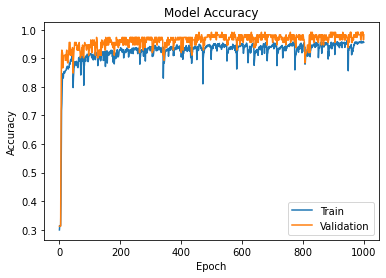

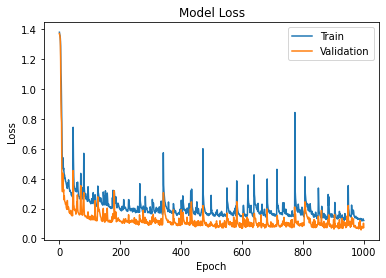

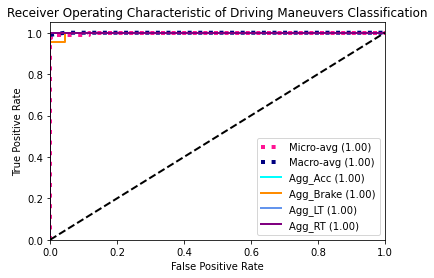

Fold score (accuracy):0.9821428571428571
Train Accuracy 95.80838084220886 Train_loss =  11.072578358495546
Test Accuracy =  98.21428656578064 Test loss =  7.412716560065746
Precision: 0.986486
Recall: 0.979515
F1 score: 0.982598
[[25  0  1  0]
 [ 0 22  1  0]
 [ 0  0 35  0]
 [ 0  0  0 28]]
Supervised Fold #2
X_labeled_train =  (1002, 10, 1)
X_labeled_test =  (112, 10, 1)
Y_labeled_train =  (1002, 4)
Y_labeled_test =  (112, 4)
batch_size =  100
Train on 1002 samples, validate on 112 samples
Epoch 1/1000
1002/1002 [==============================] - 2s 2ms/step - loss: 1.3813 - accuracy: 0.3174 - val_loss: 1.3746 - val_accuracy: 0.3125
Epoch 2/1000
1002/1002 [==============================] - 1s 550us/step - loss: 1.3680 - accuracy: 0.3144 - val_loss: 1.3665 - val_accuracy: 0.3125
Epoch 3/1000
1002/1002 [==============================] - 1s 531us/step - loss: 1.3626 - accuracy: 0.3144 - val_loss: 1.3579 - val_accuracy: 0.3125
Epoch 4/1000
1002/1002 [==============================] - 1s 527

Epoch 53/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.2896 - accuracy: 0.8932 - val_loss: 0.2519 - val_accuracy: 0.8839
Epoch 54/1000
1002/1002 [==============================] - 1s 534us/step - loss: 0.2855 - accuracy: 0.9002 - val_loss: 0.2666 - val_accuracy: 0.9107
Epoch 55/1000
1002/1002 [==============================] - 1s 558us/step - loss: 0.3578 - accuracy: 0.8623 - val_loss: 0.2955 - val_accuracy: 0.9286
Epoch 56/1000
1002/1002 [==============================] - 1s 533us/step - loss: 0.3013 - accuracy: 0.8892 - val_loss: 0.2712 - val_accuracy: 0.8661
Epoch 57/1000
1002/1002 [==============================] - 1s 544us/step - loss: 0.2898 - accuracy: 0.9022 - val_loss: 0.2546 - val_accuracy: 0.8571
Epoch 58/1000
1002/1002 [==============================] - 1s 529us/step - loss: 0.2801 - accuracy: 0.8962 - val_loss: 0.2346 - val_accuracy: 0.8929
Epoch 59/1000
1002/1002 [==============================] - 1s 533us/step - loss: 0.2604 - accuracy: 0.8922

Epoch 108/1000
1002/1002 [==============================] - 1s 1ms/step - loss: 0.2248 - accuracy: 0.9132 - val_loss: 0.2054 - val_accuracy: 0.9464
Epoch 109/1000
1002/1002 [==============================] - 1s 815us/step - loss: 0.2260 - accuracy: 0.9102 - val_loss: 0.1836 - val_accuracy: 0.9554
Epoch 110/1000
1002/1002 [==============================] - 1s 956us/step - loss: 0.2428 - accuracy: 0.9062 - val_loss: 0.2374 - val_accuracy: 0.9107
Epoch 111/1000
1002/1002 [==============================] - 1s 736us/step - loss: 0.2141 - accuracy: 0.9222 - val_loss: 0.1860 - val_accuracy: 0.9464
Epoch 112/1000
1002/1002 [==============================] - 1s 748us/step - loss: 0.2216 - accuracy: 0.9102 - val_loss: 0.1884 - val_accuracy: 0.9464
Epoch 113/1000
1002/1002 [==============================] - 1s 726us/step - loss: 0.2196 - accuracy: 0.9152 - val_loss: 0.1795 - val_accuracy: 0.9286
Epoch 114/1000
1002/1002 [==============================] - 1s 757us/step - loss: 0.2276 - accuracy: 0

1002/1002 [==============================] - 1s 657us/step - loss: 0.2180 - accuracy: 0.9202 - val_loss: 0.2158 - val_accuracy: 0.9107
Epoch 163/1000
1002/1002 [==============================] - 1s 650us/step - loss: 0.2045 - accuracy: 0.9212 - val_loss: 0.1731 - val_accuracy: 0.9286
Epoch 164/1000
1002/1002 [==============================] - 1s 696us/step - loss: 0.1999 - accuracy: 0.9232 - val_loss: 0.1799 - val_accuracy: 0.9286
Epoch 165/1000
1002/1002 [==============================] - 1s 716us/step - loss: 0.1898 - accuracy: 0.9311 - val_loss: 0.1687 - val_accuracy: 0.9375
Epoch 166/1000
1002/1002 [==============================] - 1s 699us/step - loss: 0.2032 - accuracy: 0.9222 - val_loss: 0.1712 - val_accuracy: 0.9286
Epoch 167/1000
1002/1002 [==============================] - 1s 728us/step - loss: 0.1939 - accuracy: 0.9202 - val_loss: 0.1747 - val_accuracy: 0.9286
Epoch 168/1000
1002/1002 [==============================] - 1s 651us/step - loss: 0.2090 - accuracy: 0.9222 - val_l

Epoch 217/1000
1002/1002 [==============================] - 1s 556us/step - loss: 0.2927 - accuracy: 0.8852 - val_loss: 0.2547 - val_accuracy: 0.9107
Epoch 218/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.2607 - accuracy: 0.9202 - val_loss: 0.1990 - val_accuracy: 0.9375
Epoch 219/1000
1002/1002 [==============================] - 1s 544us/step - loss: 0.2367 - accuracy: 0.9212 - val_loss: 0.2085 - val_accuracy: 0.9286
Epoch 220/1000
1002/1002 [==============================] - 1s 552us/step - loss: 0.2574 - accuracy: 0.9102 - val_loss: 0.2036 - val_accuracy: 0.9107
Epoch 221/1000
1002/1002 [==============================] - 1s 546us/step - loss: 0.2204 - accuracy: 0.9202 - val_loss: 0.1897 - val_accuracy: 0.9107
Epoch 222/1000
1002/1002 [==============================] - 1s 558us/step - loss: 0.2328 - accuracy: 0.9102 - val_loss: 0.1836 - val_accuracy: 0.9286
Epoch 223/1000
1002/1002 [==============================] - 1s 545us/step - loss: 0.2087 - accuracy:

1002/1002 [==============================] - 1s 757us/step - loss: 0.1895 - accuracy: 0.9291 - val_loss: 0.1561 - val_accuracy: 0.9375
Epoch 272/1000
1002/1002 [==============================] - 1s 641us/step - loss: 0.2016 - accuracy: 0.9172 - val_loss: 0.1500 - val_accuracy: 0.9464
Epoch 273/1000
1002/1002 [==============================] - 1s 756us/step - loss: 0.1919 - accuracy: 0.9281 - val_loss: 0.1589 - val_accuracy: 0.9286
Epoch 274/1000
1002/1002 [==============================] - 1s 855us/step - loss: 0.1869 - accuracy: 0.9291 - val_loss: 0.1559 - val_accuracy: 0.9464
Epoch 275/1000
1002/1002 [==============================] - 1s 891us/step - loss: 0.1806 - accuracy: 0.9271 - val_loss: 0.1524 - val_accuracy: 0.9375
Epoch 276/1000
1002/1002 [==============================] - 1s 757us/step - loss: 0.1749 - accuracy: 0.9321 - val_loss: 0.1472 - val_accuracy: 0.9375
Epoch 277/1000
1002/1002 [==============================] - 1s 917us/step - loss: 0.1810 - accuracy: 0.9321 - val_l

1002/1002 [==============================] - 1s 555us/step - loss: 0.1812 - accuracy: 0.9271 - val_loss: 0.1493 - val_accuracy: 0.9375
Epoch 326/1000
1002/1002 [==============================] - 1s 561us/step - loss: 0.1812 - accuracy: 0.9301 - val_loss: 0.1524 - val_accuracy: 0.9286
Epoch 327/1000
1002/1002 [==============================] - 1s 626us/step - loss: 0.1801 - accuracy: 0.9281 - val_loss: 0.1509 - val_accuracy: 0.9375
Epoch 328/1000
1002/1002 [==============================] - 1s 637us/step - loss: 0.1810 - accuracy: 0.9251 - val_loss: 0.1514 - val_accuracy: 0.9375
Epoch 329/1000
1002/1002 [==============================] - 1s 576us/step - loss: 0.1750 - accuracy: 0.9301 - val_loss: 0.1537 - val_accuracy: 0.9375
Epoch 330/1000
1002/1002 [==============================] - 1s 715us/step - loss: 0.1752 - accuracy: 0.9301 - val_loss: 0.1448 - val_accuracy: 0.9464
Epoch 331/1000
1002/1002 [==============================] - 1s 718us/step - loss: 0.1693 - accuracy: 0.9401 - val_l

Epoch 380/1000
1002/1002 [==============================] - 1s 773us/step - loss: 0.1685 - accuracy: 0.9371 - val_loss: 0.1417 - val_accuracy: 0.9375
Epoch 381/1000
1002/1002 [==============================] - 1s 829us/step - loss: 0.1729 - accuracy: 0.9371 - val_loss: 0.1348 - val_accuracy: 0.9464
Epoch 382/1000
1002/1002 [==============================] - 1s 593us/step - loss: 0.1636 - accuracy: 0.9411 - val_loss: 0.1359 - val_accuracy: 0.9286
Epoch 383/1000
1002/1002 [==============================] - 1s 539us/step - loss: 0.1654 - accuracy: 0.9351 - val_loss: 0.1398 - val_accuracy: 0.9375
Epoch 384/1000
1002/1002 [==============================] - 1s 565us/step - loss: 0.1597 - accuracy: 0.9401 - val_loss: 0.1340 - val_accuracy: 0.9464
Epoch 385/1000
1002/1002 [==============================] - 1s 624us/step - loss: 0.1527 - accuracy: 0.9431 - val_loss: 0.1381 - val_accuracy: 0.9375
Epoch 386/1000
1002/1002 [==============================] - 1s 730us/step - loss: 0.1602 - accuracy:

1002/1002 [==============================] - 1s 731us/step - loss: 0.1899 - accuracy: 0.9381 - val_loss: 0.1738 - val_accuracy: 0.9375
Epoch 435/1000
1002/1002 [==============================] - 1s 756us/step - loss: 0.1776 - accuracy: 0.9242 - val_loss: 0.1384 - val_accuracy: 0.9286
Epoch 436/1000
1002/1002 [==============================] - 1s 734us/step - loss: 0.1750 - accuracy: 0.9351 - val_loss: 0.1587 - val_accuracy: 0.9464
Epoch 437/1000
1002/1002 [==============================] - 1s 824us/step - loss: 0.1694 - accuracy: 0.9391 - val_loss: 0.1269 - val_accuracy: 0.9554
Epoch 438/1000
1002/1002 [==============================] - 1s 595us/step - loss: 0.1667 - accuracy: 0.9351 - val_loss: 0.1409 - val_accuracy: 0.9554
Epoch 439/1000
1002/1002 [==============================] - 1s 549us/step - loss: 0.1615 - accuracy: 0.9371 - val_loss: 0.1311 - val_accuracy: 0.9464
Epoch 440/1000
1002/1002 [==============================] - 1s 593us/step - loss: 0.1527 - accuracy: 0.9421 - val_l

Epoch 489/1000
1002/1002 [==============================] - 1s 619us/step - loss: 0.1636 - accuracy: 0.9451 - val_loss: 0.1190 - val_accuracy: 0.9464
Epoch 490/1000
1002/1002 [==============================] - 1s 618us/step - loss: 0.1669 - accuracy: 0.9431 - val_loss: 0.1397 - val_accuracy: 0.9554
Epoch 491/1000
1002/1002 [==============================] - 1s 574us/step - loss: 0.1702 - accuracy: 0.9411 - val_loss: 0.1481 - val_accuracy: 0.9464
Epoch 492/1000
1002/1002 [==============================] - 1s 640us/step - loss: 0.1697 - accuracy: 0.9391 - val_loss: 0.1428 - val_accuracy: 0.9643
Epoch 493/1000
1002/1002 [==============================] - 1s 539us/step - loss: 0.1579 - accuracy: 0.9451 - val_loss: 0.1166 - val_accuracy: 0.9554
Epoch 494/1000
1002/1002 [==============================] - 1s 565us/step - loss: 0.1595 - accuracy: 0.9461 - val_loss: 0.1346 - val_accuracy: 0.9554
Epoch 495/1000
1002/1002 [==============================] - 1s 694us/step - loss: 0.1532 - accuracy:

1002/1002 [==============================] - 1s 546us/step - loss: 0.1590 - accuracy: 0.9391 - val_loss: 0.1328 - val_accuracy: 0.9375
Epoch 544/1000
1002/1002 [==============================] - 1s 547us/step - loss: 0.1497 - accuracy: 0.9461 - val_loss: 0.1254 - val_accuracy: 0.9554
Epoch 545/1000
1002/1002 [==============================] - 1s 542us/step - loss: 0.1509 - accuracy: 0.9481 - val_loss: 0.1251 - val_accuracy: 0.9554
Epoch 546/1000
1002/1002 [==============================] - 1s 567us/step - loss: 0.1443 - accuracy: 0.9471 - val_loss: 0.1240 - val_accuracy: 0.9375
Epoch 547/1000
1002/1002 [==============================] - 1s 950us/step - loss: 0.1581 - accuracy: 0.9461 - val_loss: 0.1180 - val_accuracy: 0.9643
Epoch 548/1000
1002/1002 [==============================] - 1s 621us/step - loss: 0.1465 - accuracy: 0.9501 - val_loss: 0.1198 - val_accuracy: 0.9375
Epoch 549/1000
1002/1002 [==============================] - 1s 623us/step - loss: 0.1469 - accuracy: 0.9481 - val_l

Epoch 598/1000
1002/1002 [==============================] - 1s 578us/step - loss: 0.2531 - accuracy: 0.9032 - val_loss: 0.2231 - val_accuracy: 0.9196
Epoch 599/1000
1002/1002 [==============================] - 1s 624us/step - loss: 0.2547 - accuracy: 0.9092 - val_loss: 0.3616 - val_accuracy: 0.8571
Epoch 600/1000
1002/1002 [==============================] - 1s 652us/step - loss: 0.5961 - accuracy: 0.7325 - val_loss: 0.4601 - val_accuracy: 0.7768
Epoch 601/1000
1002/1002 [==============================] - 1s 652us/step - loss: 0.5434 - accuracy: 0.8184 - val_loss: 0.4752 - val_accuracy: 0.8839
Epoch 602/1000
1002/1002 [==============================] - 1s 560us/step - loss: 0.4338 - accuracy: 0.8733 - val_loss: 0.4151 - val_accuracy: 0.8571
Epoch 603/1000
1002/1002 [==============================] - 1s 541us/step - loss: 0.4048 - accuracy: 0.8683 - val_loss: 0.3811 - val_accuracy: 0.8750
Epoch 604/1000
1002/1002 [==============================] - 1s 551us/step - loss: 0.3550 - accuracy:

1002/1002 [==============================] - 1s 549us/step - loss: 0.1908 - accuracy: 0.9261 - val_loss: 0.1823 - val_accuracy: 0.9196
Epoch 653/1000
1002/1002 [==============================] - 1s 543us/step - loss: 0.1917 - accuracy: 0.9321 - val_loss: 0.1776 - val_accuracy: 0.9286
Epoch 654/1000
1002/1002 [==============================] - 1s 552us/step - loss: 0.1993 - accuracy: 0.9261 - val_loss: 0.1767 - val_accuracy: 0.9196
Epoch 655/1000
1002/1002 [==============================] - 1s 579us/step - loss: 0.1935 - accuracy: 0.9321 - val_loss: 0.1741 - val_accuracy: 0.9286
Epoch 656/1000
1002/1002 [==============================] - 1s 551us/step - loss: 0.2019 - accuracy: 0.9311 - val_loss: 0.1695 - val_accuracy: 0.9286
Epoch 657/1000
1002/1002 [==============================] - 1s 548us/step - loss: 0.1865 - accuracy: 0.9311 - val_loss: 0.1777 - val_accuracy: 0.9375
Epoch 658/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.1908 - accuracy: 0.9301 - val_l

Epoch 707/1000
1002/1002 [==============================] - 1s 553us/step - loss: 0.1869 - accuracy: 0.9321 - val_loss: 0.1525 - val_accuracy: 0.9375
Epoch 708/1000
1002/1002 [==============================] - 1s 542us/step - loss: 0.1732 - accuracy: 0.9341 - val_loss: 0.1505 - val_accuracy: 0.9286
Epoch 709/1000
1002/1002 [==============================] - 1s 643us/step - loss: 0.1758 - accuracy: 0.9421 - val_loss: 0.1539 - val_accuracy: 0.9375
Epoch 710/1000
1002/1002 [==============================] - 1s 836us/step - loss: 0.1668 - accuracy: 0.9391 - val_loss: 0.1585 - val_accuracy: 0.9286
Epoch 711/1000
1002/1002 [==============================] - 1s 697us/step - loss: 0.2394 - accuracy: 0.9112 - val_loss: 0.1467 - val_accuracy: 0.9375
Epoch 712/1000
1002/1002 [==============================] - 1s 623us/step - loss: 0.1778 - accuracy: 0.9371 - val_loss: 0.1615 - val_accuracy: 0.9375
Epoch 713/1000
1002/1002 [==============================] - 1s 594us/step - loss: 0.1759 - accuracy:

1002/1002 [==============================] - 1s 548us/step - loss: 0.1405 - accuracy: 0.9491 - val_loss: 0.1627 - val_accuracy: 0.9464
Epoch 762/1000
1002/1002 [==============================] - 1s 634us/step - loss: 0.1561 - accuracy: 0.9431 - val_loss: 0.1844 - val_accuracy: 0.9554
Epoch 763/1000
1002/1002 [==============================] - 1s 638us/step - loss: 0.1626 - accuracy: 0.9361 - val_loss: 0.1670 - val_accuracy: 0.9375
Epoch 764/1000
1002/1002 [==============================] - 1s 576us/step - loss: 0.1532 - accuracy: 0.9431 - val_loss: 0.1588 - val_accuracy: 0.9554
Epoch 765/1000
1002/1002 [==============================] - 1s 590us/step - loss: 0.1530 - accuracy: 0.9391 - val_loss: 0.1587 - val_accuracy: 0.9643
Epoch 766/1000
1002/1002 [==============================] - 1s 552us/step - loss: 0.1686 - accuracy: 0.9361 - val_loss: 0.1527 - val_accuracy: 0.9464
Epoch 767/1000
1002/1002 [==============================] - 1s 553us/step - loss: 0.1622 - accuracy: 0.9431 - val_l

Epoch 816/1000
1002/1002 [==============================] - 1s 560us/step - loss: 0.1529 - accuracy: 0.9481 - val_loss: 0.1723 - val_accuracy: 0.9464
Epoch 817/1000
1002/1002 [==============================] - 1s 523us/step - loss: 0.1478 - accuracy: 0.9501 - val_loss: 0.1628 - val_accuracy: 0.9643
Epoch 818/1000
1002/1002 [==============================] - 1s 595us/step - loss: 0.1472 - accuracy: 0.9451 - val_loss: 0.1625 - val_accuracy: 0.9732
Epoch 819/1000
1002/1002 [==============================] - 1s 621us/step - loss: 0.1713 - accuracy: 0.9391 - val_loss: 0.1711 - val_accuracy: 0.9554
Epoch 820/1000
1002/1002 [==============================] - 1s 600us/step - loss: 0.1642 - accuracy: 0.9431 - val_loss: 0.1235 - val_accuracy: 0.9643
Epoch 821/1000
1002/1002 [==============================] - 1s 582us/step - loss: 0.1548 - accuracy: 0.9471 - val_loss: 0.1803 - val_accuracy: 0.9643
Epoch 822/1000
1002/1002 [==============================] - 1s 542us/step - loss: 0.1532 - accuracy:

1002/1002 [==============================] - 1s 555us/step - loss: 0.2750 - accuracy: 0.9022 - val_loss: 0.1842 - val_accuracy: 0.8929
Epoch 871/1000
1002/1002 [==============================] - 1s 533us/step - loss: 0.2075 - accuracy: 0.9102 - val_loss: 0.2072 - val_accuracy: 0.8839
Epoch 872/1000
1002/1002 [==============================] - 1s 552us/step - loss: 0.1875 - accuracy: 0.9232 - val_loss: 0.1767 - val_accuracy: 0.9196
Epoch 873/1000
1002/1002 [==============================] - 1s 552us/step - loss: 0.1694 - accuracy: 0.9381 - val_loss: 0.1593 - val_accuracy: 0.9464
Epoch 874/1000
1002/1002 [==============================] - 1s 545us/step - loss: 0.1686 - accuracy: 0.9361 - val_loss: 0.1519 - val_accuracy: 0.9375
Epoch 875/1000
1002/1002 [==============================] - 1s 553us/step - loss: 0.1573 - accuracy: 0.9461 - val_loss: 0.1459 - val_accuracy: 0.9464
Epoch 876/1000
1002/1002 [==============================] - 1s 536us/step - loss: 0.1633 - accuracy: 0.9381 - val_l

Epoch 925/1000
1002/1002 [==============================] - 1s 545us/step - loss: 0.1300 - accuracy: 0.9531 - val_loss: 0.1500 - val_accuracy: 0.9643
Epoch 926/1000
1002/1002 [==============================] - 1s 580us/step - loss: 0.1299 - accuracy: 0.9601 - val_loss: 0.1646 - val_accuracy: 0.9643
Epoch 927/1000
1002/1002 [==============================] - 1s 627us/step - loss: 0.1268 - accuracy: 0.9551 - val_loss: 0.1564 - val_accuracy: 0.9643
Epoch 928/1000
1002/1002 [==============================] - 1s 613us/step - loss: 0.1322 - accuracy: 0.9531 - val_loss: 0.1663 - val_accuracy: 0.9643
Epoch 929/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.1293 - accuracy: 0.9541 - val_loss: 0.1571 - val_accuracy: 0.9643
Epoch 930/1000
1002/1002 [==============================] - 1s 537us/step - loss: 0.1257 - accuracy: 0.9541 - val_loss: 0.1707 - val_accuracy: 0.9643
Epoch 931/1000
1002/1002 [==============================] - 1s 554us/step - loss: 0.1330 - accuracy:

1002/1002 [==============================] - 1s 556us/step - loss: 0.1249 - accuracy: 0.9581 - val_loss: 0.1123 - val_accuracy: 0.9732
Epoch 980/1000
1002/1002 [==============================] - 1s 542us/step - loss: 0.2524 - accuracy: 0.9172 - val_loss: 0.1635 - val_accuracy: 0.9196
Epoch 981/1000
1002/1002 [==============================] - 1s 550us/step - loss: 0.2259 - accuracy: 0.9242 - val_loss: 0.1893 - val_accuracy: 0.9107
Epoch 982/1000
1002/1002 [==============================] - 1s 551us/step - loss: 0.1726 - accuracy: 0.9421 - val_loss: 0.1577 - val_accuracy: 0.9196
Epoch 983/1000
1002/1002 [==============================] - 1s 540us/step - loss: 0.1569 - accuracy: 0.9411 - val_loss: 0.1421 - val_accuracy: 0.9196
Epoch 984/1000
1002/1002 [==============================] - 1s 552us/step - loss: 0.1479 - accuracy: 0.9431 - val_loss: 0.1392 - val_accuracy: 0.9643
Epoch 985/1000
1002/1002 [==============================] - 1s 534us/step - loss: 0.1423 - accuracy: 0.9481 - val_l

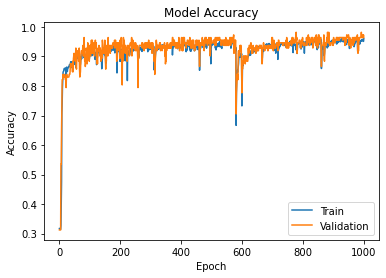

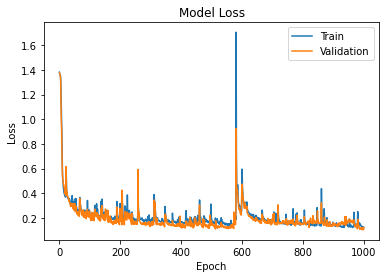

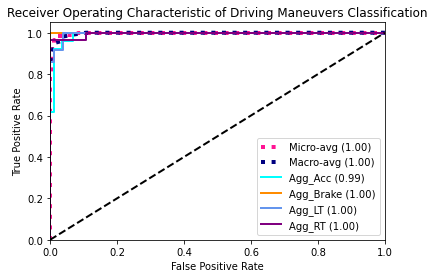

Fold score (accuracy):0.9642857142857143
Train Accuracy 95.90818285942078 Train_loss =  11.768252704433815
Test Accuracy =  96.42857313156128 Test loss =  11.121506882565361
Precision: 0.970263
Recall: 0.962912
F1 score: 0.965761
[[24  0  2  0]
 [ 0 23  0  0]
 [ 0  0 35  0]
 [ 1  0  1 26]]
Supervised Fold #3
X_labeled_train =  (1002, 10, 1)
X_labeled_test =  (112, 10, 1)
Y_labeled_train =  (1002, 4)
Y_labeled_test =  (112, 4)
batch_size =  100
Train on 1002 samples, validate on 112 samples
Epoch 1/1000
1002/1002 [==============================] - 1s 1ms/step - loss: 1.3810 - accuracy: 0.3174 - val_loss: 1.3723 - val_accuracy: 0.3125
Epoch 2/1000
1002/1002 [==============================] - 0s 473us/step - loss: 1.3666 - accuracy: 0.3144 - val_loss: 1.3605 - val_accuracy: 0.3125
Epoch 3/1000
1002/1002 [==============================] - 0s 473us/step - loss: 1.3581 - accuracy: 0.3144 - val_loss: 1.3529 - val_accuracy: 0.3125
Epoch 4/1000
1002/1002 [==============================] - 0s 47

Epoch 53/1000
1002/1002 [==============================] - 0s 470us/step - loss: 0.3059 - accuracy: 0.8812 - val_loss: 0.3186 - val_accuracy: 0.8750
Epoch 54/1000
1002/1002 [==============================] - 0s 476us/step - loss: 0.3124 - accuracy: 0.8892 - val_loss: 0.3408 - val_accuracy: 0.8571
Epoch 55/1000
1002/1002 [==============================] - 0s 471us/step - loss: 0.2957 - accuracy: 0.8862 - val_loss: 0.3243 - val_accuracy: 0.8750
Epoch 56/1000
1002/1002 [==============================] - 0s 469us/step - loss: 0.3137 - accuracy: 0.8892 - val_loss: 0.3325 - val_accuracy: 0.8839
Epoch 57/1000
1002/1002 [==============================] - 0s 471us/step - loss: 0.2895 - accuracy: 0.8802 - val_loss: 0.3176 - val_accuracy: 0.8929
Epoch 58/1000
1002/1002 [==============================] - 0s 465us/step - loss: 0.2899 - accuracy: 0.8962 - val_loss: 0.3311 - val_accuracy: 0.8929
Epoch 59/1000
1002/1002 [==============================] - 0s 476us/step - loss: 0.2805 - accuracy: 0.8932

Epoch 108/1000
1002/1002 [==============================] - 1s 642us/step - loss: 0.2988 - accuracy: 0.8852 - val_loss: 0.3166 - val_accuracy: 0.8839
Epoch 109/1000
1002/1002 [==============================] - 1s 616us/step - loss: 0.2762 - accuracy: 0.9052 - val_loss: 0.2763 - val_accuracy: 0.8839
Epoch 110/1000
1002/1002 [==============================] - 1s 505us/step - loss: 0.2399 - accuracy: 0.9032 - val_loss: 0.2892 - val_accuracy: 0.8839
Epoch 111/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2315 - accuracy: 0.9112 - val_loss: 0.2572 - val_accuracy: 0.9196
Epoch 112/1000
1002/1002 [==============================] - 1s 532us/step - loss: 0.2223 - accuracy: 0.9182 - val_loss: 0.3137 - val_accuracy: 0.8929
Epoch 113/1000
1002/1002 [==============================] - 1s 539us/step - loss: 0.2429 - accuracy: 0.9052 - val_loss: 0.2897 - val_accuracy: 0.9018
Epoch 114/1000
1002/1002 [==============================] - 0s 479us/step - loss: 0.2393 - accuracy:

1002/1002 [==============================] - 0s 463us/step - loss: 0.2048 - accuracy: 0.9222 - val_loss: 0.2521 - val_accuracy: 0.8929
Epoch 163/1000
1002/1002 [==============================] - 0s 477us/step - loss: 0.2089 - accuracy: 0.9222 - val_loss: 0.2370 - val_accuracy: 0.9107
Epoch 164/1000
1002/1002 [==============================] - 1s 526us/step - loss: 0.1944 - accuracy: 0.9291 - val_loss: 0.2609 - val_accuracy: 0.9107
Epoch 165/1000
1002/1002 [==============================] - 1s 595us/step - loss: 0.2039 - accuracy: 0.9242 - val_loss: 0.2352 - val_accuracy: 0.9107
Epoch 166/1000
1002/1002 [==============================] - 1s 509us/step - loss: 0.2000 - accuracy: 0.9212 - val_loss: 0.2541 - val_accuracy: 0.9107
Epoch 167/1000
1002/1002 [==============================] - 1s 612us/step - loss: 0.1896 - accuracy: 0.9242 - val_loss: 0.2403 - val_accuracy: 0.9107
Epoch 168/1000
1002/1002 [==============================] - 1s 534us/step - loss: 0.1916 - accuracy: 0.9261 - val_l

Epoch 217/1000
1002/1002 [==============================] - 1s 639us/step - loss: 0.2061 - accuracy: 0.9212 - val_loss: 0.2355 - val_accuracy: 0.9196
Epoch 218/1000
1002/1002 [==============================] - 1s 654us/step - loss: 0.2028 - accuracy: 0.9242 - val_loss: 0.2481 - val_accuracy: 0.9107
Epoch 219/1000
1002/1002 [==============================] - 1s 658us/step - loss: 0.2026 - accuracy: 0.9251 - val_loss: 0.2414 - val_accuracy: 0.9107
Epoch 220/1000
1002/1002 [==============================] - 1s 593us/step - loss: 0.2080 - accuracy: 0.9271 - val_loss: 0.2406 - val_accuracy: 0.9107
Epoch 221/1000
1002/1002 [==============================] - 1s 603us/step - loss: 0.2045 - accuracy: 0.9222 - val_loss: 0.2451 - val_accuracy: 0.9107
Epoch 222/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.2032 - accuracy: 0.9242 - val_loss: 0.2376 - val_accuracy: 0.9107
Epoch 223/1000
1002/1002 [==============================] - 1s 565us/step - loss: 0.1962 - accuracy:

1002/1002 [==============================] - 1s 632us/step - loss: 0.1788 - accuracy: 0.9301 - val_loss: 0.2416 - val_accuracy: 0.9107
Epoch 272/1000
1002/1002 [==============================] - 1s 694us/step - loss: 0.1900 - accuracy: 0.9222 - val_loss: 0.2358 - val_accuracy: 0.9107
Epoch 273/1000
1002/1002 [==============================] - 1s 563us/step - loss: 0.1784 - accuracy: 0.9291 - val_loss: 0.2383 - val_accuracy: 0.9107
Epoch 274/1000
1002/1002 [==============================] - 1s 642us/step - loss: 0.1706 - accuracy: 0.9291 - val_loss: 0.2363 - val_accuracy: 0.9107
Epoch 275/1000
1002/1002 [==============================] - 1s 736us/step - loss: 0.1796 - accuracy: 0.9311 - val_loss: 0.2301 - val_accuracy: 0.9107
Epoch 276/1000
1002/1002 [==============================] - 1s 611us/step - loss: 0.1765 - accuracy: 0.9271 - val_loss: 0.2255 - val_accuracy: 0.9107
Epoch 277/1000
1002/1002 [==============================] - 1s 580us/step - loss: 0.1776 - accuracy: 0.9331 - val_l

Epoch 326/1000
1002/1002 [==============================] - 1s 706us/step - loss: 0.2016 - accuracy: 0.9192 - val_loss: 0.2515 - val_accuracy: 0.8839
Epoch 327/1000
1002/1002 [==============================] - 1s 640us/step - loss: 0.2013 - accuracy: 0.9281 - val_loss: 0.2317 - val_accuracy: 0.8929
Epoch 328/1000
1002/1002 [==============================] - 1s 560us/step - loss: 0.2021 - accuracy: 0.9291 - val_loss: 0.2410 - val_accuracy: 0.8929
Epoch 329/1000
1002/1002 [==============================] - 1s 612us/step - loss: 0.2081 - accuracy: 0.9222 - val_loss: 0.2352 - val_accuracy: 0.9018
Epoch 330/1000
1002/1002 [==============================] - 1s 651us/step - loss: 0.2326 - accuracy: 0.9062 - val_loss: 0.2435 - val_accuracy: 0.9107
Epoch 331/1000
1002/1002 [==============================] - 1s 579us/step - loss: 0.1979 - accuracy: 0.9301 - val_loss: 0.2347 - val_accuracy: 0.8929
Epoch 332/1000
1002/1002 [==============================] - 1s 646us/step - loss: 0.1857 - accuracy:

1002/1002 [==============================] - 1s 572us/step - loss: 0.1624 - accuracy: 0.9411 - val_loss: 0.2094 - val_accuracy: 0.9196
Epoch 381/1000
1002/1002 [==============================] - 1s 575us/step - loss: 0.1642 - accuracy: 0.9361 - val_loss: 0.2453 - val_accuracy: 0.9018
Epoch 382/1000
1002/1002 [==============================] - 1s 629us/step - loss: 0.2022 - accuracy: 0.9251 - val_loss: 0.2749 - val_accuracy: 0.9286
Epoch 383/1000
1002/1002 [==============================] - 1s 540us/step - loss: 0.1866 - accuracy: 0.9371 - val_loss: 0.2136 - val_accuracy: 0.9107
Epoch 384/1000
1002/1002 [==============================] - 1s 564us/step - loss: 0.1652 - accuracy: 0.9381 - val_loss: 0.2242 - val_accuracy: 0.9286
Epoch 385/1000
1002/1002 [==============================] - 1s 556us/step - loss: 0.1624 - accuracy: 0.9431 - val_loss: 0.2545 - val_accuracy: 0.9018
Epoch 386/1000
1002/1002 [==============================] - 1s 557us/step - loss: 0.1685 - accuracy: 0.9341 - val_l

Epoch 435/1000
1002/1002 [==============================] - 1s 692us/step - loss: 0.1979 - accuracy: 0.9172 - val_loss: 0.2263 - val_accuracy: 0.9196
Epoch 436/1000
1002/1002 [==============================] - 1s 546us/step - loss: 0.2215 - accuracy: 0.9162 - val_loss: 0.2646 - val_accuracy: 0.9018
Epoch 437/1000
1002/1002 [==============================] - 1s 554us/step - loss: 0.1982 - accuracy: 0.9212 - val_loss: 0.2740 - val_accuracy: 0.8839
Epoch 438/1000
1002/1002 [==============================] - 1s 578us/step - loss: 0.1833 - accuracy: 0.9172 - val_loss: 0.2375 - val_accuracy: 0.9018
Epoch 439/1000
1002/1002 [==============================] - 1s 577us/step - loss: 0.1840 - accuracy: 0.9232 - val_loss: 0.2292 - val_accuracy: 0.8929
Epoch 440/1000
1002/1002 [==============================] - 1s 606us/step - loss: 0.2102 - accuracy: 0.9212 - val_loss: 0.3082 - val_accuracy: 0.9018
Epoch 441/1000
1002/1002 [==============================] - 1s 597us/step - loss: 0.2039 - accuracy:

1002/1002 [==============================] - 0s 471us/step - loss: 0.1601 - accuracy: 0.9431 - val_loss: 0.2082 - val_accuracy: 0.9107
Epoch 490/1000
1002/1002 [==============================] - 0s 470us/step - loss: 0.1524 - accuracy: 0.9471 - val_loss: 0.2180 - val_accuracy: 0.9196
Epoch 491/1000
1002/1002 [==============================] - 0s 471us/step - loss: 0.1607 - accuracy: 0.9471 - val_loss: 0.2014 - val_accuracy: 0.9375
Epoch 492/1000
1002/1002 [==============================] - 0s 470us/step - loss: 0.1515 - accuracy: 0.9411 - val_loss: 0.2165 - val_accuracy: 0.9286
Epoch 493/1000
1002/1002 [==============================] - 1s 555us/step - loss: 0.1542 - accuracy: 0.9411 - val_loss: 0.2003 - val_accuracy: 0.9375
Epoch 494/1000
1002/1002 [==============================] - 0s 466us/step - loss: 0.1492 - accuracy: 0.9471 - val_loss: 0.2294 - val_accuracy: 0.9286
Epoch 495/1000
1002/1002 [==============================] - 1s 516us/step - loss: 0.1582 - accuracy: 0.9451 - val_l

Epoch 544/1000
1002/1002 [==============================] - 1s 534us/step - loss: 0.1574 - accuracy: 0.9491 - val_loss: 0.2306 - val_accuracy: 0.9018
Epoch 545/1000
1002/1002 [==============================] - 0s 473us/step - loss: 0.1722 - accuracy: 0.9401 - val_loss: 0.2181 - val_accuracy: 0.9018
Epoch 546/1000
1002/1002 [==============================] - 0s 497us/step - loss: 0.1507 - accuracy: 0.9511 - val_loss: 0.2204 - val_accuracy: 0.9196
Epoch 547/1000
1002/1002 [==============================] - 0s 471us/step - loss: 0.1459 - accuracy: 0.9541 - val_loss: 0.2249 - val_accuracy: 0.9196
Epoch 548/1000
1002/1002 [==============================] - 0s 474us/step - loss: 0.1447 - accuracy: 0.9551 - val_loss: 0.2245 - val_accuracy: 0.9196
Epoch 549/1000
1002/1002 [==============================] - 0s 472us/step - loss: 0.1480 - accuracy: 0.9501 - val_loss: 0.2206 - val_accuracy: 0.9196
Epoch 550/1000
1002/1002 [==============================] - 0s 479us/step - loss: 0.1417 - accuracy:

1002/1002 [==============================] - 0s 473us/step - loss: 0.1410 - accuracy: 0.9501 - val_loss: 0.2354 - val_accuracy: 0.9107
Epoch 599/1000
1002/1002 [==============================] - 0s 477us/step - loss: 0.1413 - accuracy: 0.9531 - val_loss: 0.2324 - val_accuracy: 0.9375
Epoch 600/1000
1002/1002 [==============================] - 0s 474us/step - loss: 0.1395 - accuracy: 0.9481 - val_loss: 0.2354 - val_accuracy: 0.9107
Epoch 601/1000
1002/1002 [==============================] - 0s 482us/step - loss: 0.1613 - accuracy: 0.9421 - val_loss: 0.2165 - val_accuracy: 0.9107
Epoch 602/1000
1002/1002 [==============================] - 0s 470us/step - loss: 0.1510 - accuracy: 0.9501 - val_loss: 0.2271 - val_accuracy: 0.9018
Epoch 603/1000
1002/1002 [==============================] - 1s 559us/step - loss: 0.1547 - accuracy: 0.9461 - val_loss: 0.1974 - val_accuracy: 0.9375
Epoch 604/1000
1002/1002 [==============================] - 0s 472us/step - loss: 0.1400 - accuracy: 0.9511 - val_l

Epoch 653/1000
1002/1002 [==============================] - 0s 487us/step - loss: 0.1519 - accuracy: 0.9471 - val_loss: 0.2049 - val_accuracy: 0.9196
Epoch 654/1000
1002/1002 [==============================] - 0s 487us/step - loss: 0.1563 - accuracy: 0.9451 - val_loss: 0.1939 - val_accuracy: 0.9196
Epoch 655/1000
1002/1002 [==============================] - 0s 488us/step - loss: 0.1472 - accuracy: 0.9481 - val_loss: 0.2065 - val_accuracy: 0.9196
Epoch 656/1000
1002/1002 [==============================] - 0s 485us/step - loss: 0.1391 - accuracy: 0.9511 - val_loss: 0.2063 - val_accuracy: 0.9375
Epoch 657/1000
1002/1002 [==============================] - 0s 486us/step - loss: 0.1393 - accuracy: 0.9531 - val_loss: 0.2306 - val_accuracy: 0.9286
Epoch 658/1000
1002/1002 [==============================] - 0s 482us/step - loss: 0.1421 - accuracy: 0.9521 - val_loss: 0.2150 - val_accuracy: 0.9375
Epoch 659/1000
1002/1002 [==============================] - 0s 486us/step - loss: 0.1523 - accuracy:

1002/1002 [==============================] - 1s 607us/step - loss: 0.1397 - accuracy: 0.9541 - val_loss: 0.2067 - val_accuracy: 0.9286
Epoch 708/1000
1002/1002 [==============================] - 1s 629us/step - loss: 0.1369 - accuracy: 0.9571 - val_loss: 0.2099 - val_accuracy: 0.9196
Epoch 709/1000
1002/1002 [==============================] - 1s 614us/step - loss: 0.1375 - accuracy: 0.9531 - val_loss: 0.2567 - val_accuracy: 0.9196
Epoch 710/1000
1002/1002 [==============================] - 1s 666us/step - loss: 0.1662 - accuracy: 0.9501 - val_loss: 0.2353 - val_accuracy: 0.9375
Epoch 711/1000
1002/1002 [==============================] - 1s 669us/step - loss: 0.1797 - accuracy: 0.9361 - val_loss: 0.1906 - val_accuracy: 0.9286
Epoch 712/1000
1002/1002 [==============================] - 1s 739us/step - loss: 0.1437 - accuracy: 0.9521 - val_loss: 0.2051 - val_accuracy: 0.9286
Epoch 713/1000
1002/1002 [==============================] - 1s 730us/step - loss: 0.1341 - accuracy: 0.9581 - val_l

Epoch 762/1000
1002/1002 [==============================] - 1s 537us/step - loss: 0.1267 - accuracy: 0.9581 - val_loss: 0.1986 - val_accuracy: 0.9375
Epoch 763/1000
1002/1002 [==============================] - 1s 573us/step - loss: 0.1280 - accuracy: 0.9541 - val_loss: 0.2189 - val_accuracy: 0.9375
Epoch 764/1000
1002/1002 [==============================] - 1s 525us/step - loss: 0.1277 - accuracy: 0.9591 - val_loss: 0.2052 - val_accuracy: 0.9286
Epoch 765/1000
1002/1002 [==============================] - 1s 505us/step - loss: 0.1241 - accuracy: 0.9591 - val_loss: 0.1962 - val_accuracy: 0.9375
Epoch 766/1000
1002/1002 [==============================] - 0s 489us/step - loss: 0.1193 - accuracy: 0.9581 - val_loss: 0.1993 - val_accuracy: 0.9464
Epoch 767/1000
1002/1002 [==============================] - 0s 493us/step - loss: 0.1230 - accuracy: 0.9581 - val_loss: 0.1961 - val_accuracy: 0.9375
Epoch 768/1000
1002/1002 [==============================] - 1s 607us/step - loss: 0.1351 - accuracy:

1002/1002 [==============================] - 1s 503us/step - loss: 0.1314 - accuracy: 0.9571 - val_loss: 0.1936 - val_accuracy: 0.9464
Epoch 817/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1430 - accuracy: 0.9541 - val_loss: 0.1714 - val_accuracy: 0.9464
Epoch 818/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1654 - accuracy: 0.9461 - val_loss: 0.2569 - val_accuracy: 0.9196
Epoch 819/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1531 - accuracy: 0.9471 - val_loss: 0.1806 - val_accuracy: 0.9464
Epoch 820/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1333 - accuracy: 0.9521 - val_loss: 0.1792 - val_accuracy: 0.9375
Epoch 821/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1236 - accuracy: 0.9581 - val_loss: 0.1823 - val_accuracy: 0.9464
Epoch 822/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1182 - accuracy: 0.9591 - val_l

1002/1002 [==============================] - 0s 495us/step - loss: 0.1268 - accuracy: 0.9581 - val_loss: 0.1866 - val_accuracy: 0.9375
Epoch 871/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1233 - accuracy: 0.9561 - val_loss: 0.1954 - val_accuracy: 0.9464
Epoch 872/1000
1002/1002 [==============================] - 0s 487us/step - loss: 0.1241 - accuracy: 0.9561 - val_loss: 0.1870 - val_accuracy: 0.9375
Epoch 873/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1170 - accuracy: 0.9611 - val_loss: 0.1902 - val_accuracy: 0.9464
Epoch 874/1000
1002/1002 [==============================] - 1s 551us/step - loss: 0.1188 - accuracy: 0.9591 - val_loss: 0.1898 - val_accuracy: 0.9464
Epoch 875/1000
1002/1002 [==============================] - 1s 535us/step - loss: 0.1174 - accuracy: 0.9601 - val_loss: 0.1862 - val_accuracy: 0.9464
Epoch 876/1000
1002/1002 [==============================] - 0s 487us/step - loss: 0.1192 - accuracy: 0.9561 - val_l

Epoch 925/1000
1002/1002 [==============================] - 0s 487us/step - loss: 0.1223 - accuracy: 0.9591 - val_loss: 0.2095 - val_accuracy: 0.9286
Epoch 926/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1165 - accuracy: 0.9571 - val_loss: 0.2294 - val_accuracy: 0.9464
Epoch 927/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1150 - accuracy: 0.9571 - val_loss: 0.2215 - val_accuracy: 0.9464
Epoch 928/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1145 - accuracy: 0.9571 - val_loss: 0.2182 - val_accuracy: 0.9464
Epoch 929/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1226 - accuracy: 0.9571 - val_loss: 0.2229 - val_accuracy: 0.9464
Epoch 930/1000
1002/1002 [==============================] - 1s 614us/step - loss: 0.1157 - accuracy: 0.9561 - val_loss: 0.2074 - val_accuracy: 0.9464
Epoch 931/1000
1002/1002 [==============================] - 1s 582us/step - loss: 0.1195 - accuracy:

1002/1002 [==============================] - 0s 487us/step - loss: 0.1149 - accuracy: 0.9561 - val_loss: 0.1932 - val_accuracy: 0.9464
Epoch 980/1000
1002/1002 [==============================] - 0s 487us/step - loss: 0.1181 - accuracy: 0.9571 - val_loss: 0.1816 - val_accuracy: 0.9464
Epoch 981/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1136 - accuracy: 0.9621 - val_loss: 0.1749 - val_accuracy: 0.9554
Epoch 982/1000
1002/1002 [==============================] - 0s 487us/step - loss: 0.1084 - accuracy: 0.9591 - val_loss: 0.2015 - val_accuracy: 0.9464
Epoch 983/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1580 - accuracy: 0.9421 - val_loss: 0.1867 - val_accuracy: 0.9554
Epoch 984/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1353 - accuracy: 0.9561 - val_loss: 0.1623 - val_accuracy: 0.9554
Epoch 985/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1396 - accuracy: 0.9511 - val_l

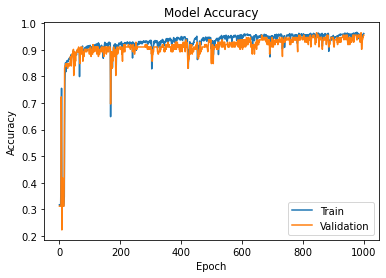

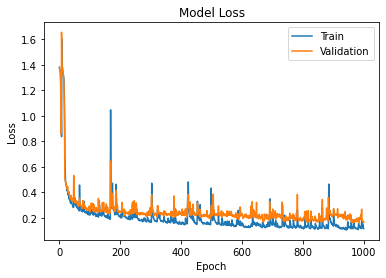

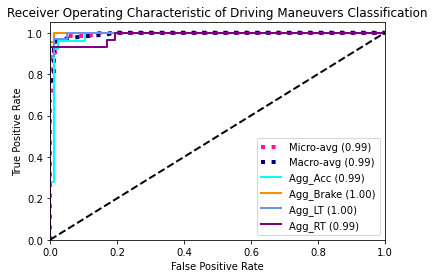

Fold score (accuracy):0.9553571428571429
Train Accuracy 96.50698900222778 Train_loss =  10.332893316963336
Test Accuracy =  95.53571343421936 Test loss =  16.982255236611568
Precision: 0.957143
Recall: 0.954746
F1 score: 0.954788
[[24  0  1  0]
 [ 1 22  0  0]
 [ 1  0 34  0]
 [ 2  0  0 27]]
Supervised Fold #4
X_labeled_train =  (1002, 10, 1)
X_labeled_test =  (112, 10, 1)
Y_labeled_train =  (1002, 4)
Y_labeled_test =  (112, 4)
batch_size =  100
Train on 1002 samples, validate on 112 samples
Epoch 1/1000
1002/1002 [==============================] - 2s 2ms/step - loss: 1.3818 - accuracy: 0.3134 - val_loss: 1.3752 - val_accuracy: 0.3125
Epoch 2/1000
1002/1002 [==============================] - 1s 566us/step - loss: 1.3712 - accuracy: 0.3144 - val_loss: 1.3618 - val_accuracy: 0.3125
Epoch 3/1000
1002/1002 [==============================] - 1s 511us/step - loss: 1.3574 - accuracy: 0.3144 - val_loss: 1.3442 - val_accuracy: 0.3125
Epoch 4/1000
1002/1002 [==============================] - 1s 51

Epoch 53/1000
1002/1002 [==============================] - 1s 535us/step - loss: 0.3397 - accuracy: 0.8733 - val_loss: 0.3540 - val_accuracy: 0.8839
Epoch 54/1000
1002/1002 [==============================] - 1s 551us/step - loss: 0.3457 - accuracy: 0.8623 - val_loss: 0.6704 - val_accuracy: 0.7143
Epoch 55/1000
1002/1002 [==============================] - 1s 551us/step - loss: 0.3831 - accuracy: 0.8433 - val_loss: 0.4474 - val_accuracy: 0.8661
Epoch 56/1000
1002/1002 [==============================] - 1s 566us/step - loss: 0.3707 - accuracy: 0.8523 - val_loss: 0.3786 - val_accuracy: 0.8839
Epoch 57/1000
1002/1002 [==============================] - 1s 598us/step - loss: 0.3494 - accuracy: 0.8603 - val_loss: 0.3325 - val_accuracy: 0.8839
Epoch 58/1000
1002/1002 [==============================] - 1s 582us/step - loss: 0.3113 - accuracy: 0.8752 - val_loss: 0.3301 - val_accuracy: 0.8929
Epoch 59/1000
1002/1002 [==============================] - 1s 559us/step - loss: 0.3076 - accuracy: 0.8792

Epoch 108/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.2151 - accuracy: 0.9212 - val_loss: 0.3828 - val_accuracy: 0.8750
Epoch 109/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.3322 - accuracy: 0.8992 - val_loss: 0.2951 - val_accuracy: 0.8750
Epoch 110/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2440 - accuracy: 0.9162 - val_loss: 0.2783 - val_accuracy: 0.9018
Epoch 111/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2291 - accuracy: 0.9152 - val_loss: 0.2751 - val_accuracy: 0.9107
Epoch 112/1000
1002/1002 [==============================] - 1s 559us/step - loss: 0.2223 - accuracy: 0.9202 - val_loss: 0.2567 - val_accuracy: 0.9107
Epoch 113/1000
1002/1002 [==============================] - 1s 543us/step - loss: 0.2205 - accuracy: 0.9172 - val_loss: 0.2400 - val_accuracy: 0.9196
Epoch 114/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.3646 - accuracy:

1002/1002 [==============================] - 1s 524us/step - loss: 0.2044 - accuracy: 0.9222 - val_loss: 0.2419 - val_accuracy: 0.9107
Epoch 163/1000
1002/1002 [==============================] - 1s 656us/step - loss: 0.1993 - accuracy: 0.9251 - val_loss: 0.2275 - val_accuracy: 0.9018
Epoch 164/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1990 - accuracy: 0.9271 - val_loss: 0.2296 - val_accuracy: 0.9107
Epoch 165/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1956 - accuracy: 0.9222 - val_loss: 0.2355 - val_accuracy: 0.9018
Epoch 166/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1990 - accuracy: 0.9251 - val_loss: 0.2191 - val_accuracy: 0.9107
Epoch 167/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2430 - accuracy: 0.9122 - val_loss: 0.2552 - val_accuracy: 0.8929
Epoch 168/1000
1002/1002 [==============================] - 1s 527us/step - loss: 0.2307 - accuracy: 0.9162 - val_l

Epoch 217/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1947 - accuracy: 0.9281 - val_loss: 0.2382 - val_accuracy: 0.8929
Epoch 218/1000
1002/1002 [==============================] - 1s 535us/step - loss: 0.1830 - accuracy: 0.9222 - val_loss: 0.2860 - val_accuracy: 0.8839
Epoch 219/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2655 - accuracy: 0.8982 - val_loss: 0.3142 - val_accuracy: 0.8839
Epoch 220/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.2931 - accuracy: 0.8822 - val_loss: 0.2696 - val_accuracy: 0.8839
Epoch 221/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2297 - accuracy: 0.9002 - val_loss: 0.2309 - val_accuracy: 0.9286
Epoch 222/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2244 - accuracy: 0.9232 - val_loss: 0.2299 - val_accuracy: 0.9196
Epoch 223/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2103 - accuracy:

1002/1002 [==============================] - 1s 503us/step - loss: 0.1794 - accuracy: 0.9242 - val_loss: 0.2175 - val_accuracy: 0.9018
Epoch 272/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1712 - accuracy: 0.9311 - val_loss: 0.2160 - val_accuracy: 0.9018
Epoch 273/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1709 - accuracy: 0.9311 - val_loss: 0.2400 - val_accuracy: 0.9018
Epoch 274/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1727 - accuracy: 0.9321 - val_loss: 0.2379 - val_accuracy: 0.8929
Epoch 275/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1719 - accuracy: 0.9281 - val_loss: 0.2300 - val_accuracy: 0.8929
Epoch 276/1000
1002/1002 [==============================] - 1s 774us/step - loss: 0.1691 - accuracy: 0.9301 - val_loss: 0.2228 - val_accuracy: 0.9018
Epoch 277/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1701 - accuracy: 0.9341 - val_l

Epoch 326/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1656 - accuracy: 0.9381 - val_loss: 0.2271 - val_accuracy: 0.9018
Epoch 327/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1714 - accuracy: 0.9401 - val_loss: 0.2178 - val_accuracy: 0.9107
Epoch 328/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1785 - accuracy: 0.9291 - val_loss: 0.2449 - val_accuracy: 0.9196
Epoch 329/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1758 - accuracy: 0.9411 - val_loss: 0.2403 - val_accuracy: 0.9107
Epoch 330/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1626 - accuracy: 0.9421 - val_loss: 0.2250 - val_accuracy: 0.9107
Epoch 331/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1778 - accuracy: 0.9381 - val_loss: 0.2138 - val_accuracy: 0.9107
Epoch 332/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1654 - accuracy:

1002/1002 [==============================] - 1s 503us/step - loss: 0.1515 - accuracy: 0.9471 - val_loss: 0.2396 - val_accuracy: 0.9107
Epoch 381/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1589 - accuracy: 0.9421 - val_loss: 0.2306 - val_accuracy: 0.9107
Epoch 382/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1577 - accuracy: 0.9451 - val_loss: 0.2360 - val_accuracy: 0.9196
Epoch 383/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1569 - accuracy: 0.9431 - val_loss: 0.2455 - val_accuracy: 0.9107
Epoch 384/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1541 - accuracy: 0.9471 - val_loss: 0.2313 - val_accuracy: 0.9286
Epoch 385/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1543 - accuracy: 0.9491 - val_loss: 0.2514 - val_accuracy: 0.9018
Epoch 386/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1579 - accuracy: 0.9461 - val_l

Epoch 435/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1882 - accuracy: 0.9281 - val_loss: 0.2127 - val_accuracy: 0.9107
Epoch 436/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1701 - accuracy: 0.9351 - val_loss: 0.2472 - val_accuracy: 0.8929
Epoch 437/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1593 - accuracy: 0.9391 - val_loss: 0.2181 - val_accuracy: 0.9107
Epoch 438/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1597 - accuracy: 0.9471 - val_loss: 0.2562 - val_accuracy: 0.9018
Epoch 439/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1610 - accuracy: 0.9401 - val_loss: 0.2377 - val_accuracy: 0.9018
Epoch 440/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1618 - accuracy: 0.9411 - val_loss: 0.2499 - val_accuracy: 0.9107
Epoch 441/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1582 - accuracy:

1002/1002 [==============================] - 1s 511us/step - loss: 0.1982 - accuracy: 0.9331 - val_loss: 0.1944 - val_accuracy: 0.9286
Epoch 490/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1994 - accuracy: 0.9341 - val_loss: 0.1995 - val_accuracy: 0.9196
Epoch 491/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1907 - accuracy: 0.9361 - val_loss: 0.1738 - val_accuracy: 0.9196
Epoch 492/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.2079 - accuracy: 0.9261 - val_loss: 0.1994 - val_accuracy: 0.9196
Epoch 493/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1845 - accuracy: 0.9431 - val_loss: 0.1634 - val_accuracy: 0.9375
Epoch 494/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1813 - accuracy: 0.9371 - val_loss: 0.1848 - val_accuracy: 0.9286
Epoch 495/1000
1002/1002 [==============================] - 1s 527us/step - loss: 0.1825 - accuracy: 0.9361 - val_l

Epoch 544/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1874 - accuracy: 0.9361 - val_loss: 0.2470 - val_accuracy: 0.9107
Epoch 545/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1673 - accuracy: 0.9541 - val_loss: 0.1776 - val_accuracy: 0.9107
Epoch 546/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1598 - accuracy: 0.9501 - val_loss: 0.1967 - val_accuracy: 0.9107
Epoch 547/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1551 - accuracy: 0.9501 - val_loss: 0.2010 - val_accuracy: 0.9107
Epoch 548/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1805 - accuracy: 0.9351 - val_loss: 0.2065 - val_accuracy: 0.9018
Epoch 549/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1592 - accuracy: 0.9441 - val_loss: 0.1911 - val_accuracy: 0.9018
Epoch 550/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1476 - accuracy:

1002/1002 [==============================] - 1s 503us/step - loss: 0.1486 - accuracy: 0.9531 - val_loss: 0.1848 - val_accuracy: 0.9375
Epoch 599/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1479 - accuracy: 0.9541 - val_loss: 0.1846 - val_accuracy: 0.9196
Epoch 600/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1442 - accuracy: 0.9601 - val_loss: 0.1949 - val_accuracy: 0.9286
Epoch 601/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1380 - accuracy: 0.9561 - val_loss: 0.1893 - val_accuracy: 0.9196
Epoch 602/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1400 - accuracy: 0.9511 - val_loss: 0.1749 - val_accuracy: 0.9375
Epoch 603/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1382 - accuracy: 0.9581 - val_loss: 0.1747 - val_accuracy: 0.9286
Epoch 604/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1367 - accuracy: 0.9581 - val_l

Epoch 653/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1364 - accuracy: 0.9531 - val_loss: 0.1685 - val_accuracy: 0.9375
Epoch 654/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1676 - accuracy: 0.9401 - val_loss: 0.2303 - val_accuracy: 0.9107
Epoch 655/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1650 - accuracy: 0.9501 - val_loss: 0.1988 - val_accuracy: 0.9018
Epoch 656/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1658 - accuracy: 0.9421 - val_loss: 0.1823 - val_accuracy: 0.9286
Epoch 657/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1682 - accuracy: 0.9331 - val_loss: 0.1751 - val_accuracy: 0.9196
Epoch 658/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1446 - accuracy: 0.9551 - val_loss: 0.2094 - val_accuracy: 0.9196
Epoch 659/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1362 - accuracy:

1002/1002 [==============================] - 1s 503us/step - loss: 0.1408 - accuracy: 0.9521 - val_loss: 0.1602 - val_accuracy: 0.9286
Epoch 708/1000
1002/1002 [==============================] - 1s 519us/step - loss: 0.1456 - accuracy: 0.9541 - val_loss: 0.1847 - val_accuracy: 0.9018
Epoch 709/1000
1002/1002 [==============================] - 1s 511us/step - loss: 0.1384 - accuracy: 0.9541 - val_loss: 0.1678 - val_accuracy: 0.9107
Epoch 710/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1433 - accuracy: 0.9511 - val_loss: 0.1748 - val_accuracy: 0.9196
Epoch 711/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1413 - accuracy: 0.9561 - val_loss: 0.1613 - val_accuracy: 0.9375
Epoch 712/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1372 - accuracy: 0.9561 - val_loss: 0.1898 - val_accuracy: 0.9196
Epoch 713/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1410 - accuracy: 0.9521 - val_l

Epoch 762/1000
1002/1002 [==============================] - 1s 870us/step - loss: 0.2195 - accuracy: 0.9132 - val_loss: 0.2242 - val_accuracy: 0.9286
Epoch 763/1000
1002/1002 [==============================] - 1s 1ms/step - loss: 0.2093 - accuracy: 0.9271 - val_loss: 0.2172 - val_accuracy: 0.9107
Epoch 764/1000
1002/1002 [==============================] - 1s 694us/step - loss: 0.2012 - accuracy: 0.9311 - val_loss: 0.2061 - val_accuracy: 0.9107
Epoch 765/1000
1002/1002 [==============================] - 1s 870us/step - loss: 0.2063 - accuracy: 0.9232 - val_loss: 0.1960 - val_accuracy: 0.9107
Epoch 766/1000
1002/1002 [==============================] - 1s 686us/step - loss: 0.1929 - accuracy: 0.9381 - val_loss: 0.1993 - val_accuracy: 0.9196
Epoch 767/1000
1002/1002 [==============================] - 1s 678us/step - loss: 0.1816 - accuracy: 0.9391 - val_loss: 0.1891 - val_accuracy: 0.9196
Epoch 768/1000
1002/1002 [==============================] - 1s 830us/step - loss: 0.2499 - accuracy: 0

1002/1002 [==============================] - 1s 606us/step - loss: 0.1570 - accuracy: 0.9461 - val_loss: 0.1935 - val_accuracy: 0.9196
Epoch 817/1000
1002/1002 [==============================] - 1s 590us/step - loss: 0.1440 - accuracy: 0.9551 - val_loss: 0.1789 - val_accuracy: 0.9196
Epoch 818/1000
1002/1002 [==============================] - 1s 598us/step - loss: 0.1361 - accuracy: 0.9571 - val_loss: 0.1620 - val_accuracy: 0.9286
Epoch 819/1000
1002/1002 [==============================] - 1s 606us/step - loss: 0.1393 - accuracy: 0.9581 - val_loss: 0.1829 - val_accuracy: 0.9196
Epoch 820/1000
1002/1002 [==============================] - 1s 630us/step - loss: 0.1329 - accuracy: 0.9551 - val_loss: 0.1665 - val_accuracy: 0.9375
Epoch 821/1000
1002/1002 [==============================] - 1s 614us/step - loss: 0.1513 - accuracy: 0.9481 - val_loss: 0.1930 - val_accuracy: 0.9107
Epoch 822/1000
1002/1002 [==============================] - 1s 598us/step - loss: 0.1850 - accuracy: 0.9391 - val_l

Epoch 871/1000
1002/1002 [==============================] - 1s 774us/step - loss: 0.1190 - accuracy: 0.9621 - val_loss: 0.1461 - val_accuracy: 0.9464
Epoch 872/1000
1002/1002 [==============================] - 1s 949us/step - loss: 0.1287 - accuracy: 0.9561 - val_loss: 0.1882 - val_accuracy: 0.9286
Epoch 873/1000
1002/1002 [==============================] - 1s 965us/step - loss: 0.1202 - accuracy: 0.9581 - val_loss: 0.1645 - val_accuracy: 0.9286
Epoch 874/1000
1002/1002 [==============================] - 1s 653us/step - loss: 0.1265 - accuracy: 0.9581 - val_loss: 0.1560 - val_accuracy: 0.9375
Epoch 875/1000
1002/1002 [==============================] - 1s 624us/step - loss: 0.1298 - accuracy: 0.9611 - val_loss: 0.1753 - val_accuracy: 0.9286
Epoch 876/1000
1002/1002 [==============================] - 1s 734us/step - loss: 0.1167 - accuracy: 0.9611 - val_loss: 0.1571 - val_accuracy: 0.9286
Epoch 877/1000
1002/1002 [==============================] - 1s 846us/step - loss: 0.1207 - accuracy:

1002/1002 [==============================] - 1s 598us/step - loss: 0.1164 - accuracy: 0.9641 - val_loss: 0.1523 - val_accuracy: 0.9286
Epoch 926/1000
1002/1002 [==============================] - 1s 661us/step - loss: 0.1162 - accuracy: 0.9641 - val_loss: 0.1758 - val_accuracy: 0.9286
Epoch 927/1000
1002/1002 [==============================] - 1s 742us/step - loss: 0.1177 - accuracy: 0.9631 - val_loss: 0.1557 - val_accuracy: 0.9286
Epoch 928/1000
1002/1002 [==============================] - 1s 786us/step - loss: 0.1307 - accuracy: 0.9571 - val_loss: 0.1814 - val_accuracy: 0.9286
Epoch 929/1000
1002/1002 [==============================] - 1s 600us/step - loss: 0.1265 - accuracy: 0.9541 - val_loss: 0.1697 - val_accuracy: 0.9375
Epoch 930/1000
1002/1002 [==============================] - 1s 823us/step - loss: 0.1234 - accuracy: 0.9591 - val_loss: 0.1714 - val_accuracy: 0.9286
Epoch 931/1000
1002/1002 [==============================] - 1s 701us/step - loss: 0.1172 - accuracy: 0.9571 - val_l

Epoch 980/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1214 - accuracy: 0.9621 - val_loss: 0.2057 - val_accuracy: 0.9286
Epoch 981/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1102 - accuracy: 0.9621 - val_loss: 0.1993 - val_accuracy: 0.9286
Epoch 982/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.1091 - accuracy: 0.9651 - val_loss: 0.1387 - val_accuracy: 0.9464
Epoch 983/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.3515 - accuracy: 0.9172 - val_loss: 0.5343 - val_accuracy: 0.8839
Epoch 984/1000
1002/1002 [==============================] - 1s 503us/step - loss: 0.2152 - accuracy: 0.9281 - val_loss: 0.2581 - val_accuracy: 0.9018
Epoch 985/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1715 - accuracy: 0.9391 - val_loss: 0.2299 - val_accuracy: 0.9196
Epoch 986/1000
1002/1002 [==============================] - 0s 495us/step - loss: 0.1512 - accuracy:

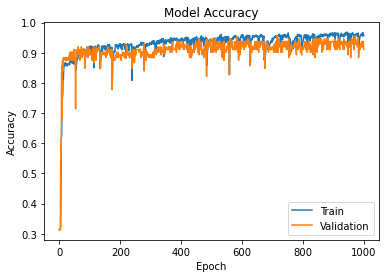

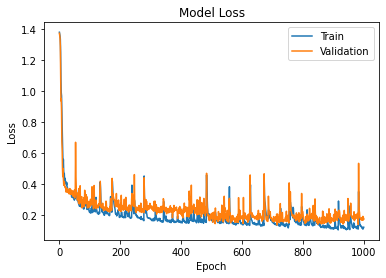

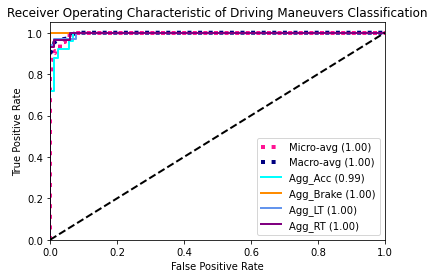

Fold score (accuracy):0.9107142857142857
Train Accuracy 96.50698900222778 Train_loss =  10.310325291221147
Test Accuracy =  91.07142686843872 Test loss =  17.318187654018402
Precision: 0.918420
Recall: 0.899019
F1 score: 0.902880
[[23  0  2  0]
 [ 4 17  1  1]
 [ 0  0 34  1]
 [ 1  0  0 28]]
Supervised Fold #5
X_labeled_train =  (1003, 10, 1)
X_labeled_test =  (111, 10, 1)
Y_labeled_train =  (1003, 4)
Y_labeled_test =  (111, 4)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/1000
1003/1003 [==============================] - 2s 2ms/step - loss: 1.3801 - accuracy: 0.3111 - val_loss: 1.3672 - val_accuracy: 0.3153
Epoch 2/1000
1003/1003 [==============================] - 1s 502us/step - loss: 1.3661 - accuracy: 0.3141 - val_loss: 1.3538 - val_accuracy: 0.3153
Epoch 3/1000
1003/1003 [==============================] - 1s 566us/step - loss: 1.3529 - accuracy: 0.3141 - val_loss: 1.3380 - val_accuracy: 0.3153
Epoch 4/1000
1003/1003 [==============================] - 1s 61

1003/1003 [==============================] - 1s 654us/step - loss: 0.3099 - accuracy: 0.8913 - val_loss: 0.1814 - val_accuracy: 0.9459
Epoch 53/1000
1003/1003 [==============================] - 1s 773us/step - loss: 0.3411 - accuracy: 0.8754 - val_loss: 0.2571 - val_accuracy: 0.9189
Epoch 54/1000
1003/1003 [==============================] - 1s 646us/step - loss: 0.3558 - accuracy: 0.8953 - val_loss: 0.2213 - val_accuracy: 0.9369
Epoch 55/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.2933 - accuracy: 0.8913 - val_loss: 0.1716 - val_accuracy: 0.9189
Epoch 56/1000
1003/1003 [==============================] - 1s 757us/step - loss: 0.2902 - accuracy: 0.8983 - val_loss: 0.1649 - val_accuracy: 0.9369
Epoch 57/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.2857 - accuracy: 0.9013 - val_loss: 0.1452 - val_accuracy: 0.9459
Epoch 58/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.2591 - accuracy: 0.9133 - val_loss: 0

Epoch 107/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2512 - accuracy: 0.9043 - val_loss: 0.1365 - val_accuracy: 0.9550
Epoch 108/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2296 - accuracy: 0.9163 - val_loss: 0.1293 - val_accuracy: 0.9640
Epoch 109/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2766 - accuracy: 0.9123 - val_loss: 0.1623 - val_accuracy: 0.9640
Epoch 110/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2528 - accuracy: 0.9083 - val_loss: 0.1301 - val_accuracy: 0.9640
Epoch 111/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2406 - accuracy: 0.9153 - val_loss: 0.1270 - val_accuracy: 0.9640
Epoch 112/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.2210 - accuracy: 0.9172 - val_loss: 0.1106 - val_accuracy: 0.9640
Epoch 113/1000
1003/1003 [==============================] - 1s 518us/step - loss: 0.2146 - accuracy:

1003/1003 [==============================] - 0s 480us/step - loss: 0.2069 - accuracy: 0.9143 - val_loss: 0.1064 - val_accuracy: 0.9640
Epoch 162/1000
1003/1003 [==============================] - 0s 478us/step - loss: 0.1989 - accuracy: 0.9153 - val_loss: 0.1126 - val_accuracy: 0.9730
Epoch 163/1000
1003/1003 [==============================] - 0s 482us/step - loss: 0.1980 - accuracy: 0.9182 - val_loss: 0.0932 - val_accuracy: 0.9640
Epoch 164/1000
1003/1003 [==============================] - 0s 477us/step - loss: 0.1927 - accuracy: 0.9202 - val_loss: 0.0989 - val_accuracy: 0.9640
Epoch 165/1000
1003/1003 [==============================] - 0s 476us/step - loss: 0.1881 - accuracy: 0.9232 - val_loss: 0.1044 - val_accuracy: 0.9640
Epoch 166/1000
1003/1003 [==============================] - 0s 489us/step - loss: 0.2284 - accuracy: 0.9093 - val_loss: 0.1343 - val_accuracy: 0.9550
Epoch 167/1000
1003/1003 [==============================] - 0s 489us/step - loss: 0.2230 - accuracy: 0.9192 - val_l

Epoch 216/1000
1003/1003 [==============================] - 0s 480us/step - loss: 0.2096 - accuracy: 0.9172 - val_loss: 0.1085 - val_accuracy: 0.9730
Epoch 217/1000
1003/1003 [==============================] - 0s 478us/step - loss: 0.1933 - accuracy: 0.9282 - val_loss: 0.1019 - val_accuracy: 0.9820
Epoch 218/1000
1003/1003 [==============================] - 0s 477us/step - loss: 0.1914 - accuracy: 0.9222 - val_loss: 0.1127 - val_accuracy: 0.9640
Epoch 219/1000
1003/1003 [==============================] - 0s 476us/step - loss: 0.1899 - accuracy: 0.9242 - val_loss: 0.0977 - val_accuracy: 0.9820
Epoch 220/1000
1003/1003 [==============================] - 0s 476us/step - loss: 0.1780 - accuracy: 0.9302 - val_loss: 0.1473 - val_accuracy: 0.9459
Epoch 221/1000
1003/1003 [==============================] - 0s 476us/step - loss: 0.2980 - accuracy: 0.8853 - val_loss: 0.1164 - val_accuracy: 0.9640
Epoch 222/1000
1003/1003 [==============================] - 0s 478us/step - loss: 0.2400 - accuracy:

1003/1003 [==============================] - 1s 577us/step - loss: 0.1845 - accuracy: 0.9392 - val_loss: 0.0980 - val_accuracy: 0.9730
Epoch 271/1000
1003/1003 [==============================] - 1s 884us/step - loss: 0.1753 - accuracy: 0.9382 - val_loss: 0.0961 - val_accuracy: 0.9640
Epoch 272/1000
1003/1003 [==============================] - 1s 695us/step - loss: 0.1716 - accuracy: 0.9402 - val_loss: 0.0943 - val_accuracy: 0.9640
Epoch 273/1000
1003/1003 [==============================] - 1s 524us/step - loss: 0.1615 - accuracy: 0.9372 - val_loss: 0.0954 - val_accuracy: 0.9550
Epoch 274/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.1756 - accuracy: 0.9342 - val_loss: 0.0965 - val_accuracy: 0.9640
Epoch 275/1000
1003/1003 [==============================] - 1s 515us/step - loss: 0.1764 - accuracy: 0.9312 - val_loss: 0.0907 - val_accuracy: 0.9640
Epoch 276/1000
1003/1003 [==============================] - 1s 533us/step - loss: 0.1675 - accuracy: 0.9392 - val_l

Epoch 325/1000
1003/1003 [==============================] - 1s 748us/step - loss: 0.1832 - accuracy: 0.9322 - val_loss: 0.0953 - val_accuracy: 0.9550
Epoch 326/1000
1003/1003 [==============================] - 1s 684us/step - loss: 0.1660 - accuracy: 0.9382 - val_loss: 0.0923 - val_accuracy: 0.9550
Epoch 327/1000
1003/1003 [==============================] - 1s 860us/step - loss: 0.1692 - accuracy: 0.9342 - val_loss: 0.0900 - val_accuracy: 0.9550
Epoch 328/1000
1003/1003 [==============================] - 1s 746us/step - loss: 0.1598 - accuracy: 0.9352 - val_loss: 0.0944 - val_accuracy: 0.9640
Epoch 329/1000
1003/1003 [==============================] - 1s 663us/step - loss: 0.1589 - accuracy: 0.9482 - val_loss: 0.0929 - val_accuracy: 0.9730
Epoch 330/1000
1003/1003 [==============================] - 1s 659us/step - loss: 0.1629 - accuracy: 0.9412 - val_loss: 0.0997 - val_accuracy: 0.9730
Epoch 331/1000
1003/1003 [==============================] - 1s 661us/step - loss: 0.1711 - accuracy:

1003/1003 [==============================] - 1s 693us/step - loss: 0.1566 - accuracy: 0.9462 - val_loss: 0.0996 - val_accuracy: 0.9730
Epoch 380/1000
1003/1003 [==============================] - 1s 689us/step - loss: 0.1475 - accuracy: 0.9472 - val_loss: 0.0936 - val_accuracy: 0.9730
Epoch 381/1000
1003/1003 [==============================] - 1s 718us/step - loss: 0.1535 - accuracy: 0.9462 - val_loss: 0.0937 - val_accuracy: 0.9730
Epoch 382/1000
1003/1003 [==============================] - 1s 804us/step - loss: 0.1500 - accuracy: 0.9501 - val_loss: 0.0926 - val_accuracy: 0.9730
Epoch 383/1000
1003/1003 [==============================] - 1s 915us/step - loss: 0.1507 - accuracy: 0.9422 - val_loss: 0.0955 - val_accuracy: 0.9730
Epoch 384/1000
1003/1003 [==============================] - 1s 833us/step - loss: 0.1541 - accuracy: 0.9462 - val_loss: 0.0923 - val_accuracy: 0.9730
Epoch 385/1000
1003/1003 [==============================] - 1s 715us/step - loss: 0.1504 - accuracy: 0.9541 - val_l

Epoch 434/1000
1003/1003 [==============================] - 1s 623us/step - loss: 0.1656 - accuracy: 0.9402 - val_loss: 0.0967 - val_accuracy: 0.9640
Epoch 435/1000
1003/1003 [==============================] - 1s 618us/step - loss: 0.1720 - accuracy: 0.9352 - val_loss: 0.1009 - val_accuracy: 0.9550
Epoch 436/1000
1003/1003 [==============================] - 1s 593us/step - loss: 0.1560 - accuracy: 0.9412 - val_loss: 0.1134 - val_accuracy: 0.9550
Epoch 437/1000
1003/1003 [==============================] - 1s 851us/step - loss: 0.1479 - accuracy: 0.9482 - val_loss: 0.0935 - val_accuracy: 0.9730
Epoch 438/1000
1003/1003 [==============================] - 1s 617us/step - loss: 0.1591 - accuracy: 0.9472 - val_loss: 0.1004 - val_accuracy: 0.9640
Epoch 439/1000
1003/1003 [==============================] - 1s 776us/step - loss: 0.1912 - accuracy: 0.9272 - val_loss: 0.1156 - val_accuracy: 0.9730
Epoch 440/1000
1003/1003 [==============================] - 1s 810us/step - loss: 0.1970 - accuracy:

1003/1003 [==============================] - 0s 480us/step - loss: 0.1551 - accuracy: 0.9492 - val_loss: 0.0898 - val_accuracy: 0.9640
Epoch 489/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.1573 - accuracy: 0.9482 - val_loss: 0.0839 - val_accuracy: 0.9640
Epoch 490/1000
1003/1003 [==============================] - 0s 495us/step - loss: 0.1481 - accuracy: 0.9482 - val_loss: 0.0854 - val_accuracy: 0.9640
Epoch 491/1000
1003/1003 [==============================] - 0s 485us/step - loss: 0.1531 - accuracy: 0.9511 - val_loss: 0.0887 - val_accuracy: 0.9730
Epoch 492/1000
1003/1003 [==============================] - 0s 489us/step - loss: 0.1434 - accuracy: 0.9452 - val_loss: 0.0939 - val_accuracy: 0.9730
Epoch 493/1000
1003/1003 [==============================] - 1s 509us/step - loss: 0.1498 - accuracy: 0.9452 - val_loss: 0.0917 - val_accuracy: 0.9730
Epoch 494/1000
1003/1003 [==============================] - 0s 490us/step - loss: 0.1431 - accuracy: 0.9531 - val_l

Epoch 543/1000
1003/1003 [==============================] - 1s 562us/step - loss: 0.1613 - accuracy: 0.9501 - val_loss: 0.1225 - val_accuracy: 0.9730
Epoch 544/1000
1003/1003 [==============================] - 1s 725us/step - loss: 0.1522 - accuracy: 0.9472 - val_loss: 0.1059 - val_accuracy: 0.9730
Epoch 545/1000
1003/1003 [==============================] - 1s 579us/step - loss: 0.1908 - accuracy: 0.9322 - val_loss: 0.1223 - val_accuracy: 0.9640
Epoch 546/1000
1003/1003 [==============================] - 1s 754us/step - loss: 0.1842 - accuracy: 0.9402 - val_loss: 0.1167 - val_accuracy: 0.9730
Epoch 547/1000
1003/1003 [==============================] - 1s 555us/step - loss: 0.1658 - accuracy: 0.9372 - val_loss: 0.1013 - val_accuracy: 0.9640
Epoch 548/1000
1003/1003 [==============================] - 1s 532us/step - loss: 0.1514 - accuracy: 0.9432 - val_loss: 0.0940 - val_accuracy: 0.9730
Epoch 549/1000
1003/1003 [==============================] - 1s 518us/step - loss: 0.1500 - accuracy:

1003/1003 [==============================] - 1s 568us/step - loss: 0.1355 - accuracy: 0.9531 - val_loss: 0.0903 - val_accuracy: 0.9730
Epoch 598/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.1363 - accuracy: 0.9561 - val_loss: 0.0907 - val_accuracy: 0.9730
Epoch 599/1000
1003/1003 [==============================] - 0s 479us/step - loss: 0.1321 - accuracy: 0.9561 - val_loss: 0.1125 - val_accuracy: 0.9730
Epoch 600/1000
1003/1003 [==============================] - 0s 475us/step - loss: 0.1759 - accuracy: 0.9312 - val_loss: 0.1028 - val_accuracy: 0.9730
Epoch 601/1000
1003/1003 [==============================] - 0s 490us/step - loss: 0.1845 - accuracy: 0.9352 - val_loss: 0.1189 - val_accuracy: 0.9640
Epoch 602/1000
1003/1003 [==============================] - 0s 476us/step - loss: 0.1866 - accuracy: 0.9232 - val_loss: 0.1157 - val_accuracy: 0.9730
Epoch 603/1000
1003/1003 [==============================] - 1s 569us/step - loss: 0.1626 - accuracy: 0.9402 - val_l

1003/1003 [==============================] - 1s 763us/step - loss: 0.1213 - accuracy: 0.9611 - val_loss: 0.1037 - val_accuracy: 0.9730
Epoch 652/1000
1003/1003 [==============================] - 1s 693us/step - loss: 0.1265 - accuracy: 0.9571 - val_loss: 0.1044 - val_accuracy: 0.9730
Epoch 653/1000
1003/1003 [==============================] - 1s 917us/step - loss: 0.1272 - accuracy: 0.9591 - val_loss: 0.1062 - val_accuracy: 0.9730
Epoch 654/1000
1003/1003 [==============================] - 1s 627us/step - loss: 0.1322 - accuracy: 0.9571 - val_loss: 0.1160 - val_accuracy: 0.9730
Epoch 655/1000
1003/1003 [==============================] - 1s 543us/step - loss: 0.1355 - accuracy: 0.9511 - val_loss: 0.1039 - val_accuracy: 0.9730
Epoch 656/1000
1003/1003 [==============================] - 1s 702us/step - loss: 0.1268 - accuracy: 0.9531 - val_loss: 0.1072 - val_accuracy: 0.9730
Epoch 657/1000
1003/1003 [==============================] - 1s 813us/step - loss: 0.1247 - accuracy: 0.9561 - val_l

Epoch 706/1000
1003/1003 [==============================] - 1s 885us/step - loss: 0.1484 - accuracy: 0.9531 - val_loss: 0.0901 - val_accuracy: 0.9730
Epoch 707/1000
1003/1003 [==============================] - 1s 795us/step - loss: 0.1309 - accuracy: 0.9561 - val_loss: 0.0974 - val_accuracy: 0.9730
Epoch 708/1000
1003/1003 [==============================] - 1s 786us/step - loss: 0.1302 - accuracy: 0.9541 - val_loss: 0.0913 - val_accuracy: 0.9730
Epoch 709/1000
1003/1003 [==============================] - 1s 808us/step - loss: 0.1366 - accuracy: 0.9551 - val_loss: 0.1015 - val_accuracy: 0.9730
Epoch 710/1000
1003/1003 [==============================] - 1s 800us/step - loss: 0.1273 - accuracy: 0.9551 - val_loss: 0.0940 - val_accuracy: 0.9730
Epoch 711/1000
1003/1003 [==============================] - 1s 729us/step - loss: 0.1474 - accuracy: 0.9472 - val_loss: 0.1110 - val_accuracy: 0.9640
Epoch 712/1000
1003/1003 [==============================] - 1s 594us/step - loss: 0.1337 - accuracy:

1003/1003 [==============================] - 1s 614us/step - loss: 0.1647 - accuracy: 0.9482 - val_loss: 0.0766 - val_accuracy: 0.9820
Epoch 761/1000
1003/1003 [==============================] - 1s 612us/step - loss: 0.1623 - accuracy: 0.9422 - val_loss: 0.0761 - val_accuracy: 0.9820
Epoch 762/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1598 - accuracy: 0.9452 - val_loss: 0.0781 - val_accuracy: 0.9820
Epoch 763/1000
1003/1003 [==============================] - 1s 688us/step - loss: 0.1571 - accuracy: 0.9492 - val_loss: 0.0755 - val_accuracy: 0.9730
Epoch 764/1000
1003/1003 [==============================] - 1s 616us/step - loss: 0.1530 - accuracy: 0.9482 - val_loss: 0.0780 - val_accuracy: 0.9730
Epoch 765/1000
1003/1003 [==============================] - 1s 617us/step - loss: 0.1426 - accuracy: 0.9551 - val_loss: 0.0844 - val_accuracy: 0.9730
Epoch 766/1000
1003/1003 [==============================] - 1s 617us/step - loss: 0.1404 - accuracy: 0.9531 - val_l

Epoch 815/1000
1003/1003 [==============================] - 1s 592us/step - loss: 0.1249 - accuracy: 0.9571 - val_loss: 0.1020 - val_accuracy: 0.9730
Epoch 816/1000
1003/1003 [==============================] - 1s 595us/step - loss: 0.1585 - accuracy: 0.9452 - val_loss: 0.1134 - val_accuracy: 0.9730
Epoch 817/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1483 - accuracy: 0.9452 - val_loss: 0.1002 - val_accuracy: 0.9730
Epoch 818/1000
1003/1003 [==============================] - 1s 679us/step - loss: 0.1378 - accuracy: 0.9482 - val_loss: 0.1042 - val_accuracy: 0.9730
Epoch 819/1000
1003/1003 [==============================] - 1s 632us/step - loss: 0.1270 - accuracy: 0.9551 - val_loss: 0.1079 - val_accuracy: 0.9730
Epoch 820/1000
1003/1003 [==============================] - 1s 594us/step - loss: 0.1327 - accuracy: 0.9501 - val_loss: 0.0940 - val_accuracy: 0.9730
Epoch 821/1000
1003/1003 [==============================] - 1s 575us/step - loss: 0.1284 - accuracy:

1003/1003 [==============================] - 1s 595us/step - loss: 0.1193 - accuracy: 0.9591 - val_loss: 0.0925 - val_accuracy: 0.9730
Epoch 870/1000
1003/1003 [==============================] - 1s 587us/step - loss: 0.1131 - accuracy: 0.9611 - val_loss: 0.0995 - val_accuracy: 0.9730
Epoch 871/1000
1003/1003 [==============================] - 1s 613us/step - loss: 0.1109 - accuracy: 0.9621 - val_loss: 0.0991 - val_accuracy: 0.9730
Epoch 872/1000
1003/1003 [==============================] - 1s 589us/step - loss: 0.1185 - accuracy: 0.9531 - val_loss: 0.1039 - val_accuracy: 0.9730
Epoch 873/1000
1003/1003 [==============================] - 1s 591us/step - loss: 0.1407 - accuracy: 0.9442 - val_loss: 0.1084 - val_accuracy: 0.9730
Epoch 874/1000
1003/1003 [==============================] - 1s 595us/step - loss: 0.1218 - accuracy: 0.9571 - val_loss: 0.0991 - val_accuracy: 0.9730
Epoch 875/1000
1003/1003 [==============================] - 1s 618us/step - loss: 0.1143 - accuracy: 0.9581 - val_l

Epoch 924/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1042 - accuracy: 0.9631 - val_loss: 0.1037 - val_accuracy: 0.9730
Epoch 925/1000
1003/1003 [==============================] - 1s 591us/step - loss: 0.1055 - accuracy: 0.9591 - val_loss: 0.1031 - val_accuracy: 0.9730
Epoch 926/1000
1003/1003 [==============================] - 1s 588us/step - loss: 0.1038 - accuracy: 0.9631 - val_loss: 0.1128 - val_accuracy: 0.9730
Epoch 927/1000
1003/1003 [==============================] - 1s 592us/step - loss: 0.1035 - accuracy: 0.9611 - val_loss: 0.1295 - val_accuracy: 0.9730
Epoch 928/1000
1003/1003 [==============================] - 1s 588us/step - loss: 0.1240 - accuracy: 0.9581 - val_loss: 0.1154 - val_accuracy: 0.9730
Epoch 929/1000
1003/1003 [==============================] - 1s 578us/step - loss: 0.1364 - accuracy: 0.9501 - val_loss: 0.1165 - val_accuracy: 0.9730
Epoch 930/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1107 - accuracy:

1003/1003 [==============================] - 1s 597us/step - loss: 0.1653 - accuracy: 0.9412 - val_loss: 0.1024 - val_accuracy: 0.9820
Epoch 979/1000
1003/1003 [==============================] - 1s 592us/step - loss: 0.1585 - accuracy: 0.9531 - val_loss: 0.0887 - val_accuracy: 0.9730
Epoch 980/1000
1003/1003 [==============================] - 1s 585us/step - loss: 0.1448 - accuracy: 0.9531 - val_loss: 0.0798 - val_accuracy: 0.9730
Epoch 981/1000
1003/1003 [==============================] - 1s 576us/step - loss: 0.1374 - accuracy: 0.9541 - val_loss: 0.0846 - val_accuracy: 0.9730
Epoch 982/1000
1003/1003 [==============================] - 1s 581us/step - loss: 0.1333 - accuracy: 0.9551 - val_loss: 0.0862 - val_accuracy: 0.9730
Epoch 983/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1382 - accuracy: 0.9581 - val_loss: 0.0948 - val_accuracy: 0.9730
Epoch 984/1000
1003/1003 [==============================] - 1s 576us/step - loss: 0.1268 - accuracy: 0.9601 - val_l

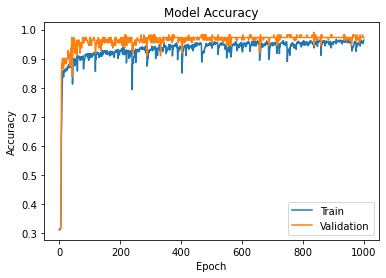

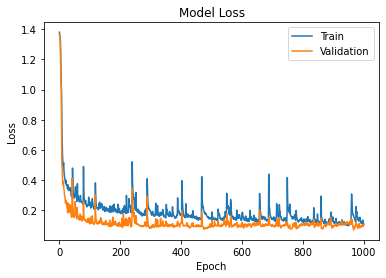

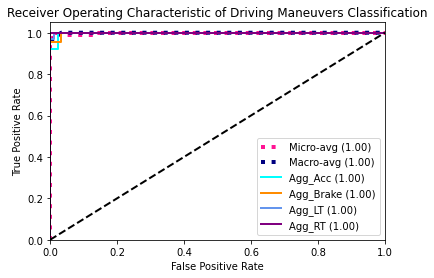

Fold score (accuracy):0.972972972972973
Train Accuracy 96.51046991348267 Train_loss =  9.778920650957588
Test Accuracy =  97.29729890823364 Test loss =  10.561016765800682
Precision: 0.971275
Recall: 0.968636
F1 score: 0.969809
[[23  1  1  0]
 [ 1 21  0  0]
 [ 0  0 35  0]
 [ 0  0  0 29]]
Supervised Fold #6
X_labeled_train =  (1003, 10, 1)
X_labeled_test =  (111, 10, 1)
Y_labeled_train =  (1003, 4)
Y_labeled_test =  (111, 4)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/1000
1003/1003 [==============================] - 2s 2ms/step - loss: 1.3825 - accuracy: 0.3161 - val_loss: 1.3738 - val_accuracy: 0.3153
Epoch 2/1000
1003/1003 [==============================] - 1s 612us/step - loss: 1.3708 - accuracy: 0.3141 - val_loss: 1.3595 - val_accuracy: 0.3153
Epoch 3/1000
1003/1003 [==============================] - 1s 617us/step - loss: 1.3552 - accuracy: 0.3141 - val_loss: 1.3376 - val_accuracy: 0.3153
Epoch 4/1000
1003/1003 [==============================] - 1s 650u

Epoch 53/1000
1003/1003 [==============================] - 1s 611us/step - loss: 0.3356 - accuracy: 0.8784 - val_loss: 0.2553 - val_accuracy: 0.8829
Epoch 54/1000
1003/1003 [==============================] - 1s 594us/step - loss: 0.3283 - accuracy: 0.8873 - val_loss: 0.2495 - val_accuracy: 0.8919
Epoch 55/1000
1003/1003 [==============================] - 1s 592us/step - loss: 0.3230 - accuracy: 0.8804 - val_loss: 0.2373 - val_accuracy: 0.8829
Epoch 56/1000
1003/1003 [==============================] - 1s 620us/step - loss: 0.3467 - accuracy: 0.8694 - val_loss: 0.2989 - val_accuracy: 0.8559
Epoch 57/1000
1003/1003 [==============================] - 1s 613us/step - loss: 0.3214 - accuracy: 0.8694 - val_loss: 0.2583 - val_accuracy: 0.8829
Epoch 58/1000
1003/1003 [==============================] - 1s 609us/step - loss: 0.3127 - accuracy: 0.8833 - val_loss: 0.2319 - val_accuracy: 0.8919
Epoch 59/1000
1003/1003 [==============================] - 1s 611us/step - loss: 0.3225 - accuracy: 0.8893

1003/1003 [==============================] - 1s 660us/step - loss: 0.2476 - accuracy: 0.9053 - val_loss: 0.1597 - val_accuracy: 0.9279
Epoch 108/1000
1003/1003 [==============================] - 1s 633us/step - loss: 0.2515 - accuracy: 0.9073 - val_loss: 0.1717 - val_accuracy: 0.9099
Epoch 109/1000
1003/1003 [==============================] - 1s 629us/step - loss: 0.2484 - accuracy: 0.9143 - val_loss: 0.1598 - val_accuracy: 0.9279
Epoch 110/1000
1003/1003 [==============================] - 1s 673us/step - loss: 0.2381 - accuracy: 0.9212 - val_loss: 0.1602 - val_accuracy: 0.9279
Epoch 111/1000
1003/1003 [==============================] - 1s 677us/step - loss: 0.2235 - accuracy: 0.9192 - val_loss: 0.1539 - val_accuracy: 0.9189
Epoch 112/1000
1003/1003 [==============================] - 1s 781us/step - loss: 0.2249 - accuracy: 0.9212 - val_loss: 0.1667 - val_accuracy: 0.9189
Epoch 113/1000
1003/1003 [==============================] - 1s 735us/step - loss: 0.2769 - accuracy: 0.9063 - val_l

1003/1003 [==============================] - 1s 667us/step - loss: 0.3267 - accuracy: 0.8814 - val_loss: 0.1902 - val_accuracy: 0.9099
Epoch 162/1000
1003/1003 [==============================] - 1s 659us/step - loss: 0.2705 - accuracy: 0.9003 - val_loss: 0.2999 - val_accuracy: 0.8829
Epoch 163/1000
1003/1003 [==============================] - 1s 723us/step - loss: 0.3824 - accuracy: 0.8345 - val_loss: 0.2488 - val_accuracy: 0.9279
Epoch 164/1000
1003/1003 [==============================] - 1s 745us/step - loss: 0.2900 - accuracy: 0.9073 - val_loss: 0.2192 - val_accuracy: 0.8919
Epoch 165/1000
1003/1003 [==============================] - 1s 751us/step - loss: 0.2681 - accuracy: 0.8883 - val_loss: 0.1839 - val_accuracy: 0.9099
Epoch 166/1000
1003/1003 [==============================] - 1s 722us/step - loss: 0.2263 - accuracy: 0.9163 - val_loss: 0.1422 - val_accuracy: 0.9369
Epoch 167/1000
1003/1003 [==============================] - 1s 744us/step - loss: 0.2117 - accuracy: 0.9182 - val_l

1003/1003 [==============================] - 1s 763us/step - loss: 0.2040 - accuracy: 0.9202 - val_loss: 0.1508 - val_accuracy: 0.9459
Epoch 216/1000
1003/1003 [==============================] - 1s 653us/step - loss: 0.1965 - accuracy: 0.9272 - val_loss: 0.1510 - val_accuracy: 0.9189
Epoch 217/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.2026 - accuracy: 0.9182 - val_loss: 0.1373 - val_accuracy: 0.9369
Epoch 218/1000
1003/1003 [==============================] - 1s 633us/step - loss: 0.1881 - accuracy: 0.9272 - val_loss: 0.1340 - val_accuracy: 0.9369
Epoch 219/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.2361 - accuracy: 0.9123 - val_loss: 0.1846 - val_accuracy: 0.9459
Epoch 220/1000
1003/1003 [==============================] - 1s 653us/step - loss: 0.2163 - accuracy: 0.9202 - val_loss: 0.1583 - val_accuracy: 0.9189
Epoch 221/1000
1003/1003 [==============================] - 1s 631us/step - loss: 0.2053 - accuracy: 0.9192 - val_l

1003/1003 [==============================] - 1s 592us/step - loss: 0.1660 - accuracy: 0.9372 - val_loss: 0.1560 - val_accuracy: 0.9189
Epoch 270/1000
1003/1003 [==============================] - 1s 612us/step - loss: 0.1723 - accuracy: 0.9342 - val_loss: 0.1680 - val_accuracy: 0.9099
Epoch 271/1000
1003/1003 [==============================] - 1s 618us/step - loss: 0.1762 - accuracy: 0.9312 - val_loss: 0.1444 - val_accuracy: 0.9189
Epoch 272/1000
1003/1003 [==============================] - 1s 625us/step - loss: 0.1718 - accuracy: 0.9332 - val_loss: 0.1882 - val_accuracy: 0.9189
Epoch 273/1000
1003/1003 [==============================] - 1s 817us/step - loss: 0.1688 - accuracy: 0.9422 - val_loss: 0.1647 - val_accuracy: 0.9189
Epoch 274/1000
1003/1003 [==============================] - 1s 979us/step - loss: 0.1916 - accuracy: 0.9232 - val_loss: 0.1661 - val_accuracy: 0.9189
Epoch 275/1000
1003/1003 [==============================] - 1s 808us/step - loss: 0.1823 - accuracy: 0.9332 - val_l

1003/1003 [==============================] - 1s 691us/step - loss: 0.1959 - accuracy: 0.9232 - val_loss: 0.1765 - val_accuracy: 0.9279
Epoch 324/1000
1003/1003 [==============================] - 1s 697us/step - loss: 0.1845 - accuracy: 0.9362 - val_loss: 0.1703 - val_accuracy: 0.9189
Epoch 325/1000
1003/1003 [==============================] - 1s 701us/step - loss: 0.1845 - accuracy: 0.9332 - val_loss: 0.1581 - val_accuracy: 0.9189
Epoch 326/1000
1003/1003 [==============================] - 1s 724us/step - loss: 0.1637 - accuracy: 0.9442 - val_loss: 0.1535 - val_accuracy: 0.9279
Epoch 327/1000
1003/1003 [==============================] - 1s 689us/step - loss: 0.1684 - accuracy: 0.9442 - val_loss: 0.2095 - val_accuracy: 0.9369
Epoch 328/1000
1003/1003 [==============================] - 1s 666us/step - loss: 0.1944 - accuracy: 0.9342 - val_loss: 0.5364 - val_accuracy: 0.9009
Epoch 329/1000
1003/1003 [==============================] - 1s 688us/step - loss: 0.3555 - accuracy: 0.8903 - val_l

1003/1003 [==============================] - 1s 738us/step - loss: 0.1615 - accuracy: 0.9442 - val_loss: 0.1575 - val_accuracy: 0.9369
Epoch 378/1000
1003/1003 [==============================] - 1s 867us/step - loss: 0.1515 - accuracy: 0.9422 - val_loss: 0.1745 - val_accuracy: 0.9369
Epoch 379/1000
1003/1003 [==============================] - 1s 626us/step - loss: 0.1698 - accuracy: 0.9362 - val_loss: 0.3447 - val_accuracy: 0.9279
Epoch 380/1000
1003/1003 [==============================] - 1s 625us/step - loss: 0.2406 - accuracy: 0.9212 - val_loss: 0.1434 - val_accuracy: 0.9369
Epoch 381/1000
1003/1003 [==============================] - 1s 625us/step - loss: 0.1914 - accuracy: 0.9322 - val_loss: 0.1366 - val_accuracy: 0.9369
Epoch 382/1000
1003/1003 [==============================] - 1s 618us/step - loss: 0.1717 - accuracy: 0.9402 - val_loss: 0.1558 - val_accuracy: 0.9279
Epoch 383/1000
1003/1003 [==============================] - 1s 741us/step - loss: 0.1646 - accuracy: 0.9432 - val_l

Epoch 432/1000
1003/1003 [==============================] - 1s 623us/step - loss: 0.1542 - accuracy: 0.9422 - val_loss: 0.1597 - val_accuracy: 0.9189
Epoch 433/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1566 - accuracy: 0.9501 - val_loss: 0.1618 - val_accuracy: 0.9550
Epoch 434/1000
1003/1003 [==============================] - 1s 698us/step - loss: 0.1449 - accuracy: 0.9531 - val_loss: 0.1832 - val_accuracy: 0.9459
Epoch 435/1000
1003/1003 [==============================] - 1s 636us/step - loss: 0.1461 - accuracy: 0.9472 - val_loss: 0.1471 - val_accuracy: 0.9459
Epoch 436/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1460 - accuracy: 0.9482 - val_loss: 0.1858 - val_accuracy: 0.9550
Epoch 437/1000
1003/1003 [==============================] - 1s 631us/step - loss: 0.1495 - accuracy: 0.9561 - val_loss: 0.1639 - val_accuracy: 0.9550
Epoch 438/1000
1003/1003 [==============================] - 1s 697us/step - loss: 0.1388 - accuracy:

1003/1003 [==============================] - 1s 669us/step - loss: 0.1476 - accuracy: 0.9462 - val_loss: 0.1582 - val_accuracy: 0.9459
Epoch 487/1000
1003/1003 [==============================] - 1s 698us/step - loss: 0.1515 - accuracy: 0.9452 - val_loss: 0.2307 - val_accuracy: 0.9369
Epoch 488/1000
1003/1003 [==============================] - 1s 671us/step - loss: 0.1425 - accuracy: 0.9531 - val_loss: 0.1559 - val_accuracy: 0.9369
Epoch 489/1000
1003/1003 [==============================] - 1s 683us/step - loss: 0.1588 - accuracy: 0.9452 - val_loss: 0.2018 - val_accuracy: 0.9369
Epoch 490/1000
1003/1003 [==============================] - 1s 681us/step - loss: 0.1437 - accuracy: 0.9462 - val_loss: 0.1442 - val_accuracy: 0.9459
Epoch 491/1000
1003/1003 [==============================] - 1s 725us/step - loss: 0.1482 - accuracy: 0.9462 - val_loss: 0.1678 - val_accuracy: 0.9459
Epoch 492/1000
1003/1003 [==============================] - 1s 659us/step - loss: 0.1465 - accuracy: 0.9541 - val_l

Epoch 541/1000
1003/1003 [==============================] - 1s 728us/step - loss: 0.1918 - accuracy: 0.9302 - val_loss: 0.1714 - val_accuracy: 0.9640
Epoch 542/1000
1003/1003 [==============================] - 1s 690us/step - loss: 0.1786 - accuracy: 0.9312 - val_loss: 0.1709 - val_accuracy: 0.9459
Epoch 543/1000
1003/1003 [==============================] - 1s 818us/step - loss: 0.1916 - accuracy: 0.9232 - val_loss: 0.1890 - val_accuracy: 0.9279
Epoch 544/1000
1003/1003 [==============================] - 1s 694us/step - loss: 0.1795 - accuracy: 0.9482 - val_loss: 0.1609 - val_accuracy: 0.9550
Epoch 545/1000
1003/1003 [==============================] - 1s 690us/step - loss: 0.1602 - accuracy: 0.9462 - val_loss: 0.1361 - val_accuracy: 0.9459
Epoch 546/1000
1003/1003 [==============================] - 1s 678us/step - loss: 0.1444 - accuracy: 0.9511 - val_loss: 0.1422 - val_accuracy: 0.9279
Epoch 547/1000
1003/1003 [==============================] - 1s 669us/step - loss: 0.1861 - accuracy:

1003/1003 [==============================] - 1s 751us/step - loss: 0.1509 - accuracy: 0.9501 - val_loss: 0.1993 - val_accuracy: 0.9369
Epoch 596/1000
1003/1003 [==============================] - 1s 770us/step - loss: 0.1511 - accuracy: 0.9482 - val_loss: 0.1799 - val_accuracy: 0.9550
Epoch 597/1000
1003/1003 [==============================] - 1s 861us/step - loss: 0.1535 - accuracy: 0.9501 - val_loss: 0.1986 - val_accuracy: 0.9550
Epoch 598/1000
1003/1003 [==============================] - 1s 809us/step - loss: 0.1435 - accuracy: 0.9571 - val_loss: 0.1918 - val_accuracy: 0.9459
Epoch 599/1000
1003/1003 [==============================] - 1s 795us/step - loss: 0.1419 - accuracy: 0.9541 - val_loss: 0.1832 - val_accuracy: 0.9550
Epoch 600/1000
1003/1003 [==============================] - 1s 832us/step - loss: 0.1366 - accuracy: 0.9521 - val_loss: 0.1747 - val_accuracy: 0.9550
Epoch 601/1000
1003/1003 [==============================] - 1s 690us/step - loss: 0.1397 - accuracy: 0.9551 - val_l

Epoch 650/1000
1003/1003 [==============================] - 1s 687us/step - loss: 0.1360 - accuracy: 0.9551 - val_loss: 0.1483 - val_accuracy: 0.9730
Epoch 651/1000
1003/1003 [==============================] - 1s 688us/step - loss: 0.1395 - accuracy: 0.9492 - val_loss: 0.1583 - val_accuracy: 0.9369
Epoch 652/1000
1003/1003 [==============================] - 1s 693us/step - loss: 0.1401 - accuracy: 0.9492 - val_loss: 0.1419 - val_accuracy: 0.9640
Epoch 653/1000
1003/1003 [==============================] - 1s 701us/step - loss: 0.1333 - accuracy: 0.9571 - val_loss: 0.1367 - val_accuracy: 0.9459
Epoch 654/1000
1003/1003 [==============================] - 1s 731us/step - loss: 0.1435 - accuracy: 0.9531 - val_loss: 0.1717 - val_accuracy: 0.9459
Epoch 655/1000
1003/1003 [==============================] - 1s 761us/step - loss: 0.2987 - accuracy: 0.9163 - val_loss: 0.3191 - val_accuracy: 0.9009
Epoch 656/1000
1003/1003 [==============================] - 1s 722us/step - loss: 0.2172 - accuracy:

1003/1003 [==============================] - 1s 671us/step - loss: 0.1619 - accuracy: 0.9442 - val_loss: 0.2685 - val_accuracy: 0.9459
Epoch 705/1000
1003/1003 [==============================] - 1s 693us/step - loss: 0.1396 - accuracy: 0.9571 - val_loss: 0.3928 - val_accuracy: 0.9369
Epoch 706/1000
1003/1003 [==============================] - 1s 697us/step - loss: 0.4879 - accuracy: 0.8694 - val_loss: 0.2541 - val_accuracy: 0.9189
Epoch 707/1000
1003/1003 [==============================] - 1s 692us/step - loss: 0.3025 - accuracy: 0.9073 - val_loss: 0.1765 - val_accuracy: 0.9279
Epoch 708/1000
1003/1003 [==============================] - 1s 684us/step - loss: 0.2445 - accuracy: 0.9113 - val_loss: 0.2080 - val_accuracy: 0.8829
Epoch 709/1000
1003/1003 [==============================] - 1s 696us/step - loss: 0.2301 - accuracy: 0.9172 - val_loss: 0.2017 - val_accuracy: 0.9009
Epoch 710/1000
1003/1003 [==============================] - 1s 672us/step - loss: 0.1996 - accuracy: 0.9282 - val_l

Epoch 759/1000
1003/1003 [==============================] - 1s 629us/step - loss: 0.1357 - accuracy: 0.9521 - val_loss: 0.1705 - val_accuracy: 0.9550
Epoch 760/1000
1003/1003 [==============================] - 1s 669us/step - loss: 0.1364 - accuracy: 0.9551 - val_loss: 0.1558 - val_accuracy: 0.9459
Epoch 761/1000
1003/1003 [==============================] - 1s 659us/step - loss: 0.1259 - accuracy: 0.9611 - val_loss: 0.1619 - val_accuracy: 0.9459
Epoch 762/1000
1003/1003 [==============================] - 1s 673us/step - loss: 0.1188 - accuracy: 0.9611 - val_loss: 0.1657 - val_accuracy: 0.9459
Epoch 763/1000
1003/1003 [==============================] - 1s 762us/step - loss: 0.1245 - accuracy: 0.9561 - val_loss: 0.1635 - val_accuracy: 0.9640
Epoch 764/1000
1003/1003 [==============================] - 1s 683us/step - loss: 0.1215 - accuracy: 0.9601 - val_loss: 0.1715 - val_accuracy: 0.9640
Epoch 765/1000
1003/1003 [==============================] - 1s 709us/step - loss: 0.1175 - accuracy:

1003/1003 [==============================] - 1s 658us/step - loss: 0.1266 - accuracy: 0.9571 - val_loss: 0.1034 - val_accuracy: 0.9459
Epoch 814/1000
1003/1003 [==============================] - 1s 642us/step - loss: 0.1266 - accuracy: 0.9541 - val_loss: 0.1224 - val_accuracy: 0.9369
Epoch 815/1000
1003/1003 [==============================] - 1s 652us/step - loss: 0.1278 - accuracy: 0.9581 - val_loss: 0.1256 - val_accuracy: 0.9369
Epoch 816/1000
1003/1003 [==============================] - 1s 661us/step - loss: 0.1595 - accuracy: 0.9482 - val_loss: 0.1392 - val_accuracy: 0.9369
Epoch 817/1000
1003/1003 [==============================] - 1s 653us/step - loss: 0.1399 - accuracy: 0.9482 - val_loss: 0.1134 - val_accuracy: 0.9459
Epoch 818/1000
1003/1003 [==============================] - 1s 675us/step - loss: 0.1201 - accuracy: 0.9561 - val_loss: 0.1186 - val_accuracy: 0.9459
Epoch 819/1000
1003/1003 [==============================] - 1s 754us/step - loss: 0.1291 - accuracy: 0.9591 - val_l

Epoch 868/1000
1003/1003 [==============================] - 1s 631us/step - loss: 0.1718 - accuracy: 0.9452 - val_loss: 0.1780 - val_accuracy: 0.9459
Epoch 869/1000
1003/1003 [==============================] - 1s 679us/step - loss: 0.1283 - accuracy: 0.9561 - val_loss: 0.1313 - val_accuracy: 0.9640
Epoch 870/1000
1003/1003 [==============================] - 1s 667us/step - loss: 0.1299 - accuracy: 0.9581 - val_loss: 0.1371 - val_accuracy: 0.9550
Epoch 871/1000
1003/1003 [==============================] - 1s 682us/step - loss: 0.1217 - accuracy: 0.9511 - val_loss: 0.1394 - val_accuracy: 0.9550
Epoch 872/1000
1003/1003 [==============================] - 1s 683us/step - loss: 0.1179 - accuracy: 0.9591 - val_loss: 0.1406 - val_accuracy: 0.9550
Epoch 873/1000
1003/1003 [==============================] - 1s 670us/step - loss: 0.1205 - accuracy: 0.9581 - val_loss: 0.1425 - val_accuracy: 0.9640
Epoch 874/1000
1003/1003 [==============================] - 1s 670us/step - loss: 0.1082 - accuracy:

1003/1003 [==============================] - 1s 715us/step - loss: 0.1449 - accuracy: 0.9492 - val_loss: 0.1513 - val_accuracy: 0.9550
Epoch 923/1000
1003/1003 [==============================] - 1s 744us/step - loss: 0.1373 - accuracy: 0.9511 - val_loss: 0.1798 - val_accuracy: 0.9459
Epoch 924/1000
1003/1003 [==============================] - 1s 788us/step - loss: 0.1318 - accuracy: 0.9561 - val_loss: 0.1812 - val_accuracy: 0.9369
Epoch 925/1000
1003/1003 [==============================] - 1s 683us/step - loss: 0.1326 - accuracy: 0.9541 - val_loss: 0.2045 - val_accuracy: 0.9550
Epoch 926/1000
1003/1003 [==============================] - 1s 690us/step - loss: 0.2985 - accuracy: 0.9242 - val_loss: 0.1796 - val_accuracy: 0.9369
Epoch 927/1000
1003/1003 [==============================] - 1s 691us/step - loss: 0.1800 - accuracy: 0.9322 - val_loss: 0.1601 - val_accuracy: 0.9459
Epoch 928/1000
1003/1003 [==============================] - 1s 715us/step - loss: 0.1398 - accuracy: 0.9462 - val_l

1003/1003 [==============================] - 1s 689us/step - loss: 0.1083 - accuracy: 0.9601 - val_loss: 0.2211 - val_accuracy: 0.9550
Epoch 977/1000
1003/1003 [==============================] - 1s 644us/step - loss: 0.1153 - accuracy: 0.9561 - val_loss: 0.2039 - val_accuracy: 0.9459
Epoch 978/1000
1003/1003 [==============================] - 1s 647us/step - loss: 0.1079 - accuracy: 0.9621 - val_loss: 0.2004 - val_accuracy: 0.9550
Epoch 979/1000
1003/1003 [==============================] - 1s 661us/step - loss: 0.1130 - accuracy: 0.9561 - val_loss: 0.1928 - val_accuracy: 0.9369
Epoch 980/1000
1003/1003 [==============================] - 1s 656us/step - loss: 0.1083 - accuracy: 0.9581 - val_loss: 0.2052 - val_accuracy: 0.9459
Epoch 981/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.1098 - accuracy: 0.9541 - val_loss: 0.2008 - val_accuracy: 0.9459
Epoch 982/1000
1003/1003 [==============================] - 1s 667us/step - loss: 0.1064 - accuracy: 0.9621 - val_l

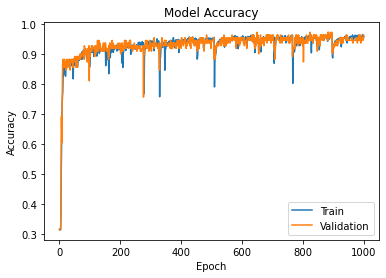

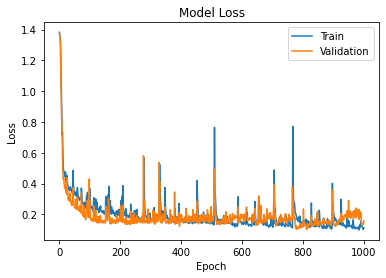

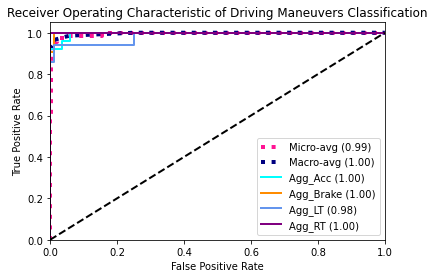

Fold score (accuracy):0.954954954954955
Train Accuracy 96.51046991348267 Train_loss =  9.901279000080713
Test Accuracy =  95.4954981803894 Test loss =  15.857658300313865
Precision: 0.952841
Recall: 0.958571
F1 score: 0.954881
[[23  1  1  0]
 [ 0 22  0  0]
 [ 1  1 32  1]
 [ 0  0  0 29]]
Supervised Fold #7
X_labeled_train =  (1003, 10, 1)
X_labeled_test =  (111, 10, 1)
Y_labeled_train =  (1003, 4)
Y_labeled_test =  (111, 4)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/1000
1003/1003 [==============================] - 2s 2ms/step - loss: 1.3823 - accuracy: 0.2941 - val_loss: 1.3750 - val_accuracy: 0.3153
Epoch 2/1000
1003/1003 [==============================] - 1s 564us/step - loss: 1.3713 - accuracy: 0.3141 - val_loss: 1.3628 - val_accuracy: 0.3153
Epoch 3/1000
1003/1003 [==============================] - 1s 584us/step - loss: 1.3549 - accuracy: 0.3141 - val_loss: 1.3358 - val_accuracy: 0.3153
Epoch 4/1000
1003/1003 [==============================] - 1s 719us

Epoch 53/1000
1003/1003 [==============================] - 1s 591us/step - loss: 0.2752 - accuracy: 0.9063 - val_loss: 0.3769 - val_accuracy: 0.9009
Epoch 54/1000
1003/1003 [==============================] - 1s 599us/step - loss: 0.2685 - accuracy: 0.9063 - val_loss: 0.3964 - val_accuracy: 0.8919
Epoch 55/1000
1003/1003 [==============================] - 1s 618us/step - loss: 0.2694 - accuracy: 0.9003 - val_loss: 0.3628 - val_accuracy: 0.9009
Epoch 56/1000
1003/1003 [==============================] - 1s 735us/step - loss: 0.2576 - accuracy: 0.9103 - val_loss: 0.3714 - val_accuracy: 0.9099
Epoch 57/1000
1003/1003 [==============================] - 1s 864us/step - loss: 0.2536 - accuracy: 0.9153 - val_loss: 0.3752 - val_accuracy: 0.9009
Epoch 58/1000
1003/1003 [==============================] - 1s 722us/step - loss: 0.3040 - accuracy: 0.9023 - val_loss: 0.3701 - val_accuracy: 0.8919
Epoch 59/1000
1003/1003 [==============================] - 1s 650us/step - loss: 0.2610 - accuracy: 0.9013

Epoch 108/1000
1003/1003 [==============================] - 1s 587us/step - loss: 0.2314 - accuracy: 0.9083 - val_loss: 0.3038 - val_accuracy: 0.9009
Epoch 109/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.2189 - accuracy: 0.9182 - val_loss: 0.2988 - val_accuracy: 0.9099
Epoch 110/1000
1003/1003 [==============================] - 1s 585us/step - loss: 0.2020 - accuracy: 0.9222 - val_loss: 0.2934 - val_accuracy: 0.9099
Epoch 111/1000
1003/1003 [==============================] - 1s 608us/step - loss: 0.2296 - accuracy: 0.9133 - val_loss: 0.2899 - val_accuracy: 0.9099
Epoch 112/1000
1003/1003 [==============================] - 1s 584us/step - loss: 0.2213 - accuracy: 0.9153 - val_loss: 0.2696 - val_accuracy: 0.9189
Epoch 113/1000
1003/1003 [==============================] - 1s 678us/step - loss: 0.2126 - accuracy: 0.9202 - val_loss: 0.3057 - val_accuracy: 0.9099
Epoch 114/1000
1003/1003 [==============================] - 1s 592us/step - loss: 0.2075 - accuracy:

1003/1003 [==============================] - 1s 623us/step - loss: 0.1839 - accuracy: 0.9332 - val_loss: 0.2541 - val_accuracy: 0.9189
Epoch 163/1000
1003/1003 [==============================] - 1s 605us/step - loss: 0.1799 - accuracy: 0.9392 - val_loss: 0.2382 - val_accuracy: 0.8919
Epoch 164/1000
1003/1003 [==============================] - 1s 749us/step - loss: 0.1855 - accuracy: 0.9332 - val_loss: 0.2357 - val_accuracy: 0.9189
Epoch 165/1000
1003/1003 [==============================] - 1s 727us/step - loss: 0.1765 - accuracy: 0.9332 - val_loss: 0.2463 - val_accuracy: 0.9189
Epoch 166/1000
1003/1003 [==============================] - 1s 663us/step - loss: 0.1720 - accuracy: 0.9382 - val_loss: 0.2416 - val_accuracy: 0.9279
Epoch 167/1000
1003/1003 [==============================] - 1s 907us/step - loss: 0.1753 - accuracy: 0.9302 - val_loss: 0.2454 - val_accuracy: 0.9009
Epoch 168/1000
1003/1003 [==============================] - 1s 710us/step - loss: 0.1904 - accuracy: 0.9312 - val_l

Epoch 217/1000
1003/1003 [==============================] - 1s 750us/step - loss: 0.2184 - accuracy: 0.9232 - val_loss: 0.2580 - val_accuracy: 0.9189
Epoch 218/1000
1003/1003 [==============================] - 1s 724us/step - loss: 0.1982 - accuracy: 0.9262 - val_loss: 0.2596 - val_accuracy: 0.9099
Epoch 219/1000
1003/1003 [==============================] - 1s 755us/step - loss: 0.1893 - accuracy: 0.9262 - val_loss: 0.2523 - val_accuracy: 0.9279
Epoch 220/1000
1003/1003 [==============================] - 1s 710us/step - loss: 0.1786 - accuracy: 0.9332 - val_loss: 0.2593 - val_accuracy: 0.9279
Epoch 221/1000
1003/1003 [==============================] - 1s 686us/step - loss: 0.1995 - accuracy: 0.9232 - val_loss: 0.3881 - val_accuracy: 0.8829
Epoch 222/1000
1003/1003 [==============================] - 1s 670us/step - loss: 0.2871 - accuracy: 0.8893 - val_loss: 0.3137 - val_accuracy: 0.9099
Epoch 223/1000
1003/1003 [==============================] - 1s 673us/step - loss: 0.2351 - accuracy:

1003/1003 [==============================] - 1s 613us/step - loss: 0.1546 - accuracy: 0.9432 - val_loss: 0.2230 - val_accuracy: 0.9189
Epoch 272/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1594 - accuracy: 0.9422 - val_loss: 0.2231 - val_accuracy: 0.9189
Epoch 273/1000
1003/1003 [==============================] - 1s 620us/step - loss: 0.1776 - accuracy: 0.9342 - val_loss: 0.2334 - val_accuracy: 0.9189
Epoch 274/1000
1003/1003 [==============================] - 1s 619us/step - loss: 0.1861 - accuracy: 0.9292 - val_loss: 0.2205 - val_accuracy: 0.9189
Epoch 275/1000
1003/1003 [==============================] - 1s 628us/step - loss: 0.1774 - accuracy: 0.9342 - val_loss: 0.2339 - val_accuracy: 0.9279
Epoch 276/1000
1003/1003 [==============================] - 1s 621us/step - loss: 0.1767 - accuracy: 0.9332 - val_loss: 0.2295 - val_accuracy: 0.9189
Epoch 277/1000
1003/1003 [==============================] - 1s 677us/step - loss: 0.1752 - accuracy: 0.9332 - val_l

Epoch 326/1000
1003/1003 [==============================] - 1s 732us/step - loss: 0.1458 - accuracy: 0.9501 - val_loss: 0.2456 - val_accuracy: 0.9189
Epoch 327/1000
1003/1003 [==============================] - 1s 722us/step - loss: 0.2028 - accuracy: 0.9252 - val_loss: 0.2462 - val_accuracy: 0.9009
Epoch 328/1000
1003/1003 [==============================] - 1s 740us/step - loss: 0.1991 - accuracy: 0.9272 - val_loss: 0.2437 - val_accuracy: 0.9189
Epoch 329/1000
1003/1003 [==============================] - 1s 724us/step - loss: 0.1678 - accuracy: 0.9452 - val_loss: 0.2854 - val_accuracy: 0.9189
Epoch 330/1000
1003/1003 [==============================] - 1s 714us/step - loss: 0.1754 - accuracy: 0.9392 - val_loss: 0.2427 - val_accuracy: 0.9189
Epoch 331/1000
1003/1003 [==============================] - 1s 656us/step - loss: 0.1569 - accuracy: 0.9462 - val_loss: 0.2374 - val_accuracy: 0.9279
Epoch 332/1000
1003/1003 [==============================] - 1s 753us/step - loss: 0.1515 - accuracy:

1003/1003 [==============================] - 0s 478us/step - loss: 0.1484 - accuracy: 0.9462 - val_loss: 0.1999 - val_accuracy: 0.9279
Epoch 381/1000
1003/1003 [==============================] - 0s 476us/step - loss: 0.1977 - accuracy: 0.9362 - val_loss: 0.2078 - val_accuracy: 0.9099
Epoch 382/1000
1003/1003 [==============================] - 0s 465us/step - loss: 0.1569 - accuracy: 0.9462 - val_loss: 0.2603 - val_accuracy: 0.9279
Epoch 383/1000
1003/1003 [==============================] - 0s 478us/step - loss: 0.1783 - accuracy: 0.9272 - val_loss: 0.2795 - val_accuracy: 0.9189
Epoch 384/1000
1003/1003 [==============================] - 0s 484us/step - loss: 0.1668 - accuracy: 0.9422 - val_loss: 0.2618 - val_accuracy: 0.9279
Epoch 385/1000
1003/1003 [==============================] - 0s 480us/step - loss: 0.1923 - accuracy: 0.9242 - val_loss: 0.2776 - val_accuracy: 0.9189
Epoch 386/1000
1003/1003 [==============================] - 0s 485us/step - loss: 0.1674 - accuracy: 0.9462 - val_l

Epoch 435/1000
1003/1003 [==============================] - 1s 771us/step - loss: 0.1468 - accuracy: 0.9541 - val_loss: 0.2142 - val_accuracy: 0.9189
Epoch 436/1000
1003/1003 [==============================] - 1s 680us/step - loss: 0.1573 - accuracy: 0.9432 - val_loss: 0.2109 - val_accuracy: 0.9279
Epoch 437/1000
1003/1003 [==============================] - 1s 648us/step - loss: 0.1647 - accuracy: 0.9362 - val_loss: 0.2141 - val_accuracy: 0.9099
Epoch 438/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1698 - accuracy: 0.9402 - val_loss: 0.2155 - val_accuracy: 0.9189
Epoch 439/1000
1003/1003 [==============================] - 1s 605us/step - loss: 0.1483 - accuracy: 0.9472 - val_loss: 0.2353 - val_accuracy: 0.9279
Epoch 440/1000
1003/1003 [==============================] - 1s 694us/step - loss: 0.1415 - accuracy: 0.9482 - val_loss: 0.2231 - val_accuracy: 0.9279
Epoch 441/1000
1003/1003 [==============================] - 1s 617us/step - loss: 0.1372 - accuracy:

1003/1003 [==============================] - 1s 595us/step - loss: 0.1705 - accuracy: 0.9342 - val_loss: 0.2340 - val_accuracy: 0.9099
Epoch 490/1000
1003/1003 [==============================] - 1s 599us/step - loss: 0.1619 - accuracy: 0.9392 - val_loss: 0.2260 - val_accuracy: 0.9009
Epoch 491/1000
1003/1003 [==============================] - 1s 616us/step - loss: 0.1580 - accuracy: 0.9422 - val_loss: 0.2121 - val_accuracy: 0.9099
Epoch 492/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1643 - accuracy: 0.9422 - val_loss: 0.2219 - val_accuracy: 0.9189
Epoch 493/1000
1003/1003 [==============================] - 1s 623us/step - loss: 0.1658 - accuracy: 0.9472 - val_loss: 0.2152 - val_accuracy: 0.9189
Epoch 494/1000
1003/1003 [==============================] - 1s 635us/step - loss: 0.1600 - accuracy: 0.9442 - val_loss: 0.2075 - val_accuracy: 0.9189
Epoch 495/1000
1003/1003 [==============================] - 1s 631us/step - loss: 0.1636 - accuracy: 0.9452 - val_l

Epoch 544/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1275 - accuracy: 0.9581 - val_loss: 0.2347 - val_accuracy: 0.9189
Epoch 545/1000
1003/1003 [==============================] - 1s 685us/step - loss: 0.1333 - accuracy: 0.9541 - val_loss: 0.2233 - val_accuracy: 0.9189
Epoch 546/1000
1003/1003 [==============================] - 1s 663us/step - loss: 0.1271 - accuracy: 0.9561 - val_loss: 0.2015 - val_accuracy: 0.9279
Epoch 547/1000
1003/1003 [==============================] - 1s 629us/step - loss: 0.1346 - accuracy: 0.9501 - val_loss: 0.2380 - val_accuracy: 0.9279
Epoch 548/1000
1003/1003 [==============================] - 1s 617us/step - loss: 0.1601 - accuracy: 0.9382 - val_loss: 0.2261 - val_accuracy: 0.9099
Epoch 549/1000
1003/1003 [==============================] - 1s 635us/step - loss: 0.1281 - accuracy: 0.9551 - val_loss: 0.2128 - val_accuracy: 0.9279
Epoch 550/1000
1003/1003 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.95 

1003/1003 [==============================] - 1s 628us/step - loss: 0.1329 - accuracy: 0.9581 - val_loss: 0.2478 - val_accuracy: 0.9279
Epoch 599/1000
1003/1003 [==============================] - 1s 594us/step - loss: 0.3550 - accuracy: 0.8833 - val_loss: 0.3503 - val_accuracy: 0.8649
Epoch 600/1000
1003/1003 [==============================] - 1s 608us/step - loss: 0.2712 - accuracy: 0.9172 - val_loss: 0.2918 - val_accuracy: 0.9189
Epoch 601/1000
1003/1003 [==============================] - 1s 592us/step - loss: 0.2403 - accuracy: 0.9172 - val_loss: 0.2672 - val_accuracy: 0.9099
Epoch 602/1000
1003/1003 [==============================] - 1s 607us/step - loss: 0.2135 - accuracy: 0.9302 - val_loss: 0.2549 - val_accuracy: 0.9099
Epoch 603/1000
1003/1003 [==============================] - 1s 613us/step - loss: 0.2050 - accuracy: 0.9292 - val_loss: 0.2394 - val_accuracy: 0.9279
Epoch 604/1000
1003/1003 [==============================] - 1s 619us/step - loss: 0.1862 - accuracy: 0.9362 - val_l

Epoch 653/1000
1003/1003 [==============================] - 1s 596us/step - loss: 0.1464 - accuracy: 0.9511 - val_loss: 0.2181 - val_accuracy: 0.9369
Epoch 654/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1263 - accuracy: 0.9521 - val_loss: 0.2140 - val_accuracy: 0.9459
Epoch 655/1000
1003/1003 [==============================] - 1s 538us/step - loss: 0.1218 - accuracy: 0.9561 - val_loss: 0.2331 - val_accuracy: 0.9279
Epoch 656/1000
1003/1003 [==============================] - 0s 468us/step - loss: 0.1139 - accuracy: 0.9621 - val_loss: 0.2036 - val_accuracy: 0.9459
Epoch 657/1000
1003/1003 [==============================] - 0s 477us/step - loss: 0.1177 - accuracy: 0.9631 - val_loss: 0.2371 - val_accuracy: 0.9279
Epoch 658/1000
1003/1003 [==============================] - 1s 520us/step - loss: 0.1503 - accuracy: 0.9501 - val_loss: 0.2282 - val_accuracy: 0.9369
Epoch 659/1000
1003/1003 [==============================] - 1s 570us/step - loss: 0.1306 - accuracy:

1003/1003 [==============================] - 1s 678us/step - loss: 0.1075 - accuracy: 0.9621 - val_loss: 0.1984 - val_accuracy: 0.9459
Epoch 708/1000
1003/1003 [==============================] - 1s 853us/step - loss: 0.1043 - accuracy: 0.9671 - val_loss: 0.2015 - val_accuracy: 0.9459
Epoch 709/1000
1003/1003 [==============================] - 1s 861us/step - loss: 0.1093 - accuracy: 0.9631 - val_loss: 0.2300 - val_accuracy: 0.9369
Epoch 710/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.1211 - accuracy: 0.9591 - val_loss: 0.1996 - val_accuracy: 0.9369
Epoch 711/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1302 - accuracy: 0.9501 - val_loss: 0.2226 - val_accuracy: 0.9369
Epoch 712/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.1291 - accuracy: 0.9571 - val_loss: 0.2033 - val_accuracy: 0.9279
Epoch 713/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1197 - accuracy: 0.9571 - val_l

Epoch 762/1000
1003/1003 [==============================] - 1s 678us/step - loss: 0.1366 - accuracy: 0.9551 - val_loss: 0.2216 - val_accuracy: 0.9550
Epoch 763/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1305 - accuracy: 0.9581 - val_loss: 0.2180 - val_accuracy: 0.9369
Epoch 764/1000
1003/1003 [==============================] - 1s 701us/step - loss: 0.1210 - accuracy: 0.9611 - val_loss: 0.2031 - val_accuracy: 0.9550
Epoch 765/1000
1003/1003 [==============================] - 1s 709us/step - loss: 0.1195 - accuracy: 0.9621 - val_loss: 0.2020 - val_accuracy: 0.9459
Epoch 766/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.1105 - accuracy: 0.9631 - val_loss: 0.2070 - val_accuracy: 0.9550
Epoch 767/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1080 - accuracy: 0.9631 - val_loss: 0.2175 - val_accuracy: 0.9369
Epoch 768/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1224 - accuracy:

1003/1003 [==============================] - 1s 701us/step - loss: 0.1053 - accuracy: 0.9661 - val_loss: 0.2164 - val_accuracy: 0.9369
Epoch 817/1000
1003/1003 [==============================] - 1s 709us/step - loss: 0.0989 - accuracy: 0.9661 - val_loss: 0.2086 - val_accuracy: 0.9459
Epoch 818/1000
1003/1003 [==============================] - 1s 678us/step - loss: 0.0978 - accuracy: 0.9701 - val_loss: 0.2074 - val_accuracy: 0.9369
Epoch 819/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1218 - accuracy: 0.9571 - val_loss: 0.1867 - val_accuracy: 0.9550
Epoch 820/1000
1003/1003 [==============================] - 1s 837us/step - loss: 0.1246 - accuracy: 0.9581 - val_loss: 0.2337 - val_accuracy: 0.9279
Epoch 821/1000
1003/1003 [==============================] - 1s 646us/step - loss: 0.1404 - accuracy: 0.9531 - val_loss: 0.1828 - val_accuracy: 0.9550
Epoch 822/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1348 - accuracy: 0.9551 - val_l

Epoch 871/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.1201 - accuracy: 0.9571 - val_loss: 0.2495 - val_accuracy: 0.9279
Epoch 872/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1095 - accuracy: 0.9671 - val_loss: 0.1928 - val_accuracy: 0.9550
Epoch 873/1000
1003/1003 [==============================] - 1s 949us/step - loss: 0.0931 - accuracy: 0.9681 - val_loss: 0.1968 - val_accuracy: 0.9550
Epoch 874/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.0941 - accuracy: 0.9711 - val_loss: 0.1823 - val_accuracy: 0.9550
Epoch 875/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.0993 - accuracy: 0.9671 - val_loss: 0.1865 - val_accuracy: 0.9550
Epoch 876/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1021 - accuracy: 0.9671 - val_loss: 0.2098 - val_accuracy: 0.9369
Epoch 877/1000
1003/1003 [==============================] - 1s 829us/step - loss: 0.0951 - accuracy:

1003/1003 [==============================] - 1s 542us/step - loss: 0.0971 - accuracy: 0.9691 - val_loss: 0.1962 - val_accuracy: 0.9369
Epoch 926/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.0897 - accuracy: 0.9721 - val_loss: 0.1932 - val_accuracy: 0.9550
Epoch 927/1000
1003/1003 [==============================] - 1s 542us/step - loss: 0.0927 - accuracy: 0.9681 - val_loss: 0.2028 - val_accuracy: 0.9369
Epoch 928/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.0911 - accuracy: 0.9701 - val_loss: 0.2114 - val_accuracy: 0.9369
Epoch 929/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.0872 - accuracy: 0.9721 - val_loss: 0.2162 - val_accuracy: 0.9550
Epoch 930/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.0845 - accuracy: 0.9721 - val_loss: 0.2246 - val_accuracy: 0.9369
Epoch 931/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.0918 - accuracy: 0.9681 - val_l

Epoch 980/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.1013 - accuracy: 0.9691 - val_loss: 0.1945 - val_accuracy: 0.9459
Epoch 981/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.0995 - accuracy: 0.9681 - val_loss: 0.1905 - val_accuracy: 0.9459
Epoch 982/1000
1003/1003 [==============================] - 1s 542us/step - loss: 0.1038 - accuracy: 0.9651 - val_loss: 0.2054 - val_accuracy: 0.9369
Epoch 983/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.1064 - accuracy: 0.9651 - val_loss: 0.2071 - val_accuracy: 0.9369
Epoch 984/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.1545 - accuracy: 0.9422 - val_loss: 0.2119 - val_accuracy: 0.9369
Epoch 985/1000
1003/1003 [==============================] - 1s 542us/step - loss: 0.1184 - accuracy: 0.9531 - val_loss: 0.2788 - val_accuracy: 0.9009
Epoch 986/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.1272 - accuracy:

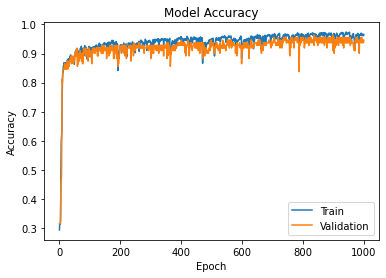

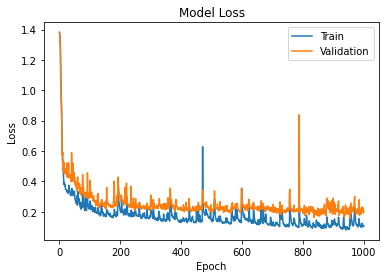

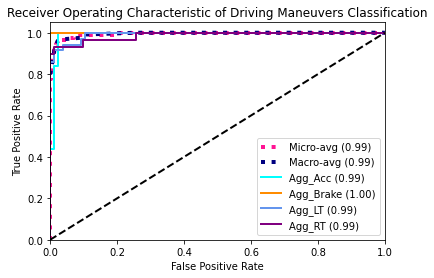

Fold score (accuracy):0.9459459459459459
Train Accuracy 97.00897336006165 Train_loss =  8.697898708217046
Test Accuracy =  94.59459185600281 Test loss =  19.312839035515314
Precision: 0.945083
Recall: 0.951330
F1 score: 0.947791
[[24  1  0  0]
 [ 0 22  0  0]
 [ 1  0 32  2]
 [ 1  0  1 27]]
Supervised Fold #8
X_labeled_train =  (1003, 10, 1)
X_labeled_test =  (111, 10, 1)
Y_labeled_train =  (1003, 4)
Y_labeled_test =  (111, 4)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/1000
1003/1003 [==============================] - 2s 2ms/step - loss: 1.3801 - accuracy: 0.3071 - val_loss: 1.3688 - val_accuracy: 0.3153
Epoch 2/1000
1003/1003 [==============================] - 1s 542us/step - loss: 1.3645 - accuracy: 0.3141 - val_loss: 1.3568 - val_accuracy: 0.3153
Epoch 3/1000
1003/1003 [==============================] - 1s 781us/step - loss: 1.3586 - accuracy: 0.3141 - val_loss: 1.3485 - val_accuracy: 0.3153
Epoch 4/1000
1003/1003 [==============================] - 1s 558

Epoch 53/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.2720 - accuracy: 0.9083 - val_loss: 0.2794 - val_accuracy: 0.9009
Epoch 54/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.2964 - accuracy: 0.8953 - val_loss: 0.2996 - val_accuracy: 0.9189
Epoch 55/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.3013 - accuracy: 0.8893 - val_loss: 0.2990 - val_accuracy: 0.8739
Epoch 56/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.3063 - accuracy: 0.8694 - val_loss: 0.2973 - val_accuracy: 0.8559
Epoch 57/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.2883 - accuracy: 0.8724 - val_loss: 0.2850 - val_accuracy: 0.8739
Epoch 58/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.2795 - accuracy: 0.8933 - val_loss: 0.2916 - val_accuracy: 0.8829
Epoch 59/1000
1003/1003 [==============================] - 1s 542us/step - loss: 0.2733 - accuracy: 0.8943

1003/1003 [==============================] - 1s 550us/step - loss: 0.2924 - accuracy: 0.8804 - val_loss: 0.3227 - val_accuracy: 0.8468
Epoch 108/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.2936 - accuracy: 0.8774 - val_loss: 0.3123 - val_accuracy: 0.8649
Epoch 109/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.2785 - accuracy: 0.8883 - val_loss: 0.3092 - val_accuracy: 0.8649
Epoch 110/1000
1003/1003 [==============================] - 1s 534us/step - loss: 0.2810 - accuracy: 0.8953 - val_loss: 0.2988 - val_accuracy: 0.8829
Epoch 111/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.2724 - accuracy: 0.8973 - val_loss: 0.2930 - val_accuracy: 0.8649
Epoch 112/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.2707 - accuracy: 0.8883 - val_loss: 0.2868 - val_accuracy: 0.8739
Epoch 113/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.2749 - accuracy: 0.8863 - val_l

Epoch 162/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.2197 - accuracy: 0.9212 - val_loss: 0.2143 - val_accuracy: 0.9369
Epoch 163/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.2288 - accuracy: 0.9143 - val_loss: 0.2353 - val_accuracy: 0.9279
Epoch 164/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.2172 - accuracy: 0.9252 - val_loss: 0.2459 - val_accuracy: 0.9189
Epoch 165/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.2177 - accuracy: 0.9232 - val_loss: 0.2265 - val_accuracy: 0.9279
Epoch 166/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.2053 - accuracy: 0.9322 - val_loss: 0.2112 - val_accuracy: 0.9279
Epoch 167/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.2006 - accuracy: 0.9252 - val_loss: 0.2151 - val_accuracy: 0.9279
Epoch 168/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.2044 - accuracy:

1003/1003 [==============================] - 1s 574us/step - loss: 0.2181 - accuracy: 0.9202 - val_loss: 0.2362 - val_accuracy: 0.9279
Epoch 217/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.2231 - accuracy: 0.9172 - val_loss: 0.2335 - val_accuracy: 0.9099
Epoch 218/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.2577 - accuracy: 0.9103 - val_loss: 0.2630 - val_accuracy: 0.9099
Epoch 219/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2389 - accuracy: 0.9003 - val_loss: 0.2343 - val_accuracy: 0.8919
Epoch 220/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2167 - accuracy: 0.9212 - val_loss: 0.2317 - val_accuracy: 0.9189
Epoch 221/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2207 - accuracy: 0.9212 - val_loss: 0.2355 - val_accuracy: 0.9099
Epoch 222/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.2358 - accuracy: 0.9163 - val_l

Epoch 271/1000
1003/1003 [==============================] - 1s 773us/step - loss: 0.2404 - accuracy: 0.9013 - val_loss: 0.2476 - val_accuracy: 0.9279
Epoch 272/1000
1003/1003 [==============================] - 1s 657us/step - loss: 0.2154 - accuracy: 0.9222 - val_loss: 0.2299 - val_accuracy: 0.9279
Epoch 273/1000
1003/1003 [==============================] - 1s 672us/step - loss: 0.2078 - accuracy: 0.9242 - val_loss: 0.2182 - val_accuracy: 0.9279
Epoch 274/1000
1003/1003 [==============================] - 1s 740us/step - loss: 0.1967 - accuracy: 0.9212 - val_loss: 0.2167 - val_accuracy: 0.9189
Epoch 275/1000
1003/1003 [==============================] - 1s 884us/step - loss: 0.2174 - accuracy: 0.9163 - val_loss: 0.2375 - val_accuracy: 0.9279
Epoch 276/1000
1003/1003 [==============================] - 1s 1ms/step - loss: 0.2026 - accuracy: 0.9222 - val_loss: 0.2277 - val_accuracy: 0.9279
Epoch 277/1000
1003/1003 [==============================] - 1s 659us/step - loss: 0.1908 - accuracy: 0

1003/1003 [==============================] - 1s 622us/step - loss: 0.2014 - accuracy: 0.9322 - val_loss: 0.2189 - val_accuracy: 0.9279
Epoch 326/1000
1003/1003 [==============================] - 1s 581us/step - loss: 0.2154 - accuracy: 0.9332 - val_loss: 0.2721 - val_accuracy: 0.9369
Epoch 327/1000
1003/1003 [==============================] - 1s 593us/step - loss: 0.2059 - accuracy: 0.9342 - val_loss: 0.2116 - val_accuracy: 0.9369
Epoch 328/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.1903 - accuracy: 0.9232 - val_loss: 0.2068 - val_accuracy: 0.9369
Epoch 329/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.1845 - accuracy: 0.9362 - val_loss: 0.2042 - val_accuracy: 0.9279s: 0.1749 - accuracy: 0.
Epoch 330/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1859 - accuracy: 0.9292 - val_loss: 0.1920 - val_accuracy: 0.9189
Epoch 331/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1948 - 

1003/1003 [==============================] - 1s 590us/step - loss: 0.1761 - accuracy: 0.9312 - val_loss: 0.2017 - val_accuracy: 0.9279
Epoch 380/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1658 - accuracy: 0.9352 - val_loss: 0.2073 - val_accuracy: 0.9099
Epoch 381/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1669 - accuracy: 0.9342 - val_loss: 0.2077 - val_accuracy: 0.9279
Epoch 382/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1752 - accuracy: 0.9352 - val_loss: 0.2066 - val_accuracy: 0.9189
Epoch 383/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1677 - accuracy: 0.9322 - val_loss: 0.2022 - val_accuracy: 0.9189
Epoch 384/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1718 - accuracy: 0.9352 - val_loss: 0.2064 - val_accuracy: 0.9189
Epoch 385/1000
1003/1003 [==============================] - 1s 605us/step - loss: 0.1654 - accuracy: 0.9312 - val_l

Epoch 434/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1772 - accuracy: 0.9382 - val_loss: 0.2045 - val_accuracy: 0.9459
Epoch 435/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1764 - accuracy: 0.9362 - val_loss: 0.2054 - val_accuracy: 0.9369
Epoch 436/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1751 - accuracy: 0.9312 - val_loss: 0.1999 - val_accuracy: 0.9279
Epoch 437/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1678 - accuracy: 0.9432 - val_loss: 0.1947 - val_accuracy: 0.9459
Epoch 438/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1903 - accuracy: 0.9312 - val_loss: 0.2247 - val_accuracy: 0.9009
Epoch 439/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1824 - accuracy: 0.9372 - val_loss: 0.2065 - val_accuracy: 0.9189
Epoch 440/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1847 - accuracy:

1003/1003 [==============================] - 1s 670us/step - loss: 0.1746 - accuracy: 0.9402 - val_loss: 0.2011 - val_accuracy: 0.9279
Epoch 489/1000
1003/1003 [==============================] - 1s 685us/step - loss: 0.1657 - accuracy: 0.9422 - val_loss: 0.2049 - val_accuracy: 0.9099
Epoch 490/1000
1003/1003 [==============================] - 1s 696us/step - loss: 0.1548 - accuracy: 0.9402 - val_loss: 0.2213 - val_accuracy: 0.9099
Epoch 491/1000
1003/1003 [==============================] - 1s 646us/step - loss: 0.1553 - accuracy: 0.9472 - val_loss: 0.2172 - val_accuracy: 0.8919
Epoch 492/1000
1003/1003 [==============================] - 1s 605us/step - loss: 0.1784 - accuracy: 0.9332 - val_loss: 0.2047 - val_accuracy: 0.9279
Epoch 493/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1723 - accuracy: 0.9332 - val_loss: 0.2071 - val_accuracy: 0.9189
Epoch 494/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1600 - accuracy: 0.9422 - val_l

Epoch 543/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1688 - accuracy: 0.9372 - val_loss: 0.2030 - val_accuracy: 0.9099
Epoch 544/1000
1003/1003 [==============================] - 1s 569us/step - loss: 0.1510 - accuracy: 0.9511 - val_loss: 0.2203 - val_accuracy: 0.8919
Epoch 545/1000
1003/1003 [==============================] - 1s 572us/step - loss: 0.1478 - accuracy: 0.9521 - val_loss: 0.2050 - val_accuracy: 0.9189
Epoch 546/1000
1003/1003 [==============================] - 1s 583us/step - loss: 0.1527 - accuracy: 0.9521 - val_loss: 0.2084 - val_accuracy: 0.9099
Epoch 547/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1439 - accuracy: 0.9531 - val_loss: 0.2098 - val_accuracy: 0.9099
Epoch 548/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1450 - accuracy: 0.9501 - val_loss: 0.2096 - val_accuracy: 0.9099
Epoch 549/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1475 - accuracy:

1003/1003 [==============================] - 1s 590us/step - loss: 0.1943 - accuracy: 0.9302 - val_loss: 0.1980 - val_accuracy: 0.9009
Epoch 598/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.2689 - accuracy: 0.9232 - val_loss: 0.4522 - val_accuracy: 0.8378
Epoch 599/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.3717 - accuracy: 0.8704 - val_loss: 0.3500 - val_accuracy: 0.8829
Epoch 600/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.3043 - accuracy: 0.8903 - val_loss: 0.2642 - val_accuracy: 0.9009
Epoch 601/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.2066 - accuracy: 0.9192 - val_loss: 0.2343 - val_accuracy: 0.9009
Epoch 602/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1936 - accuracy: 0.9262 - val_loss: 0.2298 - val_accuracy: 0.9099
Epoch 603/1000
1003/1003 [==============================] - 1s 604us/step - loss: 0.1791 - accuracy: 0.9332 - val_l

Epoch 652/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1452 - accuracy: 0.9521 - val_loss: 0.2254 - val_accuracy: 0.9009
Epoch 653/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1390 - accuracy: 0.9521 - val_loss: 0.2500 - val_accuracy: 0.8739
Epoch 654/1000
1003/1003 [==============================] - 1s 586us/step - loss: 0.1432 - accuracy: 0.9511 - val_loss: 0.2109 - val_accuracy: 0.9279
Epoch 655/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1383 - accuracy: 0.9472 - val_loss: 0.2278 - val_accuracy: 0.9189
Epoch 656/1000
1003/1003 [==============================] - 1s 581us/step - loss: 0.1307 - accuracy: 0.9531 - val_loss: 0.2432 - val_accuracy: 0.9009
Epoch 657/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1352 - accuracy: 0.9501 - val_loss: 0.2218 - val_accuracy: 0.9189
Epoch 658/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1340 - accuracy:

1003/1003 [==============================] - 1s 614us/step - loss: 0.1304 - accuracy: 0.9561 - val_loss: 0.2626 - val_accuracy: 0.8919
Epoch 707/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1370 - accuracy: 0.9492 - val_loss: 0.2363 - val_accuracy: 0.9189
Epoch 708/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1554 - accuracy: 0.9472 - val_loss: 0.2722 - val_accuracy: 0.8919
Epoch 709/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1603 - accuracy: 0.9442 - val_loss: 0.2330 - val_accuracy: 0.8919
Epoch 710/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1456 - accuracy: 0.9501 - val_loss: 0.2313 - val_accuracy: 0.9009
Epoch 711/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1329 - accuracy: 0.9551 - val_loss: 0.2181 - val_accuracy: 0.9189
Epoch 712/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1284 - accuracy: 0.9581 - val_l

Epoch 761/1000
1003/1003 [==============================] - 1s 820us/step - loss: 0.1964 - accuracy: 0.9222 - val_loss: 0.2461 - val_accuracy: 0.9189
Epoch 762/1000
1003/1003 [==============================] - 1s 773us/step - loss: 0.2346 - accuracy: 0.9182 - val_loss: 0.4592 - val_accuracy: 0.8649
Epoch 763/1000
1003/1003 [==============================] - 1s 805us/step - loss: 0.4940 - accuracy: 0.9053 - val_loss: 0.3479 - val_accuracy: 0.8739
Epoch 764/1000
1003/1003 [==============================] - 1s 741us/step - loss: 0.2313 - accuracy: 0.9182 - val_loss: 0.2523 - val_accuracy: 0.9279
Epoch 765/1000
1003/1003 [==============================] - 1s 829us/step - loss: 0.1841 - accuracy: 0.9372 - val_loss: 0.2153 - val_accuracy: 0.9099
Epoch 766/1000
1003/1003 [==============================] - 1s 909us/step - loss: 0.1762 - accuracy: 0.9372 - val_loss: 0.2329 - val_accuracy: 0.9279
Epoch 767/1000
1003/1003 [==============================] - 1s 817us/step - loss: 0.1611 - accuracy:

1003/1003 [==============================] - 1s 598us/step - loss: 0.2172 - accuracy: 0.9133 - val_loss: 0.2280 - val_accuracy: 0.9279
Epoch 816/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.2169 - accuracy: 0.9272 - val_loss: 0.2253 - val_accuracy: 0.9369
Epoch 817/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1961 - accuracy: 0.9342 - val_loss: 0.2208 - val_accuracy: 0.9189
Epoch 818/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1907 - accuracy: 0.9312 - val_loss: 0.2076 - val_accuracy: 0.9189
Epoch 819/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1987 - accuracy: 0.9302 - val_loss: 0.2129 - val_accuracy: 0.9189
Epoch 820/1000
1003/1003 [==============================] - 1s 579us/step - loss: 0.1925 - accuracy: 0.9332 - val_loss: 0.2061 - val_accuracy: 0.9369
Epoch 821/1000
1003/1003 [==============================] - 1s 589us/step - loss: 0.1868 - accuracy: 0.9342 - val_l

Epoch 870/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1255 - accuracy: 0.9531 - val_loss: 0.2485 - val_accuracy: 0.9009
Epoch 871/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1308 - accuracy: 0.9611 - val_loss: 0.2291 - val_accuracy: 0.9189
Epoch 872/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1331 - accuracy: 0.9531 - val_loss: 0.2306 - val_accuracy: 0.9009
Epoch 873/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1292 - accuracy: 0.9521 - val_loss: 0.2038 - val_accuracy: 0.9279
Epoch 874/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1333 - accuracy: 0.9531 - val_loss: 0.2277 - val_accuracy: 0.9099
Epoch 875/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1201 - accuracy: 0.9611 - val_loss: 0.2231 - val_accuracy: 0.9189
Epoch 876/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1241 - accuracy:

1003/1003 [==============================] - 1s 598us/step - loss: 0.1501 - accuracy: 0.9511 - val_loss: 0.2478 - val_accuracy: 0.9099
Epoch 925/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1346 - accuracy: 0.9571 - val_loss: 0.2263 - val_accuracy: 0.9189
Epoch 926/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1308 - accuracy: 0.9591 - val_loss: 0.2217 - val_accuracy: 0.9189
Epoch 927/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1215 - accuracy: 0.9661 - val_loss: 0.2507 - val_accuracy: 0.9009
Epoch 928/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1200 - accuracy: 0.9641 - val_loss: 0.2364 - val_accuracy: 0.9189
Epoch 929/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1247 - accuracy: 0.9631 - val_loss: 0.2369 - val_accuracy: 0.9009
Epoch 930/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1173 - accuracy: 0.9591 - val_l

Epoch 979/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1310 - accuracy: 0.9561 - val_loss: 0.2574 - val_accuracy: 0.9009
Epoch 980/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1158 - accuracy: 0.9611 - val_loss: 0.2373 - val_accuracy: 0.9099
Epoch 981/1000
1003/1003 [==============================] - 1s 563us/step - loss: 0.1617 - accuracy: 0.9392 - val_loss: 0.2568 - val_accuracy: 0.9099
Epoch 982/1000
1003/1003 [==============================] - 1s 573us/step - loss: 0.1487 - accuracy: 0.9492 - val_loss: 0.2556 - val_accuracy: 0.8919
Epoch 983/1000
1003/1003 [==============================] - 1s 587us/step - loss: 0.1267 - accuracy: 0.9531 - val_loss: 0.2522 - val_accuracy: 0.9099
Epoch 984/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1209 - accuracy: 0.9601 - val_loss: 0.2662 - val_accuracy: 0.9009
Epoch 985/1000
1003/1003 [==============================] - 1s 591us/step - loss: 0.1074 - accuracy:

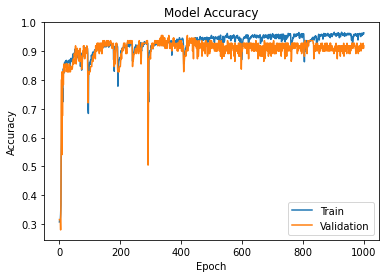

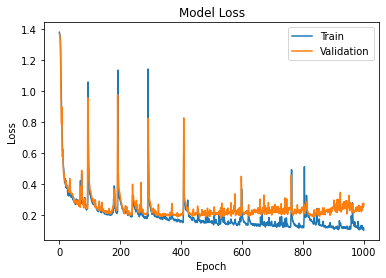

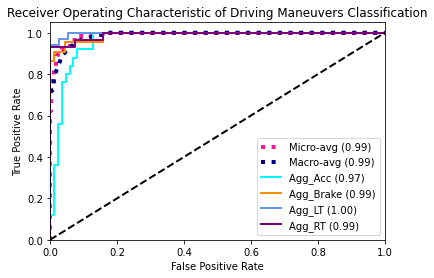

Fold score (accuracy):0.918918918918919
Train Accuracy 96.21136784553528 Train_loss =  9.997675668147364
Test Accuracy =  91.89189076423645 Test loss =  26.086850817470502
Precision: 0.913820
Recall: 0.915746
F1 score: 0.913488
[[22  3  0  0]
 [ 2 20  0  0]
 [ 2  0 33  0]
 [ 2  0  0 27]]
Supervised Fold #9
X_labeled_train =  (1003, 10, 1)
X_labeled_test =  (111, 10, 1)
Y_labeled_train =  (1003, 4)
Y_labeled_test =  (111, 4)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/1000
1003/1003 [==============================] - 2s 2ms/step - loss: 1.3807 - accuracy: 0.3091 - val_loss: 1.3706 - val_accuracy: 0.3153
Epoch 2/1000
1003/1003 [==============================] - 1s 502us/step - loss: 1.3658 - accuracy: 0.3141 - val_loss: 1.3575 - val_accuracy: 0.3153
Epoch 3/1000
1003/1003 [==============================] - 1s 502us/step - loss: 1.3541 - accuracy: 0.3141 - val_loss: 1.3408 - val_accuracy: 0.3153
Epoch 4/1000
1003/1003 [==============================] - 0s 494u

Epoch 53/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.3551 - accuracy: 0.8704 - val_loss: 0.3607 - val_accuracy: 0.8649
Epoch 54/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.3290 - accuracy: 0.8754 - val_loss: 0.3405 - val_accuracy: 0.8919
Epoch 55/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.3134 - accuracy: 0.8893 - val_loss: 0.3337 - val_accuracy: 0.8829
Epoch 56/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.3113 - accuracy: 0.8814 - val_loss: 0.3336 - val_accuracy: 0.8919
Epoch 57/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.3011 - accuracy: 0.8933 - val_loss: 0.3375 - val_accuracy: 0.8919
Epoch 58/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.2899 - accuracy: 0.8963 - val_loss: 0.3339 - val_accuracy: 0.8829
Epoch 59/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2998 - accuracy: 0.8853

Epoch 108/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.2382 - accuracy: 0.9182 - val_loss: 0.2984 - val_accuracy: 0.8739
Epoch 109/1000
1003/1003 [==============================] - 1s 534us/step - loss: 0.2234 - accuracy: 0.9182 - val_loss: 0.3088 - val_accuracy: 0.8919
Epoch 110/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.2107 - accuracy: 0.9192 - val_loss: 0.3122 - val_accuracy: 0.8919
Epoch 111/1000
1003/1003 [==============================] - 1s 805us/step - loss: 0.2132 - accuracy: 0.9222 - val_loss: 0.3142 - val_accuracy: 0.9009
Epoch 112/1000
1003/1003 [==============================] - 1s 773us/step - loss: 0.2191 - accuracy: 0.9212 - val_loss: 0.3091 - val_accuracy: 0.8739
Epoch 113/1000
1003/1003 [==============================] - 1s 956us/step - loss: 0.2485 - accuracy: 0.9083 - val_loss: 0.3200 - val_accuracy: 0.8919
Epoch 114/1000
1003/1003 [==============================] - 1s 845us/step - loss: 0.2260 - accuracy:

1003/1003 [==============================] - 1s 502us/step - loss: 0.3543 - accuracy: 0.8794 - val_loss: 0.3650 - val_accuracy: 0.8829
Epoch 163/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2599 - accuracy: 0.9063 - val_loss: 0.3229 - val_accuracy: 0.8829
Epoch 164/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.2346 - accuracy: 0.9153 - val_loss: 0.3251 - val_accuracy: 0.8919
Epoch 165/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.2245 - accuracy: 0.9192 - val_loss: 0.3199 - val_accuracy: 0.8829
Epoch 166/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2196 - accuracy: 0.9093 - val_loss: 0.3134 - val_accuracy: 0.9009
Epoch 167/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.2119 - accuracy: 0.9232 - val_loss: 0.3104 - val_accuracy: 0.9009
Epoch 168/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2051 - accuracy: 0.9252 - val_l

Epoch 217/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.2315 - accuracy: 0.9232 - val_loss: 0.4036 - val_accuracy: 0.8018
Epoch 218/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.2433 - accuracy: 0.9123 - val_loss: 0.3411 - val_accuracy: 0.9009
Epoch 219/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.2122 - accuracy: 0.9272 - val_loss: 0.3068 - val_accuracy: 0.8739
Epoch 220/1000
1003/1003 [==============================] - 1s 542us/step - loss: 0.1888 - accuracy: 0.9252 - val_loss: 0.3048 - val_accuracy: 0.9099
Epoch 221/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.2094 - accuracy: 0.9302 - val_loss: 0.3096 - val_accuracy: 0.8829
Epoch 222/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.1801 - accuracy: 0.9272 - val_loss: 0.3187 - val_accuracy: 0.9009
Epoch 223/1000
1003/1003 [==============================] - 1s 518us/step - loss: 0.1873 - accuracy:

1003/1003 [==============================] - 1s 510us/step - loss: 0.1896 - accuracy: 0.9252 - val_loss: 0.3200 - val_accuracy: 0.9099
Epoch 272/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1901 - accuracy: 0.9302 - val_loss: 0.3186 - val_accuracy: 0.8739
Epoch 273/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.1833 - accuracy: 0.9292 - val_loss: 0.3195 - val_accuracy: 0.9099
Epoch 274/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1638 - accuracy: 0.9372 - val_loss: 0.3100 - val_accuracy: 0.8829
Epoch 275/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1715 - accuracy: 0.9292 - val_loss: 0.3639 - val_accuracy: 0.8919
Epoch 276/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1735 - accuracy: 0.9332 - val_loss: 0.3262 - val_accuracy: 0.8739
Epoch 277/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1703 - accuracy: 0.9322 - val_l

Epoch 326/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2451 - accuracy: 0.8933 - val_loss: 0.2846 - val_accuracy: 0.9009
Epoch 327/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2194 - accuracy: 0.9023 - val_loss: 0.2890 - val_accuracy: 0.8829
Epoch 328/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1965 - accuracy: 0.9172 - val_loss: 0.2857 - val_accuracy: 0.8829
Epoch 329/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1821 - accuracy: 0.9282 - val_loss: 0.2749 - val_accuracy: 0.8739
Epoch 330/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1790 - accuracy: 0.9302 - val_loss: 0.2876 - val_accuracy: 0.8919
Epoch 331/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1807 - accuracy: 0.9192 - val_loss: 0.2905 - val_accuracy: 0.8919
Epoch 332/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1788 - accuracy:

1003/1003 [==============================] - 1s 502us/step - loss: 0.2374 - accuracy: 0.9172 - val_loss: 0.3098 - val_accuracy: 0.9279
Epoch 381/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1932 - accuracy: 0.9342 - val_loss: 0.2961 - val_accuracy: 0.9189
Epoch 382/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1870 - accuracy: 0.9382 - val_loss: 0.3075 - val_accuracy: 0.9279
Epoch 383/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1826 - accuracy: 0.9362 - val_loss: 0.2997 - val_accuracy: 0.9099
Epoch 384/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.1698 - accuracy: 0.9352 - val_loss: 0.3021 - val_accuracy: 0.9279
Epoch 385/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1621 - accuracy: 0.9422 - val_loss: 0.3050 - val_accuracy: 0.9009
Epoch 386/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1618 - accuracy: 0.9362 - val_l

Epoch 435/1000
1003/1003 [==============================] - 1s 518us/step - loss: 0.3630 - accuracy: 0.9182 - val_loss: 0.4243 - val_accuracy: 0.8829
Epoch 436/1000
1003/1003 [==============================] - 1s 518us/step - loss: 0.2870 - accuracy: 0.9023 - val_loss: 0.3249 - val_accuracy: 0.8739
Epoch 437/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2299 - accuracy: 0.9202 - val_loss: 0.3102 - val_accuracy: 0.9009
Epoch 438/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2113 - accuracy: 0.9292 - val_loss: 0.3132 - val_accuracy: 0.9099
Epoch 439/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2087 - accuracy: 0.9172 - val_loss: 0.3403 - val_accuracy: 0.8288
Epoch 440/1000
1003/1003 [==============================] - 1s 534us/step - loss: 0.4201 - accuracy: 0.7966 - val_loss: 0.3867 - val_accuracy: 0.8829
Epoch 441/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.3006 - accuracy:

1003/1003 [==============================] - 0s 494us/step - loss: 0.2852 - accuracy: 0.8893 - val_loss: 0.3068 - val_accuracy: 0.8739
Epoch 490/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.2434 - accuracy: 0.9093 - val_loss: 0.3181 - val_accuracy: 0.8919
Epoch 491/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2235 - accuracy: 0.9063 - val_loss: 0.3073 - val_accuracy: 0.8919
Epoch 492/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.2278 - accuracy: 0.9033 - val_loss: 0.2971 - val_accuracy: 0.8649
Epoch 493/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.2114 - accuracy: 0.9143 - val_loss: 0.2866 - val_accuracy: 0.8829
Epoch 494/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.2245 - accuracy: 0.9133 - val_loss: 0.2873 - val_accuracy: 0.8739
Epoch 495/1000
1003/1003 [==============================] - 1s 542us/step - loss: 0.2045 - accuracy: 0.9322 - val_l

Epoch 544/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.1477 - accuracy: 0.9452 - val_loss: 0.3433 - val_accuracy: 0.9189
Epoch 545/1000
1003/1003 [==============================] - 1s 749us/step - loss: 0.1484 - accuracy: 0.9442 - val_loss: 0.3251 - val_accuracy: 0.9189
Epoch 546/1000
1003/1003 [==============================] - 1s 781us/step - loss: 0.1578 - accuracy: 0.9372 - val_loss: 0.3125 - val_accuracy: 0.9279
Epoch 547/1000
1003/1003 [==============================] - 1s 853us/step - loss: 0.1611 - accuracy: 0.9402 - val_loss: 0.3174 - val_accuracy: 0.9279
Epoch 548/1000
1003/1003 [==============================] - 1s 789us/step - loss: 0.1488 - accuracy: 0.9521 - val_loss: 0.3091 - val_accuracy: 0.9459
Epoch 549/1000
1003/1003 [==============================] - 1s 805us/step - loss: 0.1456 - accuracy: 0.9501 - val_loss: 0.3404 - val_accuracy: 0.9279
Epoch 550/1000
1003/1003 [==============================] - 1s 829us/step - loss: 0.2697 - accuracy:

1003/1003 [==============================] - 1s 741us/step - loss: 0.1440 - accuracy: 0.9382 - val_loss: 0.3512 - val_accuracy: 0.9279
Epoch 599/1000
1003/1003 [==============================] - 1s 821us/step - loss: 0.1356 - accuracy: 0.9501 - val_loss: 0.3505 - val_accuracy: 0.9459
Epoch 600/1000
1003/1003 [==============================] - 1s 877us/step - loss: 0.1361 - accuracy: 0.9482 - val_loss: 0.3476 - val_accuracy: 0.9279
Epoch 601/1000
1003/1003 [==============================] - 1s 864us/step - loss: 0.1444 - accuracy: 0.9432 - val_loss: 0.3408 - val_accuracy: 0.9369
Epoch 602/1000
1003/1003 [==============================] - 1s 701us/step - loss: 0.1574 - accuracy: 0.9402 - val_loss: 0.3234 - val_accuracy: 0.9099
Epoch 603/1000
1003/1003 [==============================] - 1s 756us/step - loss: 0.1411 - accuracy: 0.9462 - val_loss: 0.3466 - val_accuracy: 0.9459
Epoch 604/1000
1003/1003 [==============================] - 1s 797us/step - loss: 0.1493 - accuracy: 0.9462 - val_l

Epoch 653/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1852 - accuracy: 0.9202 - val_loss: 0.2834 - val_accuracy: 0.8829
Epoch 654/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1708 - accuracy: 0.9272 - val_loss: 0.2925 - val_accuracy: 0.9009
Epoch 655/1000
1003/1003 [==============================] - 1s 670us/step - loss: 0.1594 - accuracy: 0.9402 - val_loss: 0.2932 - val_accuracy: 0.9009
Epoch 656/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1519 - accuracy: 0.9392 - val_loss: 0.2952 - val_accuracy: 0.9099
Epoch 657/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1456 - accuracy: 0.9392 - val_loss: 0.2994 - val_accuracy: 0.9099
Epoch 658/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1435 - accuracy: 0.9472 - val_loss: 0.3145 - val_accuracy: 0.9369
Epoch 659/1000
1003/1003 [==============================] - 1s 765us/step - loss: 0.1457 - accuracy:

1003/1003 [==============================] - 1s 582us/step - loss: 0.1343 - accuracy: 0.9521 - val_loss: 0.3569 - val_accuracy: 0.9369
Epoch 708/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.1355 - accuracy: 0.9501 - val_loss: 0.3604 - val_accuracy: 0.9369
Epoch 709/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1325 - accuracy: 0.9531 - val_loss: 0.3663 - val_accuracy: 0.9369
Epoch 710/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1305 - accuracy: 0.9472 - val_loss: 0.3855 - val_accuracy: 0.9189
Epoch 711/1000
1003/1003 [==============================] - 1s 757us/step - loss: 0.1326 - accuracy: 0.9492 - val_loss: 0.3603 - val_accuracy: 0.9369
Epoch 712/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1275 - accuracy: 0.9511 - val_loss: 0.3642 - val_accuracy: 0.9369
Epoch 713/1000
1003/1003 [==============================] - 1s 670us/step - loss: 0.1266 - accuracy: 0.9531 - val_l

Epoch 762/1000
1003/1003 [==============================] - 0s 498us/step - loss: 0.1427 - accuracy: 0.9551 - val_loss: 0.3512 - val_accuracy: 0.9369
Epoch 763/1000
1003/1003 [==============================] - 0s 477us/step - loss: 0.1618 - accuracy: 0.9551 - val_loss: 0.3916 - val_accuracy: 0.9369
Epoch 764/1000
1003/1003 [==============================] - 1s 500us/step - loss: 0.1542 - accuracy: 0.9472 - val_loss: 0.3367 - val_accuracy: 0.9189
Epoch 765/1000
1003/1003 [==============================] - 0s 495us/step - loss: 0.1485 - accuracy: 0.9561 - val_loss: 0.3520 - val_accuracy: 0.9099
Epoch 766/1000
1003/1003 [==============================] - 0s 483us/step - loss: 0.1973 - accuracy: 0.9282 - val_loss: 0.4058 - val_accuracy: 0.9099
Epoch 767/1000
1003/1003 [==============================] - 0s 496us/step - loss: 0.1768 - accuracy: 0.9362 - val_loss: 0.3293 - val_accuracy: 0.9099
Epoch 768/1000
1003/1003 [==============================] - 0s 482us/step - loss: 0.1476 - accuracy:

1003/1003 [==============================] - 1s 582us/step - loss: 0.1570 - accuracy: 0.9462 - val_loss: 0.3535 - val_accuracy: 0.9369
Epoch 817/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1436 - accuracy: 0.9492 - val_loss: 0.3401 - val_accuracy: 0.9279
Epoch 818/1000
1003/1003 [==============================] - 1s 693us/step - loss: 0.1410 - accuracy: 0.9511 - val_loss: 0.3540 - val_accuracy: 0.9459
Epoch 819/1000
1003/1003 [==============================] - 1s 781us/step - loss: 0.1364 - accuracy: 0.9501 - val_loss: 0.3665 - val_accuracy: 0.9459
Epoch 820/1000
1003/1003 [==============================] - 1s 693us/step - loss: 0.1335 - accuracy: 0.9501 - val_loss: 0.3318 - val_accuracy: 0.9099
Epoch 821/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.2510 - accuracy: 0.9143 - val_loss: 0.3277 - val_accuracy: 0.8919
Epoch 822/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.2047 - accuracy: 0.9242 - val_l

Epoch 871/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.1379 - accuracy: 0.9462 - val_loss: 0.3268 - val_accuracy: 0.9459
Epoch 872/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1423 - accuracy: 0.9412 - val_loss: 0.3426 - val_accuracy: 0.9459
Epoch 873/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.1293 - accuracy: 0.9472 - val_loss: 0.3548 - val_accuracy: 0.9459
Epoch 874/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1282 - accuracy: 0.9541 - val_loss: 0.3697 - val_accuracy: 0.9279
Epoch 875/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.1376 - accuracy: 0.9432 - val_loss: 0.3886 - val_accuracy: 0.9189
Epoch 876/1000
1003/1003 [==============================] - 1s 534us/step - loss: 0.1386 - accuracy: 0.9472 - val_loss: 0.3702 - val_accuracy: 0.9550
Epoch 877/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.1225 - accuracy:

1003/1003 [==============================] - 1s 558us/step - loss: 0.1169 - accuracy: 0.9551 - val_loss: 0.4222 - val_accuracy: 0.9369
Epoch 926/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1192 - accuracy: 0.9601 - val_loss: 0.4161 - val_accuracy: 0.9279
Epoch 927/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1139 - accuracy: 0.9581 - val_loss: 0.4353 - val_accuracy: 0.9369
Epoch 928/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.1174 - accuracy: 0.9551 - val_loss: 0.4335 - val_accuracy: 0.9459
Epoch 929/1000
1003/1003 [==============================] - 1s 550us/step - loss: 0.1115 - accuracy: 0.9591 - val_loss: 0.4359 - val_accuracy: 0.9369
Epoch 930/1000
1003/1003 [==============================] - 1s 526us/step - loss: 0.1113 - accuracy: 0.9571 - val_loss: 0.4109 - val_accuracy: 0.9189
Epoch 931/1000
1003/1003 [==============================] - 1s 518us/step - loss: 0.2090 - accuracy: 0.9272 - val_l

1003/1003 [==============================] - 1s 510us/step - loss: 0.1127 - accuracy: 0.9601 - val_loss: 0.4302 - val_accuracy: 0.9550
Epoch 980/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1132 - accuracy: 0.9581 - val_loss: 0.4541 - val_accuracy: 0.9369
Epoch 981/1000
1003/1003 [==============================] - 1s 709us/step - loss: 0.1224 - accuracy: 0.9551 - val_loss: 0.4352 - val_accuracy: 0.9459
Epoch 982/1000
1003/1003 [==============================] - 1s 701us/step - loss: 0.1166 - accuracy: 0.9561 - val_loss: 0.4351 - val_accuracy: 0.9459
Epoch 983/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.1345 - accuracy: 0.9462 - val_loss: 0.4216 - val_accuracy: 0.9279
Epoch 984/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.1918 - accuracy: 0.9272 - val_loss: 0.3695 - val_accuracy: 0.9189
Epoch 985/1000
1003/1003 [==============================] - 1s 646us/step - loss: 0.1755 - accuracy: 0.9282 - val_l

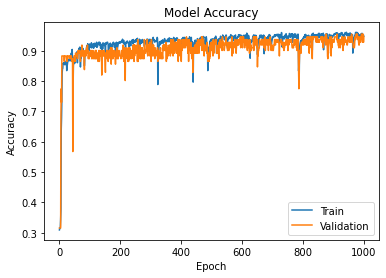

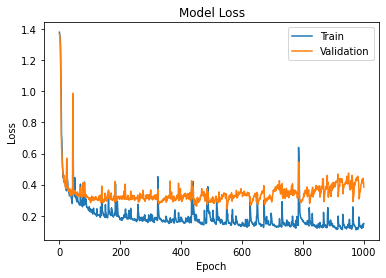

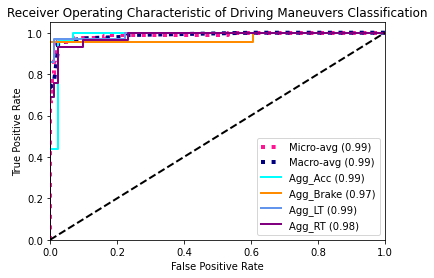

Fold score (accuracy):0.9459459459459459
Train Accuracy 94.81555223464966 Train_loss =  14.878648066144477
Test Accuracy =  94.59459185600281 Test loss =  38.378184980100336
Precision: 0.944252
Recall: 0.944252
F1 score: 0.944252
[[23  1  1  0]
 [ 0 21  0  1]
 [ 0  0 34  1]
 [ 2  0  0 27]]
Supervised Fold #10
X_labeled_train =  (1003, 10, 1)
X_labeled_test =  (111, 10, 1)
Y_labeled_train =  (1003, 4)
Y_labeled_test =  (111, 4)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/1000
1003/1003 [==============================] - 2s 2ms/step - loss: 1.3817 - accuracy: 0.2861 - val_loss: 1.3700 - val_accuracy: 0.3153
Epoch 2/1000
1003/1003 [==============================] - 1s 510us/step - loss: 1.3662 - accuracy: 0.3141 - val_loss: 1.3556 - val_accuracy: 0.3153
Epoch 3/1000
1003/1003 [==============================] - 1s 510us/step - loss: 1.3526 - accuracy: 0.3141 - val_loss: 1.3391 - val_accuracy: 0.3153
Epoch 4/1000
1003/1003 [==============================] - 1s 5

Epoch 53/1000
1003/1003 [==============================] - 1s 773us/step - loss: 0.2961 - accuracy: 0.8903 - val_loss: 0.4201 - val_accuracy: 0.8468
Epoch 54/1000
1003/1003 [==============================] - 1s 717us/step - loss: 0.2829 - accuracy: 0.8953 - val_loss: 0.3736 - val_accuracy: 0.8468
Epoch 55/1000
1003/1003 [==============================] - 1s 701us/step - loss: 0.2861 - accuracy: 0.8883 - val_loss: 0.3799 - val_accuracy: 0.8468
Epoch 56/1000
1003/1003 [==============================] - 1s 725us/step - loss: 0.2644 - accuracy: 0.9063 - val_loss: 0.3772 - val_accuracy: 0.8559
Epoch 57/1000
1003/1003 [==============================] - 1s 797us/step - loss: 0.2693 - accuracy: 0.9003 - val_loss: 0.3795 - val_accuracy: 0.8649
Epoch 58/1000
1003/1003 [==============================] - 1s 757us/step - loss: 0.2607 - accuracy: 0.8993 - val_loss: 0.3760 - val_accuracy: 0.8468
Epoch 59/1000
1003/1003 [==============================] - 1s 725us/step - loss: 0.2798 - accuracy: 0.8953

Epoch 108/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.2174 - accuracy: 0.9192 - val_loss: 0.3166 - val_accuracy: 0.8649
Epoch 109/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.2096 - accuracy: 0.9202 - val_loss: 0.3015 - val_accuracy: 0.8829
Epoch 110/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.2198 - accuracy: 0.9212 - val_loss: 0.3095 - val_accuracy: 0.8739
Epoch 111/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.2067 - accuracy: 0.9262 - val_loss: 0.3161 - val_accuracy: 0.8829
Epoch 112/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.2104 - accuracy: 0.9262 - val_loss: 0.3368 - val_accuracy: 0.8919
Epoch 113/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.2313 - accuracy: 0.9202 - val_loss: 0.3279 - val_accuracy: 0.8829
Epoch 114/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.2278 - accuracy:

1003/1003 [==============================] - 1s 717us/step - loss: 0.4810 - accuracy: 0.8584 - val_loss: 0.3903 - val_accuracy: 0.8739
Epoch 163/1000
1003/1003 [==============================] - 1s 717us/step - loss: 0.3159 - accuracy: 0.8863 - val_loss: 0.3622 - val_accuracy: 0.8559
Epoch 164/1000
1003/1003 [==============================] - 1s 819us/step - loss: 0.2642 - accuracy: 0.8943 - val_loss: 0.3575 - val_accuracy: 0.8829
Epoch 165/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.2593 - accuracy: 0.9013 - val_loss: 0.3714 - val_accuracy: 0.8739
Epoch 166/1000
1003/1003 [==============================] - 1s 646us/step - loss: 0.2408 - accuracy: 0.9073 - val_loss: 0.3339 - val_accuracy: 0.8559
Epoch 167/1000
1003/1003 [==============================] - 1s 693us/step - loss: 0.2213 - accuracy: 0.9172 - val_loss: 0.3299 - val_accuracy: 0.8919
Epoch 168/1000
1003/1003 [==============================] - 1s 678us/step - loss: 0.2223 - accuracy: 0.9163 - val_l

Epoch 217/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1805 - accuracy: 0.9342 - val_loss: 0.2883 - val_accuracy: 0.8919
Epoch 218/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.2358 - accuracy: 0.9023 - val_loss: 0.2665 - val_accuracy: 0.9189
Epoch 219/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.1889 - accuracy: 0.9272 - val_loss: 0.3328 - val_accuracy: 0.8829
Epoch 220/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.2279 - accuracy: 0.9133 - val_loss: 0.3339 - val_accuracy: 0.8829
Epoch 221/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.2061 - accuracy: 0.9252 - val_loss: 0.3043 - val_accuracy: 0.9009
Epoch 222/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1857 - accuracy: 0.9302 - val_loss: 0.2952 - val_accuracy: 0.9009
Epoch 223/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.2106 - accuracy:

1003/1003 [==============================] - 1s 638us/step - loss: 0.1898 - accuracy: 0.9292 - val_loss: 0.3143 - val_accuracy: 0.8919
Epoch 272/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1953 - accuracy: 0.9312 - val_loss: 0.3130 - val_accuracy: 0.8829
Epoch 273/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1835 - accuracy: 0.9252 - val_loss: 0.3138 - val_accuracy: 0.8919
Epoch 274/1000
1003/1003 [==============================] - 1s 646us/step - loss: 0.1890 - accuracy: 0.9352 - val_loss: 0.3223 - val_accuracy: 0.8919
Epoch 275/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1925 - accuracy: 0.9262 - val_loss: 0.3076 - val_accuracy: 0.8919
Epoch 276/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1773 - accuracy: 0.9322 - val_loss: 0.3286 - val_accuracy: 0.8739
Epoch 277/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.2148 - accuracy: 0.9163 - val_l

Epoch 326/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1716 - accuracy: 0.9332 - val_loss: 0.2905 - val_accuracy: 0.8919
Epoch 327/1000
1003/1003 [==============================] - 1s 685us/step - loss: 0.1719 - accuracy: 0.9372 - val_loss: 0.3027 - val_accuracy: 0.8919
Epoch 328/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1750 - accuracy: 0.9342 - val_loss: 0.3136 - val_accuracy: 0.8919
Epoch 329/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.1776 - accuracy: 0.9292 - val_loss: 0.3050 - val_accuracy: 0.8829
Epoch 330/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.2827 - accuracy: 0.9083 - val_loss: 0.2949 - val_accuracy: 0.8829
Epoch 331/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.2275 - accuracy: 0.9182 - val_loss: 0.3103 - val_accuracy: 0.8829
Epoch 332/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.2019 - accuracy:

1003/1003 [==============================] - 1s 598us/step - loss: 0.2112 - accuracy: 0.9083 - val_loss: 0.3066 - val_accuracy: 0.8739
Epoch 381/1000
1003/1003 [==============================] - 1s 670us/step - loss: 0.1907 - accuracy: 0.9262 - val_loss: 0.2964 - val_accuracy: 0.9009
Epoch 382/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.1863 - accuracy: 0.9312 - val_loss: 0.2937 - val_accuracy: 0.9009
Epoch 383/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1829 - accuracy: 0.9322 - val_loss: 0.2991 - val_accuracy: 0.9099
Epoch 384/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1755 - accuracy: 0.9392 - val_loss: 0.3076 - val_accuracy: 0.9009
Epoch 385/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1731 - accuracy: 0.9352 - val_loss: 0.3013 - val_accuracy: 0.8829
Epoch 386/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1839 - accuracy: 0.9282 - val_l

Epoch 435/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1740 - accuracy: 0.9342 - val_loss: 0.3004 - val_accuracy: 0.9009
Epoch 436/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1627 - accuracy: 0.9392 - val_loss: 0.3300 - val_accuracy: 0.9099
Epoch 437/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1607 - accuracy: 0.9342 - val_loss: 0.2948 - val_accuracy: 0.9099
Epoch 438/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1598 - accuracy: 0.9372 - val_loss: 0.3073 - val_accuracy: 0.9099
Epoch 439/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1627 - accuracy: 0.9312 - val_loss: 0.3023 - val_accuracy: 0.9099
Epoch 440/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1516 - accuracy: 0.9382 - val_loss: 0.3087 - val_accuracy: 0.9099
Epoch 441/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1655 - accuracy:

1003/1003 [==============================] - 1s 574us/step - loss: 0.1545 - accuracy: 0.9412 - val_loss: 0.3212 - val_accuracy: 0.9189
Epoch 490/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1534 - accuracy: 0.9472 - val_loss: 0.3151 - val_accuracy: 0.9099
Epoch 491/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1518 - accuracy: 0.9452 - val_loss: 0.3311 - val_accuracy: 0.9099
Epoch 492/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1413 - accuracy: 0.9472 - val_loss: 0.3511 - val_accuracy: 0.9189
Epoch 493/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1514 - accuracy: 0.9452 - val_loss: 0.3128 - val_accuracy: 0.9099
Epoch 494/1000
1003/1003 [==============================] - 1s 590us/step - loss: 0.1528 - accuracy: 0.9412 - val_loss: 0.3415 - val_accuracy: 0.9189
Epoch 495/1000
1003/1003 [==============================] - 1s 693us/step - loss: 0.1464 - accuracy: 0.9452 - val_l

Epoch 544/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1529 - accuracy: 0.9422 - val_loss: 0.2944 - val_accuracy: 0.9189
Epoch 545/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1493 - accuracy: 0.9412 - val_loss: 0.4235 - val_accuracy: 0.9099
Epoch 546/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1515 - accuracy: 0.9462 - val_loss: 0.3157 - val_accuracy: 0.9279
Epoch 547/1000
1003/1003 [==============================] - 1s 693us/step - loss: 0.1938 - accuracy: 0.9262 - val_loss: 0.2839 - val_accuracy: 0.9099
Epoch 548/1000
1003/1003 [==============================] - 1s 685us/step - loss: 0.1669 - accuracy: 0.9432 - val_loss: 0.3312 - val_accuracy: 0.9009
Epoch 549/1000
1003/1003 [==============================] - 1s 674us/step - loss: 0.1583 - accuracy: 0.9382 - val_loss: 0.3592 - val_accuracy: 0.8829
Epoch 550/1000
1003/1003 [==============================] - 1s 626us/step - loss: 0.1661 - accuracy:

1003/1003 [==============================] - 1s 606us/step - loss: 0.1441 - accuracy: 0.9541 - val_loss: 0.3499 - val_accuracy: 0.9189
Epoch 599/1000
1003/1003 [==============================] - 1s 624us/step - loss: 0.1401 - accuracy: 0.9482 - val_loss: 0.3774 - val_accuracy: 0.9369
Epoch 600/1000
1003/1003 [==============================] - 1s 610us/step - loss: 0.1664 - accuracy: 0.9382 - val_loss: 0.2796 - val_accuracy: 0.9189
Epoch 601/1000
1003/1003 [==============================] - 1s 611us/step - loss: 0.1517 - accuracy: 0.9412 - val_loss: 0.3848 - val_accuracy: 0.9369
Epoch 602/1000
1003/1003 [==============================] - 1s 643us/step - loss: 0.1573 - accuracy: 0.9362 - val_loss: 0.3088 - val_accuracy: 0.9279
Epoch 603/1000
1003/1003 [==============================] - 1s 601us/step - loss: 0.1600 - accuracy: 0.9392 - val_loss: 0.2967 - val_accuracy: 0.9279
Epoch 604/1000
1003/1003 [==============================] - 1s 644us/step - loss: 0.1530 - accuracy: 0.9472 - val_l

Epoch 653/1000
1003/1003 [==============================] - 1s 717us/step - loss: 0.1334 - accuracy: 0.9541 - val_loss: 0.3957 - val_accuracy: 0.9279
Epoch 654/1000
1003/1003 [==============================] - 1s 662us/step - loss: 0.1458 - accuracy: 0.9482 - val_loss: 0.3509 - val_accuracy: 0.9099
Epoch 655/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1377 - accuracy: 0.9492 - val_loss: 0.3264 - val_accuracy: 0.9369
Epoch 656/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1406 - accuracy: 0.9472 - val_loss: 0.3163 - val_accuracy: 0.9099
Epoch 657/1000
1003/1003 [==============================] - 1s 685us/step - loss: 0.1453 - accuracy: 0.9462 - val_loss: 0.4336 - val_accuracy: 0.8919
Epoch 658/1000
1003/1003 [==============================] - 1s 646us/step - loss: 0.3255 - accuracy: 0.8744 - val_loss: 0.2992 - val_accuracy: 0.8919
Epoch 659/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.2370 - accuracy:

1003/1003 [==============================] - 1s 630us/step - loss: 0.1494 - accuracy: 0.9412 - val_loss: 0.3120 - val_accuracy: 0.9009
Epoch 708/1000
1003/1003 [==============================] - 1s 566us/step - loss: 0.1467 - accuracy: 0.9402 - val_loss: 0.3162 - val_accuracy: 0.9009
Epoch 709/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1455 - accuracy: 0.9482 - val_loss: 0.3183 - val_accuracy: 0.9009
Epoch 710/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1418 - accuracy: 0.9462 - val_loss: 0.3186 - val_accuracy: 0.9009
Epoch 711/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1374 - accuracy: 0.9521 - val_loss: 0.3291 - val_accuracy: 0.9189
Epoch 712/1000
1003/1003 [==============================] - 1s 646us/step - loss: 0.1380 - accuracy: 0.9501 - val_loss: 0.3282 - val_accuracy: 0.9189
Epoch 713/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1413 - accuracy: 0.9482 - val_l

Epoch 762/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1295 - accuracy: 0.9531 - val_loss: 0.3720 - val_accuracy: 0.9189
Epoch 763/1000
1003/1003 [==============================] - 1s 606us/step - loss: 0.1313 - accuracy: 0.9511 - val_loss: 0.3744 - val_accuracy: 0.9279
Epoch 764/1000
1003/1003 [==============================] - 1s 598us/step - loss: 0.1290 - accuracy: 0.9511 - val_loss: 0.4022 - val_accuracy: 0.9279
Epoch 765/1000
1003/1003 [==============================] - 1s 654us/step - loss: 0.1290 - accuracy: 0.9521 - val_loss: 0.4369 - val_accuracy: 0.9279
Epoch 766/1000
1003/1003 [==============================] - 1s 630us/step - loss: 0.1305 - accuracy: 0.9581 - val_loss: 0.3441 - val_accuracy: 0.9279
Epoch 767/1000
1003/1003 [==============================] - 1s 678us/step - loss: 0.1268 - accuracy: 0.9591 - val_loss: 0.3409 - val_accuracy: 0.9189
Epoch 768/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1321 - accuracy:

1003/1003 [==============================] - 1s 574us/step - loss: 0.1274 - accuracy: 0.9501 - val_loss: 0.4218 - val_accuracy: 0.9189
Epoch 817/1000
1003/1003 [==============================] - 1s 574us/step - loss: 0.1315 - accuracy: 0.9571 - val_loss: 0.4281 - val_accuracy: 0.9279
Epoch 818/1000
1003/1003 [==============================] - 1s 558us/step - loss: 0.1261 - accuracy: 0.9571 - val_loss: 0.4060 - val_accuracy: 0.9189
Epoch 819/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1312 - accuracy: 0.9521 - val_loss: 0.4046 - val_accuracy: 0.9279
Epoch 820/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1280 - accuracy: 0.9551 - val_loss: 0.4037 - val_accuracy: 0.9279
Epoch 821/1000
1003/1003 [==============================] - 1s 638us/step - loss: 0.1316 - accuracy: 0.9472 - val_loss: 0.4158 - val_accuracy: 0.9279
Epoch 822/1000
1003/1003 [==============================] - 1s 678us/step - loss: 0.1239 - accuracy: 0.9551 - val_l

Epoch 871/1000
1003/1003 [==============================] - 1s 552us/step - loss: 0.1218 - accuracy: 0.9581 - val_loss: 0.3232 - val_accuracy: 0.9279
Epoch 872/1000
1003/1003 [==============================] - 1s 548us/step - loss: 0.1188 - accuracy: 0.9581 - val_loss: 0.2931 - val_accuracy: 0.9279
Epoch 873/1000
1003/1003 [==============================] - 1s 582us/step - loss: 0.1139 - accuracy: 0.9601 - val_loss: 0.3644 - val_accuracy: 0.9279
Epoch 874/1000
1003/1003 [==============================] - 1s 614us/step - loss: 0.1142 - accuracy: 0.9601 - val_loss: 0.3673 - val_accuracy: 0.9189
Epoch 875/1000
1003/1003 [==============================] - 1s 742us/step - loss: 0.1205 - accuracy: 0.9561 - val_loss: 0.2695 - val_accuracy: 0.9189
Epoch 876/1000
1003/1003 [==============================] - 1s 622us/step - loss: 0.1236 - accuracy: 0.9601 - val_loss: 0.3210 - val_accuracy: 0.9099
Epoch 877/1000
1003/1003 [==============================] - 1s 726us/step - loss: 0.1240 - accuracy:

1003/1003 [==============================] - 1s 510us/step - loss: 0.1419 - accuracy: 0.9482 - val_loss: 0.2695 - val_accuracy: 0.9189
Epoch 926/1000
1003/1003 [==============================] - 1s 518us/step - loss: 0.1359 - accuracy: 0.9511 - val_loss: 0.2697 - val_accuracy: 0.9279
Epoch 927/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1183 - accuracy: 0.9571 - val_loss: 0.2799 - val_accuracy: 0.9279
Epoch 928/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1168 - accuracy: 0.9621 - val_loss: 0.2719 - val_accuracy: 0.9189
Epoch 929/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1206 - accuracy: 0.9591 - val_loss: 0.3054 - val_accuracy: 0.9189
Epoch 930/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1177 - accuracy: 0.9601 - val_loss: 0.2792 - val_accuracy: 0.9189
Epoch 931/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.1200 - accuracy: 0.9581 - val_l

Epoch 980/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1178 - accuracy: 0.9571 - val_loss: 0.3518 - val_accuracy: 0.9369
Epoch 981/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1449 - accuracy: 0.9551 - val_loss: 0.2950 - val_accuracy: 0.9369
Epoch 982/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1423 - accuracy: 0.9511 - val_loss: 0.3242 - val_accuracy: 0.9369
Epoch 983/1000
1003/1003 [==============================] - 0s 486us/step - loss: 0.1196 - accuracy: 0.9591 - val_loss: 0.3804 - val_accuracy: 0.9279
Epoch 984/1000
1003/1003 [==============================] - 0s 494us/step - loss: 0.1180 - accuracy: 0.9601 - val_loss: 0.3485 - val_accuracy: 0.9369
Epoch 985/1000
1003/1003 [==============================] - 1s 510us/step - loss: 0.1686 - accuracy: 0.9501 - val_loss: 0.4787 - val_accuracy: 0.9279
Epoch 986/1000
1003/1003 [==============================] - 1s 502us/step - loss: 0.1282 - accuracy:

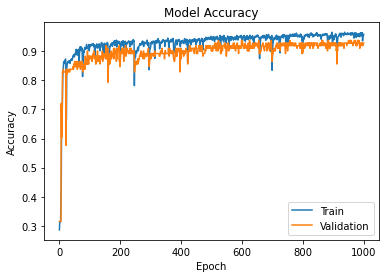

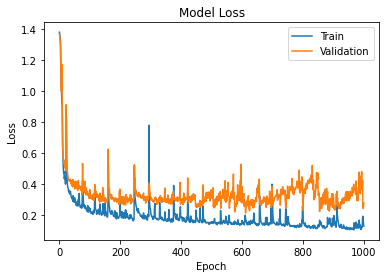

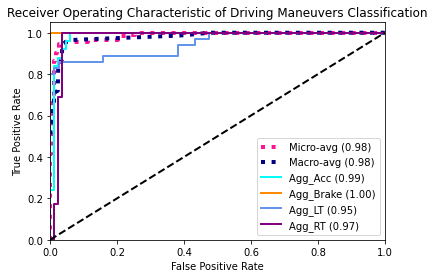

Fold score (accuracy):0.9279279279279279
Train Accuracy 96.31106853485107 Train_loss =  12.006205968105663
Test Accuracy =  92.79279112815857 Test loss =  27.936627843358497
Precision: 0.932515
Recall: 0.935779
F1 score: 0.931383
[[24  0  1  0]
 [ 1 21  0  0]
 [ 3  0 29  3]
 [ 0  0  0 29]]


In [30]:
X_labeled_encoded = encoder_model.predict(X_labeled)
print('X_labeled_encoded.shape', X_labeled_encoded.shape)
    
skf(X_labeled_encoded)

In [31]:
#https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/